CHALLENGE 1


Group name: DeepMind Musketeers

Members:

Naclerio Andrea - andrea.naclerio@mail.polimi.it

Pivetta Federico - federico1.pivetta@mail.polimi.it

Spolaor Alessandro - alessandro.spolaor@mail.polimi.it

#Connect to google drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/[2023-2024] AN2DL/Challenge 1

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/[2023-2024] AN2DL/Challenge 1


#Import libraries

In [ ]:
# Fix randomness
seed = 42
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'
# hide warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)
import logging
import random
random.seed(seed)
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
#print(tf.__version__) #check version compatibility
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rc('font', size=16)
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator

# Our function

In [ ]:
def augmentation(x,y):
# it balances the number of sample in (x,y) by upsampling the less frequent class ('unhealthy')
# inputs:
# x -> (N,96,96,3)
# y -> (N,1)
# outputs:
# x_aug -> (M,96,96,3)
# y_aug -> (M,2)

  encoder = OneHotEncoder(handle_unknown='ignore')
  encoder.fit(y)
  dummy = encoder.transform(y).toarray()
  Y = pd.DataFrame(dummy,columns=encoder.categories_)
  Y = Y.to_numpy()
  miss =int(np.sum(Y[:,0])-np.sum(Y[:,1])) #augmentation in order to have the same number healthy and unhelathy subject

  indices = np.where((Y[:, 0] == 0) & (Y[:, 1] == 1))[0] #total number of unhelathy targets (look at the initial unbalance between healthy and unhealthy)
  selected_indices = np.random.choice(indices, miss, replace=False) # Randomly select N indices from the filtered indices
  subset_X = x[selected_indices] # Randomly select N indices from the filtered indices
  #print("Shape of subset_X:", subset_X.shape) # Verify the shape of the subset

  augmentationNet = tf.keras.Sequential([
  tfkl.RandomFlip("horizontal_and_vertical"),
  tfkl.RandomTranslation(0.1,0.1),
  tfkl.RandomRotation(0.25),
  tfkl.RandomZoom(0.2)
  #tfkl.RandomBrightness(0.2, value_range=(0,1)),
  ], name='augmentationNet')

  augmented_X = augmentationNet(subset_X)

  x_aug =np.concatenate((x,augmented_X),axis=0)
  #print(x_aug.shape) #check dimension
  augmented_y = np.ones((miss, 2))
  augmented_y[:, 0] = 0
  augmented_y=augmented_y.astype('int')
  y_aug=np.concatenate((Y,augmented_y),axis=0)
  #print(y.shape) #check dimension
  x_aug, y_aug= shuffle(x_aug, y_aug, random_state=0) # shuffle them to not induce bias

  return x_aug, y_aug

In [ ]:
def show_metrics(model,X_val,y_val,preprocess_input):
# it plots the confusion matrix of model and returns accuracy,precision, recall and f1_score
# inputs:
# model
# X_val -> (N,96,96,3)
# y_val -> (N,2)
# preprocess_input -> preprocess used in the input of the respective model

  predictions = model.predict(preprocess_input(X_val*255), verbose=0)
  predictions.shape
  cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
  accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
  precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
  recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
  f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
  print('Accuracy:', accuracy.round(4))
  print('Precision:', precision.round(4))
  print('Recall:', recall.round(4))
  print('F1:', f1.round(4))
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm.T, xticklabels=list(('healthy','unhealthy')), yticklabels=list(('healthy','unhealthy')), cmap='Blues', annot=True)
  plt.xlabel('True labels')
  plt.ylabel('Predicted labels')
  plt.show()
  print('\n\n')
  return accuracy,precision,recall,f1

In [ ]:
def plot_loss_accuracy_trend(history,metrics='val_accuracy'):
  # it plots the graph of the trend of training and validation accuracy and loss
  # input:
  # history -> ()
  # metrics -> string that identifies the criteria of early stopping and selection of the best weights

  if metrics=='val_accuracy':
    best_epoch = np.argmax(history['val_accuracy']) # epoch with the highest validation accuracy
  else:
    best_epoch = np.argmin(history['val_loss']) # epoch with the lowest validation loss

  plt.figure(figsize=(20, 5))
  plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
  plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
  plt.plot(best_epoch, history['val_loss'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
  plt.legend(loc='upper left')
  plt.title('Categorical Crossentropy')
  plt.grid(alpha=0.3)
  plt.figure(figsize=(20, 5))
  plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
  plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
  plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
  plt.legend(loc='upper left')
  plt.title('Accuracy')
  plt.grid(alpha=0.3)
  plt.show()

#Data

##Import data

In [ ]:
import zipfile
zip = zipfile.ZipFile('/gdrive/MyDrive/[2023-2024] AN2DL/Challenge 1/public_data.zip')
zip.extractall('/gdrive/MyDrive/[2023-2024] AN2DL/Challenge 1')
zip.close()

In [ ]:
input_directory =('/gdrive/MyDrive/[2023-2024] AN2DL/Challenge 1/public_data')
data=b = np.load('public_data.npz', allow_pickle=True)

In [ ]:
print(data.files)

['data', 'labels']


In [ ]:
y=data['labels']
x=data['data']

##Inspect data

In [ ]:
print('x shape: ',x.shape)
print('y shape: ',y.shape)

x shape:  (5200, 96, 96, 3)
y shape:  (5200,)


In [ ]:
x[1] # to visualize the type of data

array([[[ 94., 125.,  83.],
        [ 46.,  79.,  34.],
        [ 62., 103.,  47.],
        ...,
        [129., 178., 133.],
        [125., 174., 127.],
        [124., 173., 126.]],

       [[ 67.,  98.,  56.],
        [ 31.,  64.,  19.],
        [ 57.,  98.,  42.],
        ...,
        [129., 177., 135.],
        [129., 178., 133.],
        [130., 179., 134.]],

       [[  1.,  32.,   0.],
        [  0.,  30.,   0.],
        [ 53.,  94.,  38.],
        ...,
        [139., 185., 149.],
        [135., 181., 144.],
        [134., 180., 143.]],

       ...,

       [[144., 194., 159.],
        [139., 189., 154.],
        [139., 189., 154.],
        ...,
        [138., 193., 151.],
        [138., 193., 153.],
        [142., 197., 157.]],

       [[142., 192., 157.],
        [142., 192., 157.],
        [146., 196., 161.],
        ...,
        [147., 201., 165.],
        [145., 199., 163.],
        [152., 206., 170.]],

       [[141., 191., 156.],
        [143., 193., 158.],
        [148., 1

In [ ]:
# to visualize classes and data distribution
unique, count = np.unique(y, return_counts=True)
print('Target labels:',unique)
for i,u in enumerate(unique):
    print(f'Quality {unique[i]} has {count[i]} samples')

Target labels: ['healthy' 'unhealthy']
Quality healthy has 3199 samples
Quality unhealthy has 2001 samples


In [ ]:
x=x/255 # convert into 0-1
y=np.expand_dims(y,axis=-1) #expand the dimension

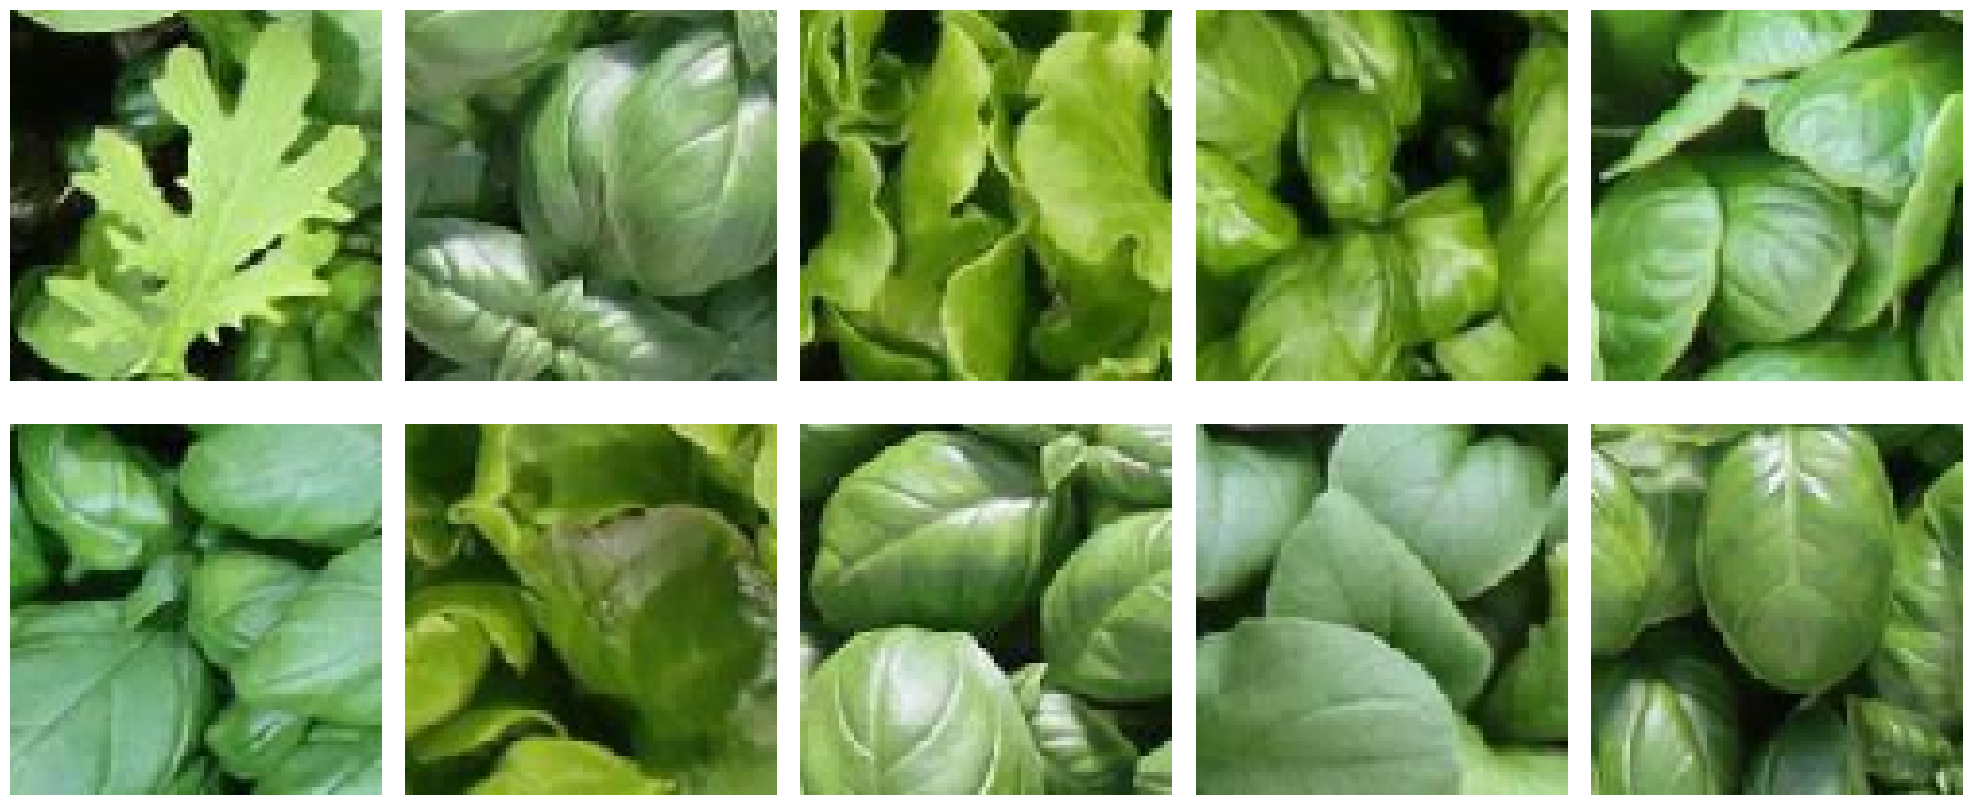

In [ ]:
num_img = 10 # Number of images to display
# Create subplots for displaying items
fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
for i in range(num_img):
    ax = axes[i%2, i%num_img//2]
    ax.imshow(x[i])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
for i in range(num_img):
  print('Sample ', i,' is: ', y[i]) #to see in which class each sample belongs to

Sample  0  is:  ['healthy']
Sample  1  is:  ['healthy']
Sample  2  is:  ['healthy']
Sample  3  is:  ['unhealthy']
Sample  4  is:  ['unhealthy']
Sample  5  is:  ['healthy']
Sample  6  is:  ['unhealthy']
Sample  7  is:  ['healthy']
Sample  8  is:  ['healthy']
Sample  9  is:  ['healthy']


## Remove outliers
by looking at images we found some outliers: images that are not leafs -> remove them

In [ ]:
count = 0
images = [0]*5004
for i in range(0,x.shape[0]):
  if not(np.all(x[i] == x[338]) or np.all(x[i] == x[58])):
    images[count] = i # select all the images that are not equal to Shrek or Trololo (Red-blue image)
    count +=1
x = x[images]
y = y[images]

## Split train-validation

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(x, y, random_state=seed, test_size=.25, stratify=y)

## Training set augmentation


### 1st augmentation: balance training set

In [ ]:
X_train,y_train = augmentation(X_train,y_train)

### 2nd augmentation: increase the number of unhealthy to fine tune models

In [ ]:
num_augmented_healthy = 1 # number of augmented healthy images for each image
num_augmented_unhealthy = 3 # number of augmented unhealthy images for each image
datagen = ImageDataGenerator(
    rotation_range=45,  # Randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.15,  # Randomly shift images horizontally (fraction of total width)
    height_shift_range=0.15,  # Randomly shift images vertically (fraction of total height)
    zoom_range=0.2,  # Randomly zoom inside images
    horizontal_flip=True,  # Randomly flip images horizontally
    vertical_flip=True,
    fill_mode='reflect'  # Strategy used for filling in newly created pixels after rotation or shifting
)


indices = np.where(y_train=="healthy")[0]
X_healthy = X_train[indices]
augmented_healthy = []
for img in X_healthy:
    img = img.reshape((1,) + img.shape)
    i = 0
    for batch in datagen.flow(img, batch_size=1):
        augmented_healthy.append(batch[0])
        i += 1
        if i >= num_augmented_healthy:
            break
augmented_healthy = np.array(augmented_healthy)
subset_y_healthy = np.ones((len(augmented_healthy), 2)) # (1,0) -> healthy
subset_y_healthy[:, 1] = 0


indices = np.where(y_train=="unhealthy")[0]
X_unhealthy = X_train[indices]
augmented_unhealthy = []
for img in X_unhealthy:
    img = img.reshape((1,) + img.shape)
    i = 0
    for batch in datagen.flow(img, batch_size=1):
        augmented_unhealthy.append(batch[0])
        i += 1
        if i >= num_augmented_unhealthy:
            break
augmented_unhealthy = np.array(augmented_unhealthy)
subset_y_unhealthy = np.ones((len(augmented_unhealthy), 2)) # (0,1) -> unhealthy
subset_y_unhealthy[:, 0] = 0


X_train_2=np.concatenate((augmented_healthy,augmented_unhealthy),axis=0)
y_train_2=np.concatenate((subset_y_healthy,subset_y_unhealthy),axis=0)

X_train_2, y_train_2= shuffle(X_train, y_train, random_state=0)

###3th augmentation: increase the number of healthy to fine tune models

In [ ]:
num_augmented_healthy = 3 # number of augmented healthy images for each image
num_augmented_unhealthy = 1 # number of augmented unhealthy images for each image
datagen = ImageDataGenerator(
    rotation_range=45,  # Randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.15,  # Randomly shift images horizontally (fraction of total width)
    height_shift_range=0.15,  # Randomly shift images vertically (fraction of total height)
    zoom_range=0.2,  # Randomly zoom inside images
    horizontal_flip=True,  # Randomly flip images horizontally
    vertical_flip=True,
    fill_mode='reflect'  # Strategy used for filling in newly created pixels after rotation or shifting
)


indices = np.where(y_train=="healthy")[0]
X_healthy = X_train[indices]
augmented_healthy = []
for img in X_healthy:
    img = img.reshape((1,) + img.shape)
    i = 0
    for batch in datagen.flow(img, batch_size=1):
        augmented_healthy.append(batch[0])
        i += 1
        if i >= num_augmented_healthy:
            break
augmented_healthy = np.array(augmented_healthy)
subset_y_healthy = np.ones((len(augmented_healthy), 2)) # (1,0) -> healthy
subset_y_healthy[:, 1] = 0


indices = np.where(y_train=="unhealthy")[0]
X_unhealthy = X_train[indices]
augmented_unhealthy = []
for img in X_unhealthy:
    img = img.reshape((1,) + img.shape)
    i = 0
    for batch in datagen.flow(img, batch_size=1):
        augmented_unhealthy.append(batch[0])
        i += 1
        if i >= num_augmented_unhealthy:
            break
augmented_unhealthy = np.array(augmented_unhealthy)
subset_y_unhealthy = np.ones((len(augmented_unhealthy), 2)) # (0,1) -> unhealthy
subset_y_unhealthy[:, 0] = 0


X_train_3=np.concatenate((augmented_healthy,augmented_unhealthy),axis=0)
y_train_3=np.concatenate((subset_y_healthy,subset_y_unhealthy),axis=0)

X_train_3, y_train_3= shuffle(X_train, y_train, random_state=0)

## Convert y_val using OneHotEncorder

In [ ]:
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(y_val)
dummy = encoder.transform(y_val).toarray()
Y = pd.DataFrame(dummy,columns=encoder.categories_)
Y = Y.to_numpy()
y_val=Y

# Models

##LeafNet
https://www.sciencedirect.com/science/article/pii/S2666154323002946
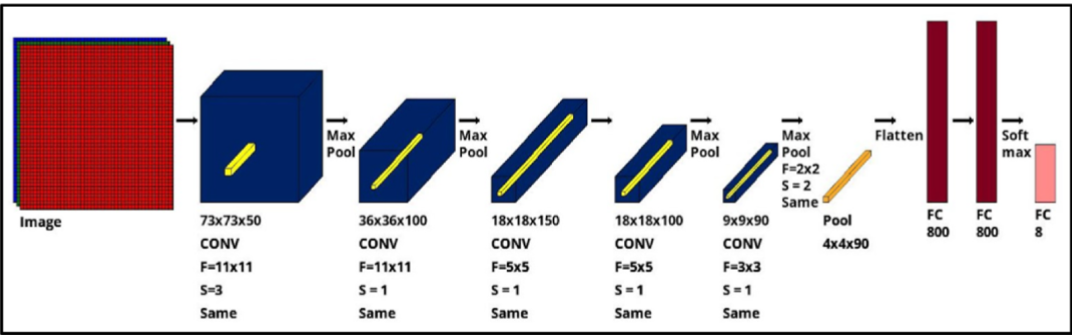

In [ ]:
from tensorflow.python.ops.math_ops import xlogy
def build_LeafNet(input_shape, seed=seed):
    tf.random.set_seed(seed)

    input_layer = tfkl.Input(shape=input_shape, name='Input')

    x = tfkl.Conv2D(
        filters=50,
        kernel_size=(11,11),
        padding='same',
        activation='relu',
        strides=3,
        name='conv_1'
    )(input_layer)
    x = tfkl.BatchNormalization(name='BatchNorm_1')(x)
    x = tfkl.MaxPooling2D(
        pool_size=(2,2),
        name='MaxPool_1'
    )(x)

    x = tfkl.Conv2D(
        filters=100,
        kernel_size=(11,11),
        padding='same',
        activation='relu',
        strides=1,
        name='conv_2'
    )(x)
    x = tfkl.BatchNormalization(name='BatchNorm_2')(x)
    x = tfkl.MaxPooling2D(
        pool_size=(2,2),
        name='MaxPool_2'
    )(x)

    x = tfkl.Conv2D(
        filters=150,
        kernel_size=(5,5),
        padding='same',
        activation='relu',
        strides=1,
        name='conv_3'
    )(x)
    x = tfkl.BatchNormalization(name='BatchNorm_3')(x)

    x = tfkl.Conv2D(
        filters=100,
        kernel_size=(5,5),
        padding='same',
        activation='relu',
        strides=1,
        name='conv_4'
    )(x)
    x = tfkl.BatchNormalization(name='BatchNorm_4')(x)
    x = tfkl.MaxPooling2D(
        pool_size=(2,2),
        name='MaxPool_3'
    )(x)

    x = tfkl.Conv2D(
        filters=90,
        kernel_size=(3,3),
        padding='same',
        activation='relu',
        strides=1,
        name='conv_5'
    )(x)
    x = tfkl.BatchNormalization(name='BatchNorm_5')(x)
    x = tfkl.MaxPooling2D(
        pool_size=(2,2),
        name='MaxPool_4'
    )(x)


    x=tfkl.Flatten()(x)

    x=tfkl.Dense(800,activation='relu')(x)
    x=tfkl.Dropout(rate=0.5,seed=seed)(x)

    x=tfkl.Dense(800,activation='relu')(x)
    x=tfkl.Dropout(rate=0.5,seed=seed)(x)

    x=tfkl.Dense(2,activation='softmax')(x)

    model = tfk.Model(inputs=input_layer, outputs=x, name='LeafNet')

    # Compile the model
    model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(0.00005), metrics=['accuracy'])

    return model
    #FC 2, softmax (last layer modified 8->2)

In [ ]:
LeafNet=build_LeafNet(input_shape=(96, 96, 3), seed=seed)
LeafNet.summary()

Model: "LeafNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 conv_1 (Conv2D)             (None, 32, 32, 50)        18200     
                                                                 
 BatchNorm_1 (BatchNormaliz  (None, 32, 32, 50)        200       
 ation)                                                          
                                                                 
 MaxPool_1 (MaxPooling2D)    (None, 16, 16, 50)        0         
                                                                 
 conv_2 (Conv2D)             (None, 16, 16, 100)       605100    
                                                                 
 BatchNorm_2 (BatchNormaliz  (None, 16, 16, 100)       400       
 ation)                                                    

In [ ]:
LeafNet_history = LeafNet.fit(
    x=X_train,
    y=y_train,
    batch_size=16,
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks=[tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=15, mode='max', restore_best_weights=True),
    tfk.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=7,factor=0.7,mode='min', min_lr=1e-5)]
).history

Epoch 1/200
291/291 [==============================] - 9s 15ms/step - loss: 0.8345 - accuracy: 0.5312 - val_loss: 0.6972 - val_accuracy: 0.5204 - lr: 5.0000e-05
Epoch 2/200
291/291 [==============================] - 4s 14ms/step - loss: 0.7306 - accuracy: 0.5763 - val_loss: 0.6708 - val_accuracy: 0.6003 - lr: 5.0000e-05
Epoch 3/200
291/291 [==============================] - 4s 15ms/step - loss: 0.6597 - accuracy: 0.6320 - val_loss: 1.8243 - val_accuracy: 0.3773 - lr: 5.0000e-05
Epoch 4/200
291/291 [==============================] - 4s 13ms/step - loss: 0.6068 - accuracy: 0.6887 - val_loss: 0.8026 - val_accuracy: 0.5580 - lr: 5.0000e-05
Epoch 5/200
291/291 [==============================] - 3s 12ms/step - loss: 0.5425 - accuracy: 0.7296 - val_loss: 0.9561 - val_accuracy: 0.6235 - lr: 5.0000e-05
Epoch 6/200
291/291 [==============================] - 4s 13ms/step - loss: 0.5034 - accuracy: 0.7730 - val_loss: 1.2868 - val_accuracy: 0.4309 - lr: 5.0000e-05
Epoch 7/200
291/291 [=============

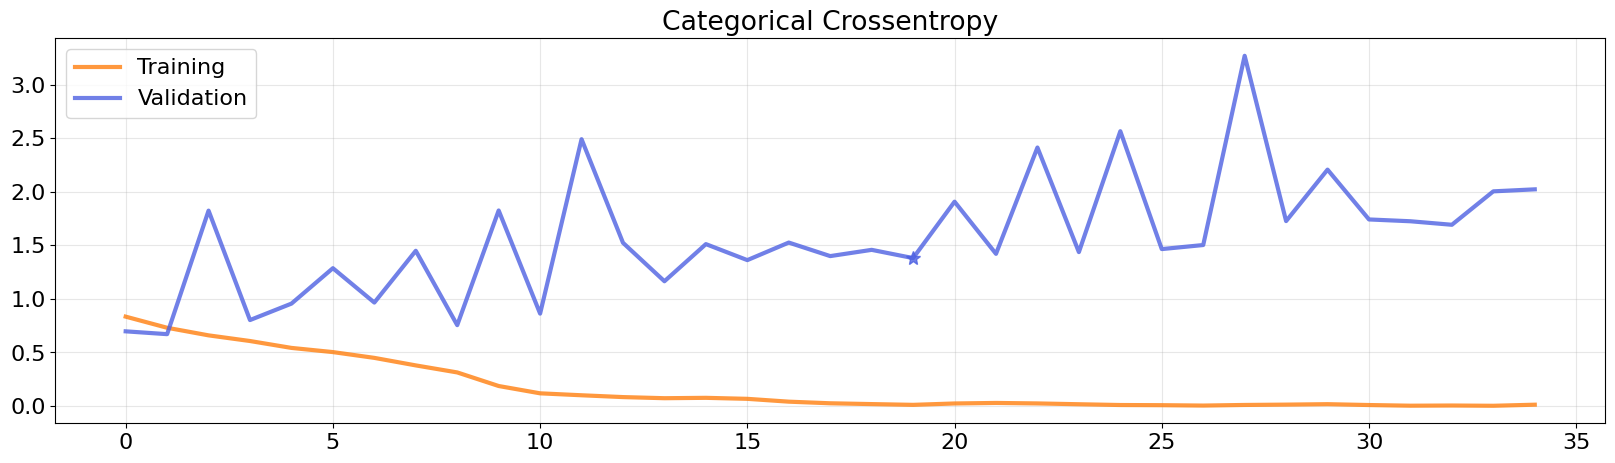

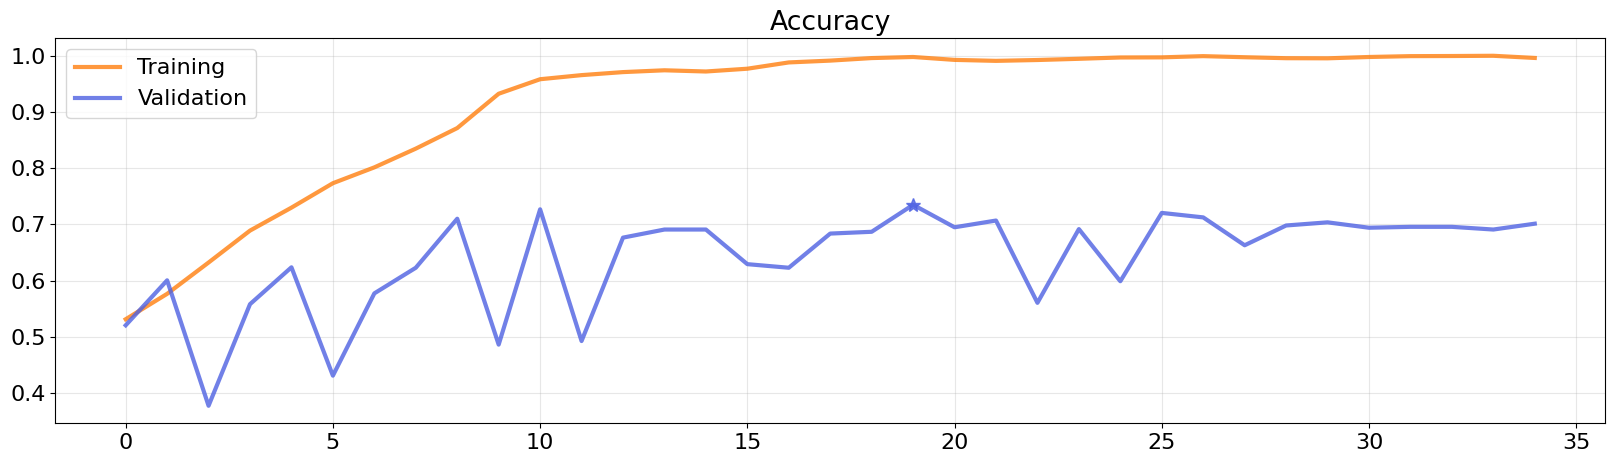

In [ ]:
plot_loss_accuracy_trend(LeafNet_history,metrics='val_accuracy')

40/40 [==============================] - 1s 5ms/step
Accuracy: 0.7346
Precision: 0.7215
Recall: 0.6999
F1: 0.7059


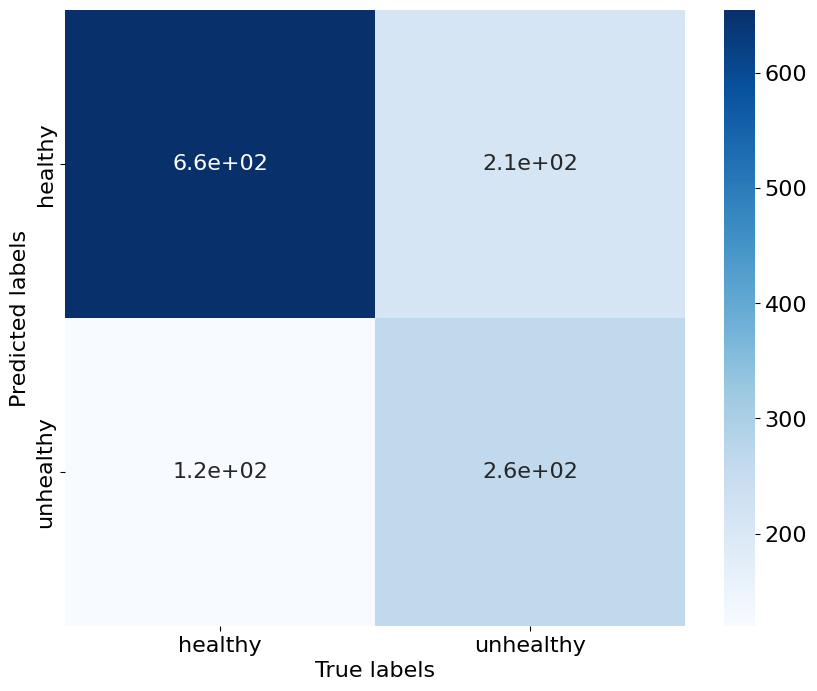

In [ ]:
(LeafNet_acc,LeafNet_pre,LeafNet_rec,LeafNet_f1)=show_metrics(LeafNet,X_val,y_val,preprocess_input=None)

In [ ]:
LeafNet.save('LeafNet')

In [ ]:
del LeafNet

##Original-made CNN

In [ ]:
def build_OriginalMadeCNN(input_shape, seed=seed):
    tf.random.set_seed(seed)

    input_layer = tfkl.Input(shape=input_shape, name='Input')

    x = tfkl.Conv2D(
        filters=5,
        kernel_size=(3,3),
        padding='same',
        activation='relu',
        strides=1,
        name='conv_1a'
    )(input_layer)

    x = tfkl.BatchNormalization(name='BatchNorm_1a')(x)

    x = tfkl.Conv2D(
        filters=5,
        kernel_size=(3,3),
        padding='same',
        activation='relu',
        strides=1,
        name='conv_1b'
    )(input_layer)

    x = tfkl.BatchNormalization(name='BatchNorm_1b')(x)

    x = tfkl.Conv2D(
        filters=5,
        kernel_size=(3,3),
        padding='same',
        activation='relu',
        strides=1,
        name='conv_1c'
    )(input_layer)

    x = tfkl.BatchNormalization(name='BatchNorm_1c')(x)

    x = tfkl.MaxPooling2D(
        pool_size=(2,2),
        name='MaxPool_1'
    )(x)

    x = tfkl.Conv2D(
        filters=10,
        kernel_size=(3,3),
        padding='same',
        activation='relu',
        strides=1,
        name='conv_2'
    )(x)

    x = tfkl.BatchNormalization(name='BatchNorm_2')(x)

    x = tfkl.MaxPooling2D(
        pool_size=(2,2),
        name='MaxPool_2'
    )(x)

    x = tfkl.Conv2D(
        filters=20,
        kernel_size=(3,3),
        padding='same',
        activation='relu',
        strides=1,
        name='conv_3'
    )(x)

    x = tfkl.BatchNormalization(name='BatchNorm_3')(x)

    x = tfkl.Conv2D(
        filters=32,
        kernel_size=(5,5),
        padding='valid',
        activation='relu',
        strides=1,
        name='conv_4'
    )(x)

    x = tfkl.BatchNormalization(name='BatchNorm_4')(x)

    x = tfkl.MaxPooling2D(
        pool_size=(2,2),
        name='MaxPool_3'
    )(x)

 #   x = tfkl.Conv2D(
  #      filters=75,
 #       kernel_size=(3,3),
 #       padding='valid',
 #       activation='relu',
 #       strides=1,
 #       name='conv_5'
 #   )(x)

 #   x = tfkl.BatchNormalization(name='BatchNorm_5')(x)

 #   x = tfkl.MaxPooling2D(
 #       pool_size=(2,2),
 #       name='MaxPool_4'
 #   )(x)

    #x=tfkl.Flatten()(x)
    x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    x=tfkl.Dense(64,activation='relu')(x)
    x=tfkl.Dropout(rate=0.1,seed=seed)(x)

    x=tfkl.Dense(32,activation='relu')(x)
    x=tfkl.Dropout(rate=0.1,seed=seed)(x)

    x=tfkl.Dense(10,activation='relu')(x)
   # x=tfkl.Dropout(rate=0.3,seed=seed)(x)

    x=tfkl.Dense(2,activation='softmax')(x)

    model = tfk.Model(inputs=input_layer, outputs=x, name='LeafNet')
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(0.0001), metrics=['accuracy'])

    return model


In [ ]:
OriginalMadeCNN=build_OriginalMadeCNN(input_shape=(96, 96, 3), seed=seed)
OriginalMadeCNN.summary()

Model: "LeafNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 conv_1c (Conv2D)            (None, 96, 96, 5)         140       
                                                                 
 BatchNorm_1c (BatchNormali  (None, 96, 96, 5)         20        
 zation)                                                         
                                                                 
 MaxPool_1 (MaxPooling2D)    (None, 48, 48, 5)         0         
                                                                 
 conv_2 (Conv2D)             (None, 48, 48, 10)        460       
                                                                 
 BatchNorm_2 (BatchNormaliz  (None, 48, 48, 10)        40        
 ation)                                                    

In [ ]:
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, mode='max', restore_best_weights=True)

OriginalMadeCNN_history = OriginalMadeCNN.fit(
    x=X_train,
    y=y_train,
    batch_size=16,
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
).history

Epoch 1/200
291/291 [==============================] - 64s 197ms/step - loss: 0.6894 - accuracy: 0.5529 - val_loss: 0.7627 - val_accuracy: 0.3805
Epoch 2/200
291/291 [==============================] - 65s 225ms/step - loss: 0.6014 - accuracy: 0.6978 - val_loss: 0.8218 - val_accuracy: 0.4436
Epoch 3/200
291/291 [==============================] - 50s 171ms/step - loss: 0.5043 - accuracy: 0.7521 - val_loss: 0.5389 - val_accuracy: 0.7194
Epoch 4/200
291/291 [==============================] - 57s 195ms/step - loss: 0.4689 - accuracy: 0.7696 - val_loss: 0.5261 - val_accuracy: 0.7410
Epoch 5/200
291/291 [==============================] - 52s 178ms/step - loss: 0.4517 - accuracy: 0.7784 - val_loss: 0.5474 - val_accuracy: 0.7170
Epoch 6/200
291/291 [==============================] - 52s 179ms/step - loss: 0.4456 - accuracy: 0.7788 - val_loss: 0.5022 - val_accuracy: 0.7514
Epoch 7/200
291/291 [==============================] - 49s 168ms/step - loss: 0.4375 - accuracy: 0.7829 - val_loss: 0.5031 -

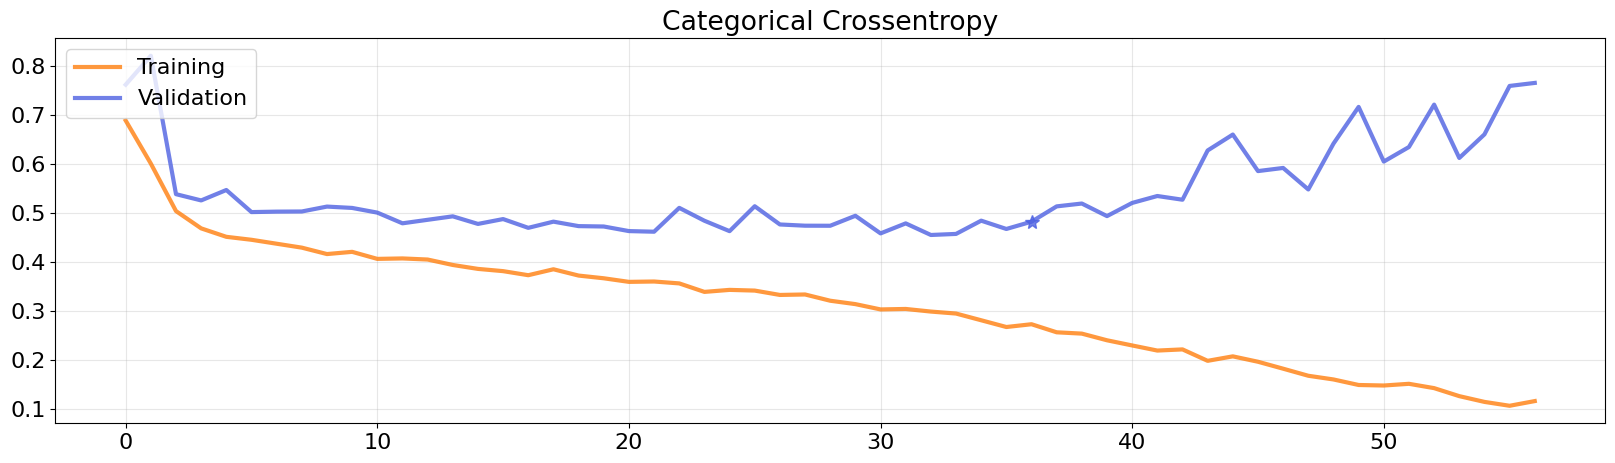

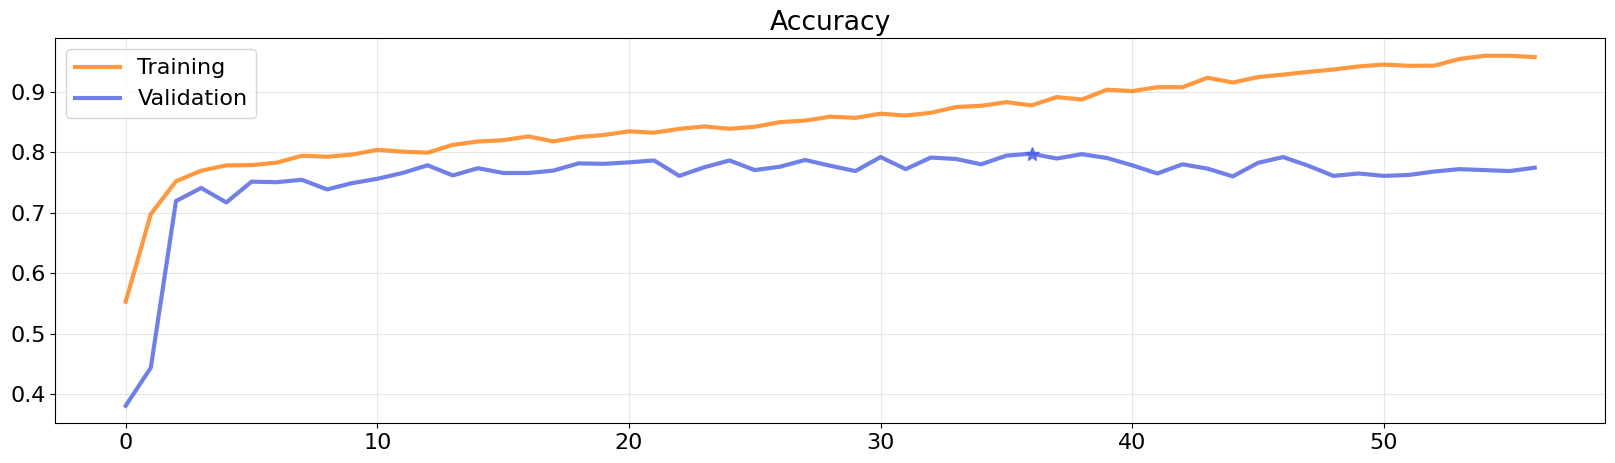

In [ ]:
plot_loss_accuracy_trend(OriginalMadeCNN_history,metrics='val_accuracy')

In [ ]:
OriginalMadeCNN.save('OriginalMadeCNN')

In [ ]:
del OriginalMadeCNN

##Xception
We conducted transfer learning on the Xception network, initially keeping the original weights fixed. In our initial approach, we added a softmax layer for classification, but the performance was subpar. Consequently, we augmented the number of trainable parameters by introducing two hidden layers with 512 and 128 neurons, respectively.
To address the challenge of handling a substantial number of parameters (1.1M), we incorporated the dropout technique with a rate of 0.4 for each dense layer. To mitigate overfitting, we implemented early stopping and a learning rate schedule. The parameters were fine-tuned to ensure a gradual learning process and to prevent overfitting.
Subsequently, we applied the fine-tuning technique to the network. Various models were generated by unlocking the network at different layers, and performance comparisons revealed that the optimal results were achieved when allowing the network to learn from layer 129. Despite the improvement through fine-tuning, the model's performance still lagged behind that of other models.


### Transfer learning + MLP

In [ ]:
from tensorflow.keras.applications.xception import preprocess_input

model = tfk.applications.Xception(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet", #you select the dataset to use for training weights
    pooling='avg',
)
tfk.utils.plot_model(model, show_shapes=True)
model.trainable = False #we don't want to train the model -> we freeze the pre-trained weights

#preprocessing = tf.keras.Sequential([tfkl.RandomContrast(0.3)
 # ], name='preprocessing') #we define the preprocessing layer and then we can insert it after the input layer
# it was underperforming

inputs = tfk.Input(shape=(96, 96, 3))
#x=preprocessing(inputs)
x = model(inputs) # (x)

x=tfkl.Dense(512, activation='softmax')(x)
x=tfkl.Dropout(rate=0.3, seed=seed)(x) # dropout to prevent overfitting

x=tfkl.Dense(128, activation='softmax')(x)
x=tfkl.Dropout(rate=0.3, seed=seed)(x)  # dropout to prevent overfitting

outputs = tfkl.Dense(2, activation='softmax')(x)

Xception = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
Xception.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(0.0002), metrics=['accuracy'])

Xception.summary()# Display model summary

83683744/83683744 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                              

In [ ]:
# Train the model
Xception_history = Xception.fit(
    x = preprocess_input(X_train*255), # we apply the preprcessing od Xception architecture
    y = y_train,
    batch_size = 32,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True),
    tfk.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=8,factor=0.5,mode='min', min_lr=1e-5)]
).history
# using a GridSearch approach we optimized the values of the LR in the optimizer, the patiences and factor


Epoch 1/200
146/146 [==============================] - 31s 87ms/step - loss: 0.6930 - accuracy: 0.5127 - val_loss: 0.6935 - val_accuracy: 0.3805 - lr: 2.0000e-04
Epoch 2/200
146/146 [==============================] - 6s 40ms/step - loss: 0.6923 - accuracy: 0.5488 - val_loss: 0.6924 - val_accuracy: 0.6131 - lr: 2.0000e-04
Epoch 3/200
146/146 [==============================] - 6s 39ms/step - loss: 0.6908 - accuracy: 0.6152 - val_loss: 0.6907 - val_accuracy: 0.6811 - lr: 2.0000e-04
Epoch 4/200
146/146 [==============================] - 5s 36ms/step - loss: 0.6894 - accuracy: 0.6561 - val_loss: 0.6889 - val_accuracy: 0.7074 - lr: 2.0000e-04
Epoch 5/200
146/146 [==============================] - 6s 38ms/step - loss: 0.6874 - accuracy: 0.6758 - val_loss: 0.6873 - val_accuracy: 0.7090 - lr: 2.0000e-04
Epoch 6/200
146/146 [==============================] - 6s 41ms/step - loss: 0.6850 - accuracy: 0.6847 - val_loss: 0.6846 - val_accuracy: 0.7146 - lr: 2.0000e-04
Epoch 7/200
146/146 [============

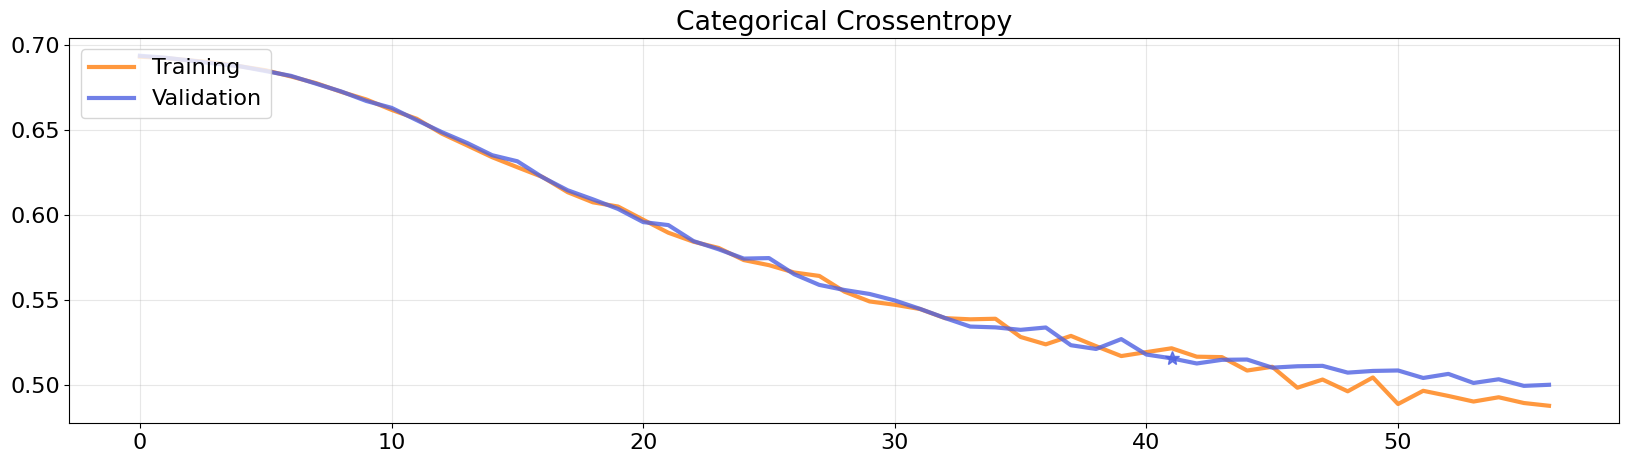

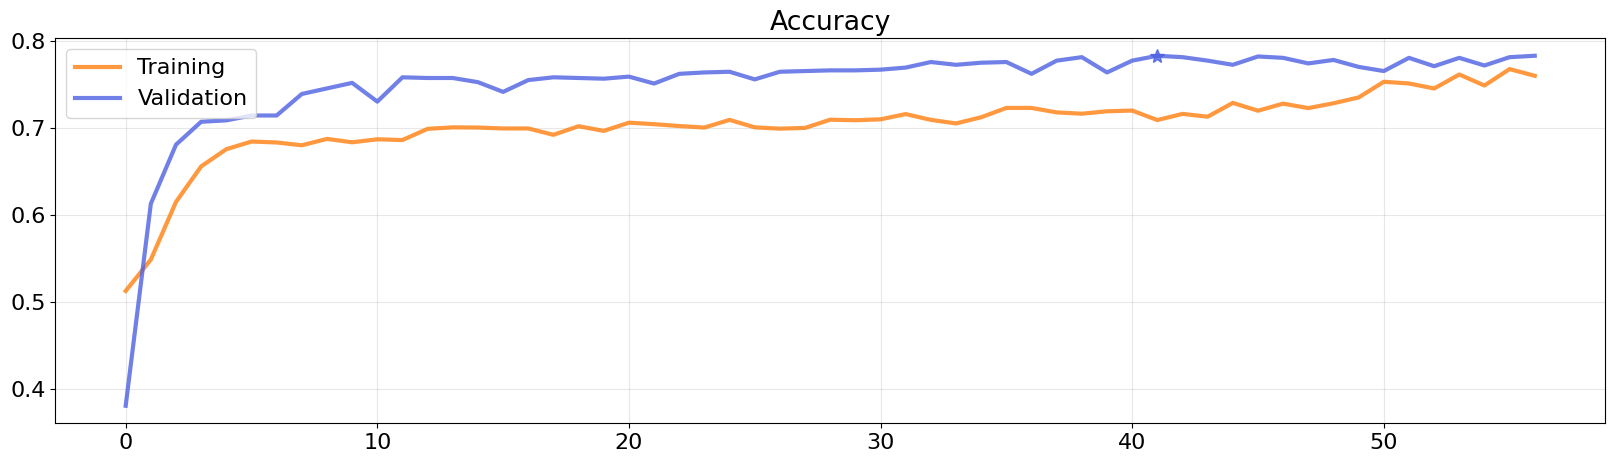

In [ ]:
plot_loss_accuracy_trend(Xception_history,metrics='val_accuracy')

Accuracy: 0.7834
Precision: 0.7702
Recall: 0.7725
F1: 0.7712


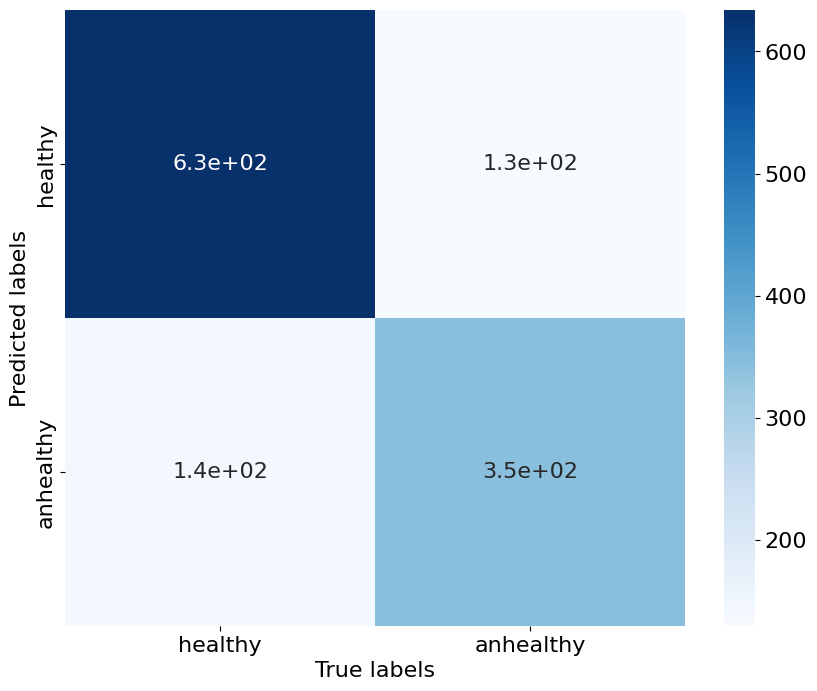

In [ ]:
(Xception_acc,Xception_pre,Xception_rec,Xception_f1)=show_metrics(Xception,X_val,y_val,preprocess_input)

In [ ]:
Xception.save('Xception')

In [ ]:
del Xception

### Fine tuning

In [ ]:
from tensorflow.keras.applications.xception import preprocess_input
Xception_ft = tfk.models.load_model('Xception')
Xception_ft.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 258   

In [ ]:
string_model='xception'
Xception_ft.get_layer(string_model).trainable = True #we set all the layers of the conv part to trainable
for i, layer in enumerate(Xception_ft.get_layer(string_model).layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv1_bn True
3 block1_conv1_act True
4 block1_conv2 True
5 block1_conv2_bn True
6 block1_conv2_act True
7 block2_sepconv1 True
8 block2_sepconv1_bn True
9 block2_sepconv2_act True
10 block2_sepconv2 True
11 block2_sepconv2_bn True
12 conv2d True
13 block2_pool True
14 batch_normalization True
15 add True
16 block3_sepconv1_act True
17 block3_sepconv1 True
18 block3_sepconv1_bn True
19 block3_sepconv2_act True
20 block3_sepconv2 True
21 block3_sepconv2_bn True
22 conv2d_1 True
23 block3_pool True
24 batch_normalization_1 True
25 add_1 True
26 block4_sepconv1_act True
27 block4_sepconv1 True
28 block4_sepconv1_bn True
29 block4_sepconv2_act True
30 block4_sepconv2 True
31 block4_sepconv2_bn True
32 conv2d_2 True
33 block4_pool True
34 batch_normalization_2 True
35 add_2 True
36 block5_sepconv1_act True
37 block5_sepconv1 True
38 block5_sepconv1_bn True
39 block5_sepconv2_act True
40 block5_sepconv2 True
41 block5_sepconv2_bn True
42 block5_sep

In [ ]:
N = 129 # we optimize it to reach the right tradeoff between number of learnable parameters and capability to learn
for i, layer in enumerate(Xception_ft.get_layer(string_model).layers[:N]):
  layer.trainable=False
for i, layer in enumerate(Xception_ft.get_layer(string_model).layers):
   print(i, layer.name, layer.trainable)
Xception_ft.summary()

0 input_1 False
1 block1_conv1 False
2 block1_conv1_bn False
3 block1_conv1_act False
4 block1_conv2 False
5 block1_conv2_bn False
6 block1_conv2_act False
7 block2_sepconv1 False
8 block2_sepconv1_bn False
9 block2_sepconv2_act False
10 block2_sepconv2 False
11 block2_sepconv2_bn False
12 conv2d False
13 block2_pool False
14 batch_normalization False
15 add False
16 block3_sepconv1_act False
17 block3_sepconv1 False
18 block3_sepconv1_bn False
19 block3_sepconv2_act False
20 block3_sepconv2 False
21 block3_sepconv2_bn False
22 conv2d_1 False
23 block3_pool False
24 batch_normalization_1 False
25 add_1 False
26 block4_sepconv1_act False
27 block4_sepconv1 False
28 block4_sepconv1_bn False
29 block4_sepconv2_act False
30 block4_sepconv2 False
31 block4_sepconv2_bn False
32 conv2d_2 False
33 block4_pool False
34 batch_normalization_2 False
35 add_2 False
36 block5_sepconv1_act False
37 block5_sepconv1 False
38 block5_sepconv1_bn False
39 block5_sepconv2_act False
40 block5_sepconv2 False

In [ ]:
Xception_ft.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics='accuracy')

In [ ]:
Xception_ft_history = Xception_ft.fit(
    x = preprocess_input(X_train_2*255),
    y = y_train_2,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)]
).history

Epoch 1/200
291/291 [==============================] - 20s 49ms/step - loss: 0.6050 - accuracy: 0.6730 - val_loss: 0.6001 - val_accuracy: 0.7306
Epoch 2/200
291/291 [==============================] - 10s 35ms/step - loss: 0.5954 - accuracy: 0.6975 - val_loss: 0.5951 - val_accuracy: 0.7386
Epoch 3/200
291/291 [==============================] - 12s 41ms/step - loss: 0.5899 - accuracy: 0.7057 - val_loss: 0.5922 - val_accuracy: 0.7498
Epoch 4/200
291/291 [==============================] - 12s 42ms/step - loss: 0.5864 - accuracy: 0.7036 - val_loss: 0.5885 - val_accuracy: 0.7602
Epoch 5/200
291/291 [==============================] - 11s 36ms/step - loss: 0.5858 - accuracy: 0.7085 - val_loss: 0.5860 - val_accuracy: 0.7650
Epoch 6/200
291/291 [==============================] - 10s 34ms/step - loss: 0.5847 - accuracy: 0.7038 - val_loss: 0.5827 - val_accuracy: 0.7770
Epoch 7/200
291/291 [==============================] - 10s 34ms/step - loss: 0.5775 - accuracy: 0.7259 - val_loss: 0.5823 - val_ac

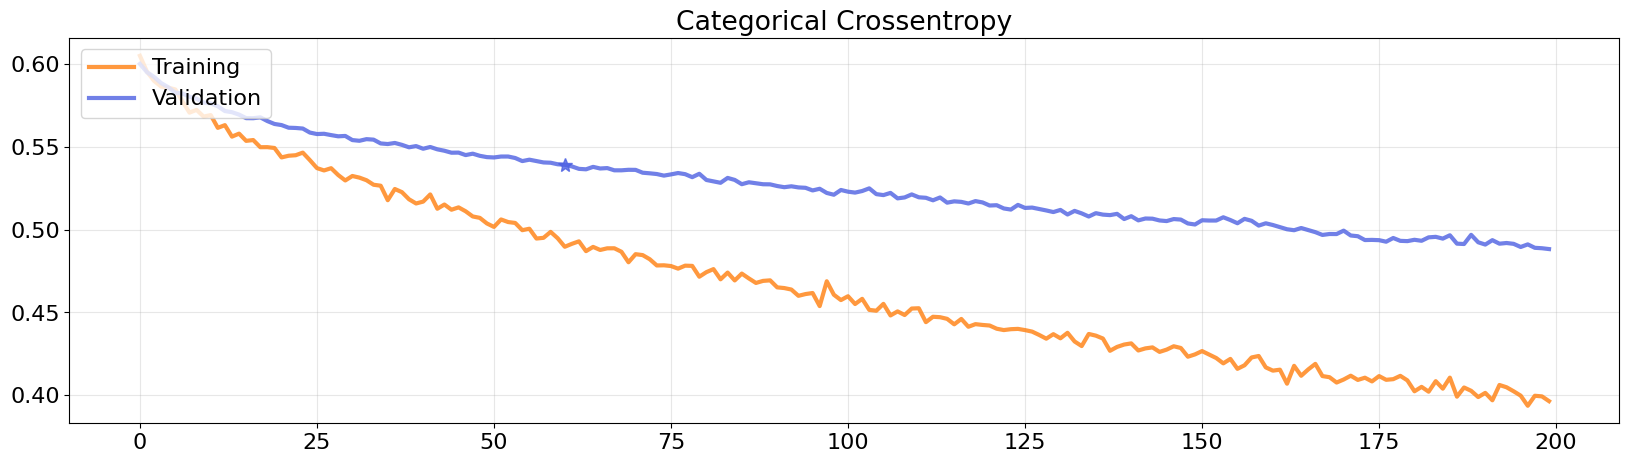

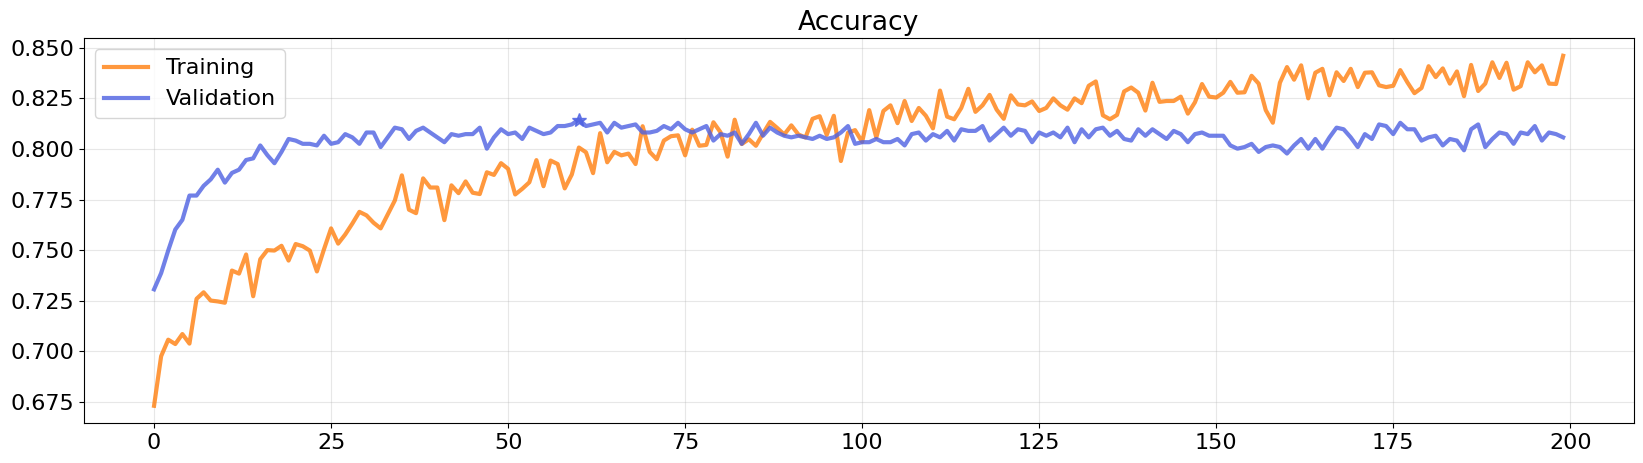

In [ ]:
plot_loss_accuracy_trend(Xception_ft_history,metrics='val_loss')

Accuracy: 0.8058
Precision: 0.794
Recall: 0.7942
F1: 0.7941


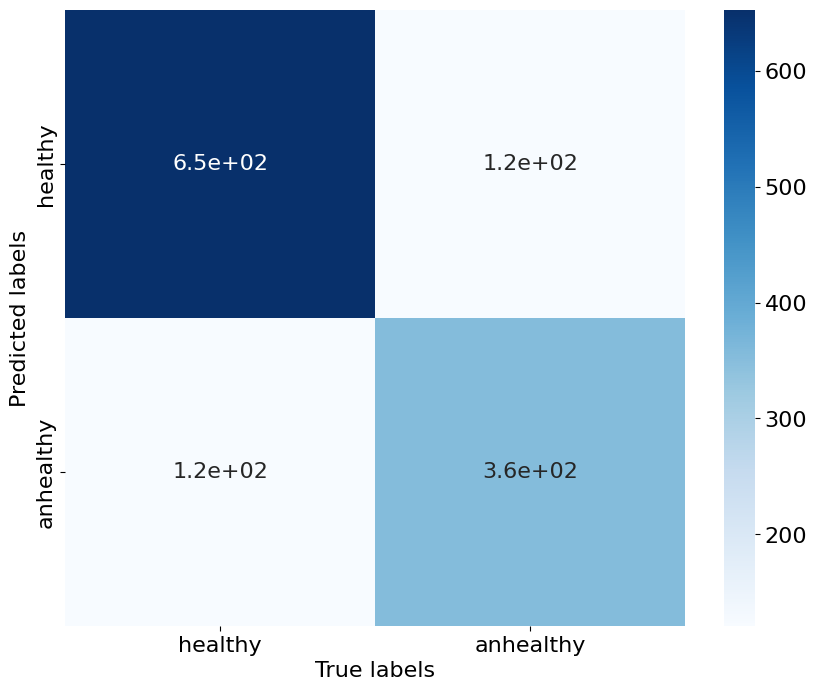

In [ ]:
(Xception_ft_acc,Xception_ft_pre,Xception_ft_rec,Xception_ft_f1)=show_metrics(Xception_ft,X_val,y_val,preprocess_input)

In [ ]:
Xception_ft.save('Xception_ft')

In [ ]:
del Xception_ft

## MobileNet

### Transfer learning + MLP

In [ ]:
from tensorflow.keras.applications.mobilenet import preprocess_input

model = tfk.applications.MobileNetV2(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet", #you select the dataset to use for training weights
    pooling='avg',
)
tfk.utils.plot_model(model, show_shapes=True)
model.trainable = False


inputs = tfk.Input(shape=(96, 96, 3))
x = model(inputs)

x = tfkl.Dense(64, activation='relu')(x)
x = tfkl.Dropout(rate=0.3,seed = seed)(x) # dropout to prevent overfitting

x = tfkl.Dense(64, activation='relu')(x)
x = tfkl.Dropout(rate=0.3,seed = seed)(x) # dropout to prevent overfitting

x = tfkl.Dense(32, activation='relu')(x)
x = tfkl.Dropout(rate=0.3,seed = seed)(x) # dropout to prevent overfitting

outputs = tfkl.Dense(2, activation='softmax')(x)

# Create a Model connecting input and output
MobileNet = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
MobileNet.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate = 0.0001), metrics=['accuracy'])

# Display model summary
MobileNet.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 1280)              2257984   
 ional)                                                          
                                                                 
 dense_6 (Dense)             (None, 64)                81984     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                             

In [ ]:
# Train the model
MobileNet_history = MobileNet.fit(
    x = preprocess_input(X_train*255), # we apply the preprcessing od Xception architecture
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True),
    tfk.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=8,factor=0.5,mode='min', min_lr=1e-5)]
).history
# using a GridSearch approach we optimized the values of the LR in the optimizer, the patiences and factor

Epoch 1/200
291/291 [==============================] - 13s 21ms/step - loss: 0.6835 - accuracy: 0.5982 - val_loss: 0.6013 - val_accuracy: 0.6803 - lr: 1.0000e-04
Epoch 2/200
291/291 [==============================] - 4s 13ms/step - loss: 0.5445 - accuracy: 0.7109 - val_loss: 0.5215 - val_accuracy: 0.7482 - lr: 1.0000e-04
Epoch 3/200
291/291 [==============================] - 4s 13ms/step - loss: 0.4817 - accuracy: 0.7577 - val_loss: 0.4828 - val_accuracy: 0.7650 - lr: 1.0000e-04
Epoch 4/200
291/291 [==============================] - 5s 17ms/step - loss: 0.4345 - accuracy: 0.7943 - val_loss: 0.4637 - val_accuracy: 0.7746 - lr: 1.0000e-04
Epoch 5/200
291/291 [==============================] - 4s 14ms/step - loss: 0.4119 - accuracy: 0.8074 - val_loss: 0.4513 - val_accuracy: 0.7786 - lr: 1.0000e-04
Epoch 6/200
291/291 [==============================] - 4s 13ms/step - loss: 0.3880 - accuracy: 0.8261 - val_loss: 0.4362 - val_accuracy: 0.7914 - lr: 1.0000e-04
Epoch 7/200
291/291 [============

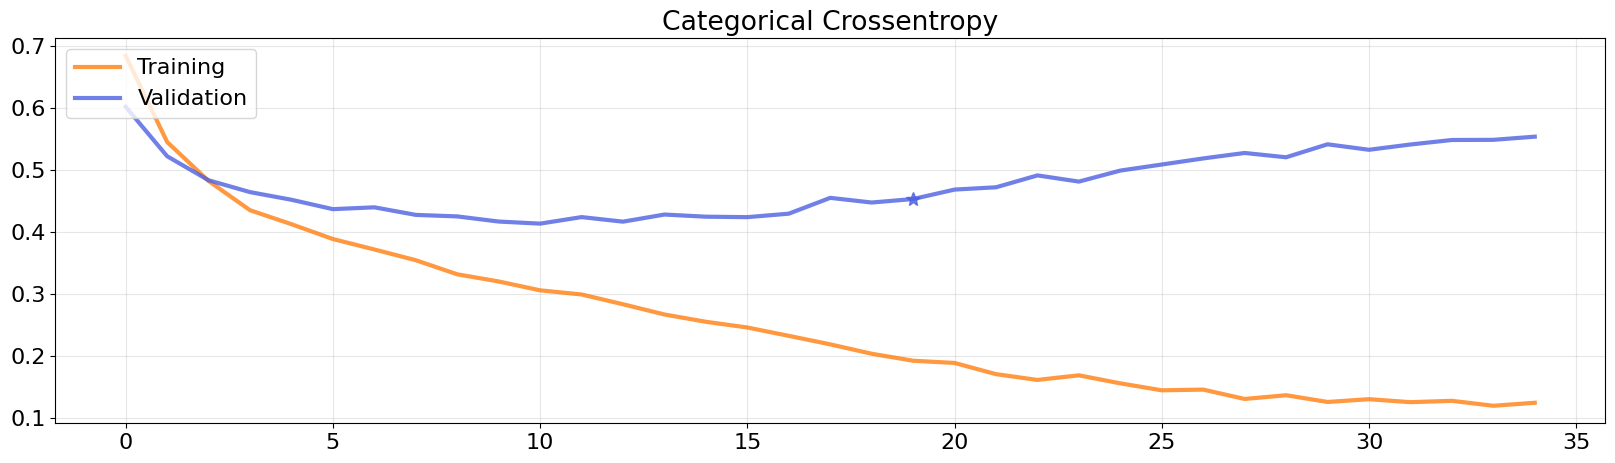

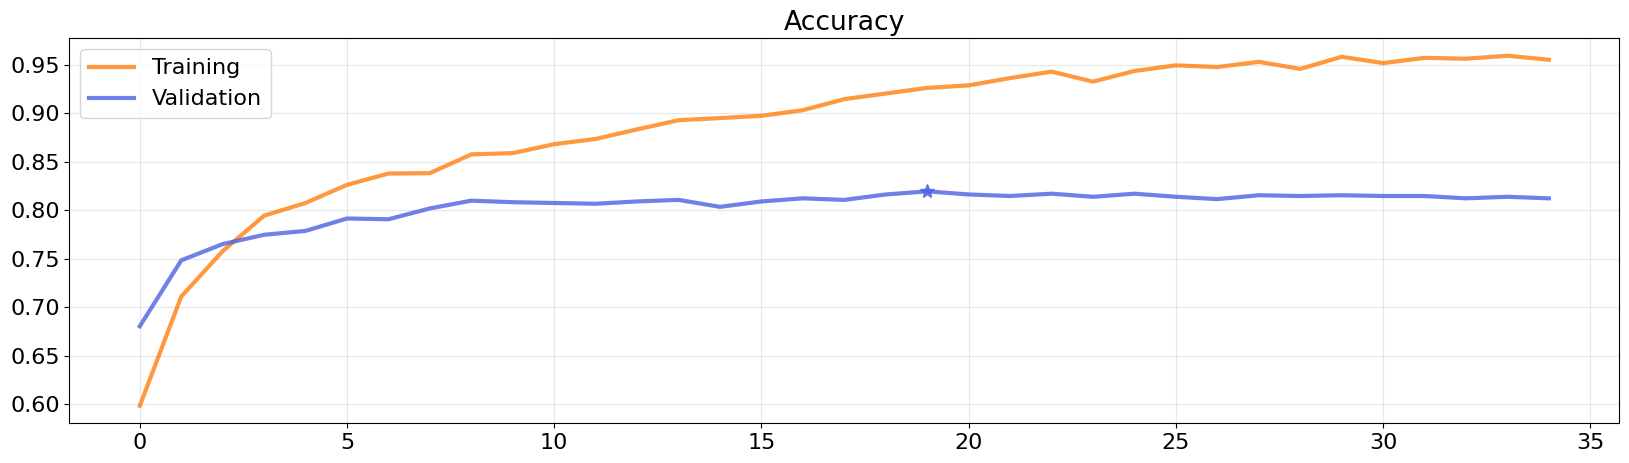

In [ ]:
plot_loss_accuracy_trend(MobileNet_history,metrics='val_accuracy')

Accuracy: 0.8193
Precision: 0.8156
Recall: 0.795
F1: 0.8025


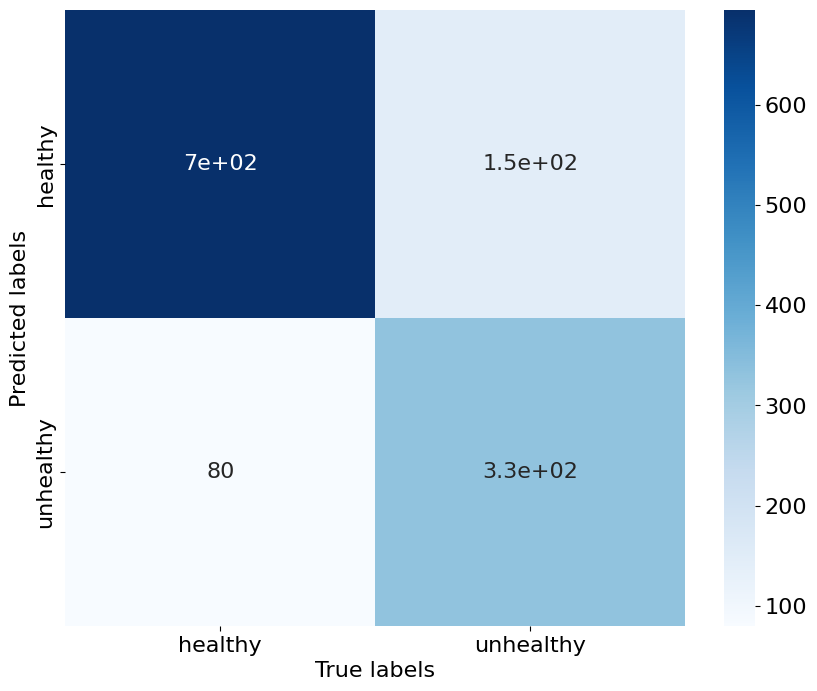

In [ ]:
(MobileNet_acc,MobileNet_pre,MobileNet_rec,MobileNet_f1)=show_metrics(MobileNet,X_val,y_val,preprocess_input)

In [ ]:
MobileNet.save('MobileNet')

In [ ]:
del MobileNet

### Fine tuning


In [ ]:
from tensorflow.keras.applications.mobilenet import preprocess_input
MobileNet_ft = tfk.models.load_model('MobileNet')
MobileNet_ft.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 1280)              2257984   
 ional)                                                          
                                                                 
 dense_6 (Dense)             (None, 64)                81984     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                             

In [ ]:
string_model='mobilenetv2_1.00_96'
MobileNet_ft.get_layer(string_model).trainable = True #we set all the layers of the conv part to trainable
for i, layer in enumerate(MobileNet_ft.get_layer(string_model).layers):
   print(i, layer.name, layer.trainable)

0 input_5 True
1 Conv1 True
2 bn_Conv1 True
3 Conv1_relu True
4 expanded_conv_depthwise True
5 expanded_conv_depthwise_BN True
6 expanded_conv_depthwise_relu True
7 expanded_conv_project True
8 expanded_conv_project_BN True
9 block_1_expand True
10 block_1_expand_BN True
11 block_1_expand_relu True
12 block_1_pad True
13 block_1_depthwise True
14 block_1_depthwise_BN True
15 block_1_depthwise_relu True
16 block_1_project True
17 block_1_project_BN True
18 block_2_expand True
19 block_2_expand_BN True
20 block_2_expand_relu True
21 block_2_depthwise True
22 block_2_depthwise_BN True
23 block_2_depthwise_relu True
24 block_2_project True
25 block_2_project_BN True
26 block_2_add True
27 block_3_expand True
28 block_3_expand_BN True
29 block_3_expand_relu True
30 block_3_pad True
31 block_3_depthwise True
32 block_3_depthwise_BN True
33 block_3_depthwise_relu True
34 block_3_project True
35 block_3_project_BN True
36 block_4_expand True
37 block_4_expand_BN True
38 block_4_expand_relu Tru

In [ ]:
N = 133 # we optimize it to reach the right tradeoff between number of learnable parameters and capability to learn
for i, layer in enumerate(MobileNet_ft.get_layer(string_model).layers[:N]):
  layer.trainable=False
for i, layer in enumerate(MobileNet_ft.get_layer(string_model).layers):
   print(i, layer.name, layer.trainable)
MobileNet_ft.summary()

0 input_5 False
1 Conv1 False
2 bn_Conv1 False
3 Conv1_relu False
4 expanded_conv_depthwise False
5 expanded_conv_depthwise_BN False
6 expanded_conv_depthwise_relu False
7 expanded_conv_project False
8 expanded_conv_project_BN False
9 block_1_expand False
10 block_1_expand_BN False
11 block_1_expand_relu False
12 block_1_pad False
13 block_1_depthwise False
14 block_1_depthwise_BN False
15 block_1_depthwise_relu False
16 block_1_project False
17 block_1_project_BN False
18 block_2_expand False
19 block_2_expand_BN False
20 block_2_expand_relu False
21 block_2_depthwise False
22 block_2_depthwise_BN False
23 block_2_depthwise_relu False
24 block_2_project False
25 block_2_project_BN False
26 block_2_add False
27 block_3_expand False
28 block_3_expand_BN False
29 block_3_expand_relu False
30 block_3_pad False
31 block_3_depthwise False
32 block_3_depthwise_BN False
33 block_3_depthwise_relu False
34 block_3_project False
35 block_3_project_BN False
36 block_4_expand False
37 block_4_expa

In [ ]:
MobileNet_ft.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics='accuracy')

In [ ]:
MobileNet_ft_history = MobileNet_ft.fit(
    x = preprocess_input(X_train_2*255),
    y = y_train_2,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)]
).history

Epoch 1/200
291/291 [==============================] - 23s 28ms/step - loss: 0.5715 - accuracy: 0.7371 - val_loss: 0.4161 - val_accuracy: 0.8082
Epoch 2/200
291/291 [==============================] - 5s 17ms/step - loss: 0.4492 - accuracy: 0.7988 - val_loss: 0.4194 - val_accuracy: 0.8034
Epoch 3/200
291/291 [==============================] - 6s 22ms/step - loss: 0.4059 - accuracy: 0.8196 - val_loss: 0.4238 - val_accuracy: 0.8010
Epoch 4/200
291/291 [==============================] - 6s 20ms/step - loss: 0.3781 - accuracy: 0.8351 - val_loss: 0.4249 - val_accuracy: 0.8010
Epoch 5/200
291/291 [==============================] - 5s 17ms/step - loss: 0.3390 - accuracy: 0.8579 - val_loss: 0.4302 - val_accuracy: 0.8082
Epoch 6/200
291/291 [==============================] - 8s 28ms/step - loss: 0.3282 - accuracy: 0.8687 - val_loss: 0.4243 - val_accuracy: 0.8098
Epoch 7/200
291/291 [==============================] - 6s 20ms/step - loss: 0.3003 - accuracy: 0.8801 - val_loss: 0.4253 - val_accuracy

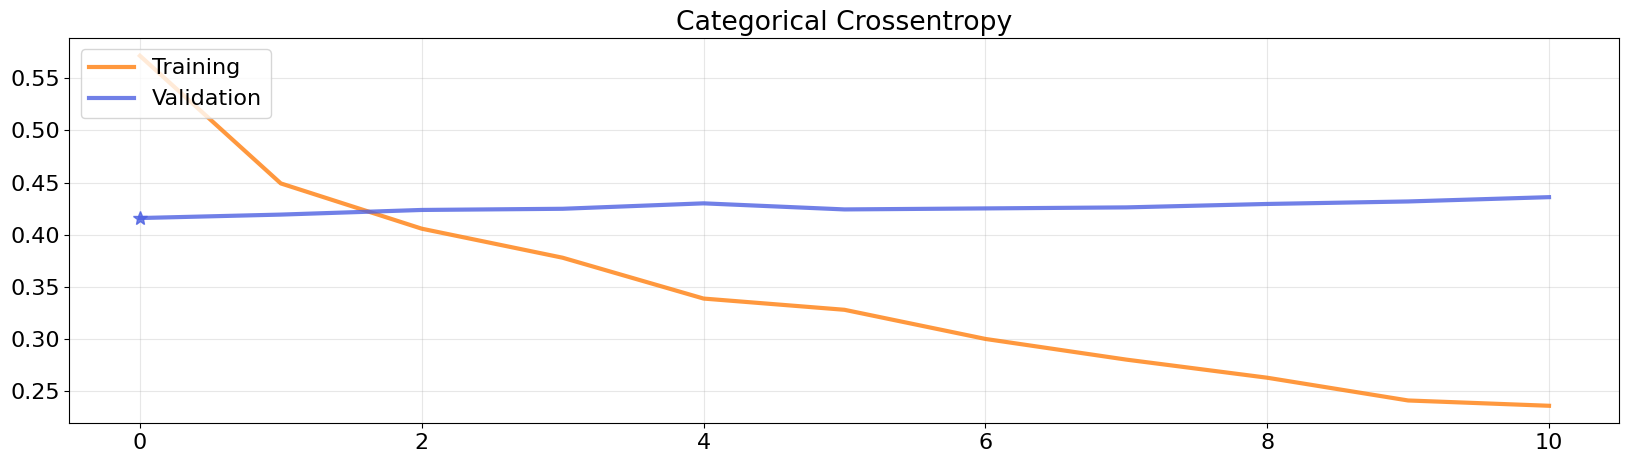

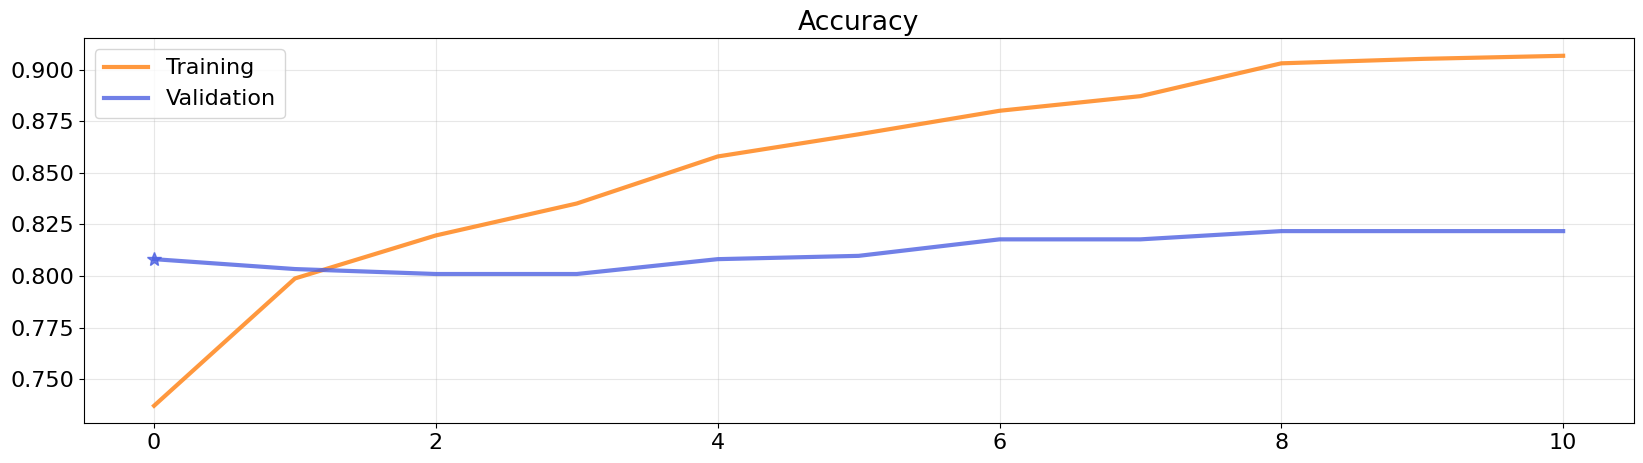

In [ ]:
plot_loss_accuracy_trend(MobileNet_ft_history,metrics='val_loss')

Accuracy: 0.8082
Precision: 0.7983
Recall: 0.7909
F1: 0.7941


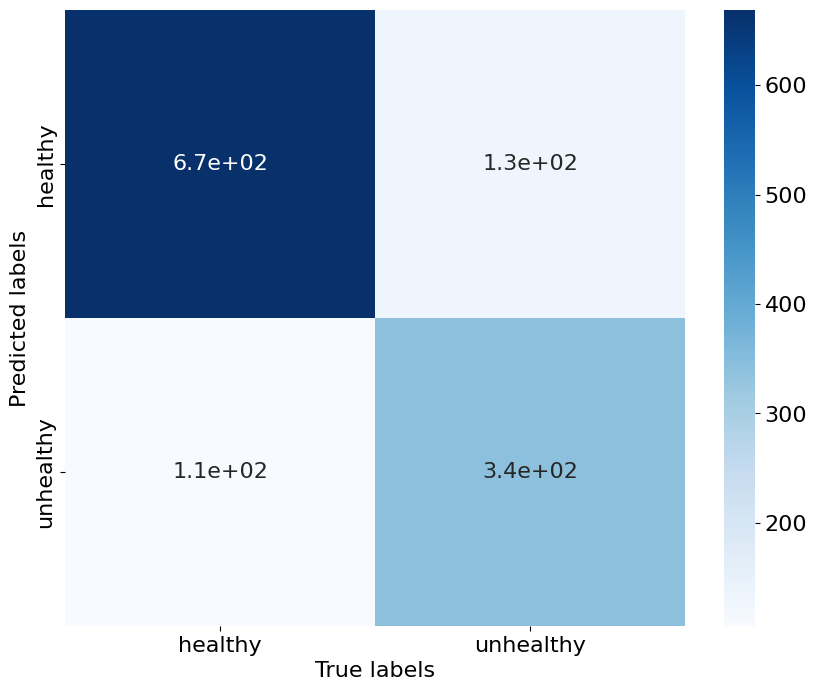

In [ ]:
(MobileNet_ft_acc,MobileNet_ft_pre,MobileNet_ft_rec,MobileNet_ft_f1)=show_metrics(MobileNet_ft,X_val,y_val,preprocess_input)

In [ ]:
MobileNet_ft.save('MobileNet_ft')

In [ ]:
del MobileNet_ft

##ResNet50
For what concerns ResNet50 architecture, we firstly trained the original network concatenated to a dense layer with 2 neurons and softmax activation function. Then, to increase the performance we have inserted one dense layer combined with a dropout layer. The number of the hyyperparameters of these layers (number of neurons and rate of dropout) have been optimized through a grid search. To prevent overfitting we tuned the learning rate and we implemented the schedule of the learning rate. The network seemed unable to learn in depth the carachteristics of the images. Therefore, to increase the performance, we performed fine tuning. The resulting model is not as good as other architecture

###Transfer learning+MLP

In [ ]:
from tensorflow.keras.applications.resnet import preprocess_input

LR=0.0003
fattore_riduzione=0.4
epochs_LR_reg=7
drop=0.3
num_layer=100
epochs_early_stopping=10

ResNet50 = tfk.applications.ResNet50(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet", #you select the dataset to use for training weights
    pooling='avg',
)
tfk.utils.plot_model(ResNet50, show_shapes=True)
ResNet50.trainable = False
inputs = tfk.Input(shape=(96, 96, 3))
x = ResNet50(inputs)
x=tfkl.Dropout(rate=drop,seed=seed)(x)
x=tfkl.Dense(num_layer, activation='relu')(x) #####
outputs = tfkl.Dense(2, activation='softmax')(x)
ResNet50 = tfk.Model(inputs=inputs, outputs=outputs, name='model')

94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
ResNet50.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=LR), metrics=['accuracy'])
ResNet50.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 100)               204900    
                                                                 
 dense_1 (Dense)             (None, 2)                 202       
                                                                 
Total params: 23792814 (90.76 MB)
Trainable params: 205102 (801.18 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [ ]:
ResNet50_history = ResNet50.fit(
    x = preprocess_input(X_train*255),
    y = y_train,
    batch_size = 16,
    epochs = 500,
    validation_data = (preprocess_input(X_val*255), y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=epochs_early_stopping, restore_best_weights=True),
    tfk.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=epochs_LR_reg,factor=fattore_riduzione,mode='min', min_lr=1e-5)]
).history

Epoch 1/500
291/291 [==============================] - 15s 36ms/step - loss: 0.5323 - accuracy: 0.7463 - val_loss: 0.4729 - val_accuracy: 0.7842 - lr: 3.0000e-04
Epoch 2/500
291/291 [==============================] - 8s 29ms/step - loss: 0.3961 - accuracy: 0.8289 - val_loss: 0.4261 - val_accuracy: 0.8161 - lr: 3.0000e-04
Epoch 3/500
291/291 [==============================] - 9s 30ms/step - loss: 0.3604 - accuracy: 0.8383 - val_loss: 0.4727 - val_accuracy: 0.7762 - lr: 3.0000e-04
Epoch 4/500
291/291 [==============================] - 7s 25ms/step - loss: 0.3402 - accuracy: 0.8476 - val_loss: 0.4240 - val_accuracy: 0.8193 - lr: 3.0000e-04
Epoch 5/500
291/291 [==============================] - 7s 26ms/step - loss: 0.3156 - accuracy: 0.8633 - val_loss: 0.4203 - val_accuracy: 0.8249 - lr: 3.0000e-04
Epoch 6/500
291/291 [==============================] - 8s 28ms/step - loss: 0.2965 - accuracy: 0.8695 - val_loss: 0.4406 - val_accuracy: 0.8026 - lr: 3.0000e-04
Epoch 7/500
291/291 [============

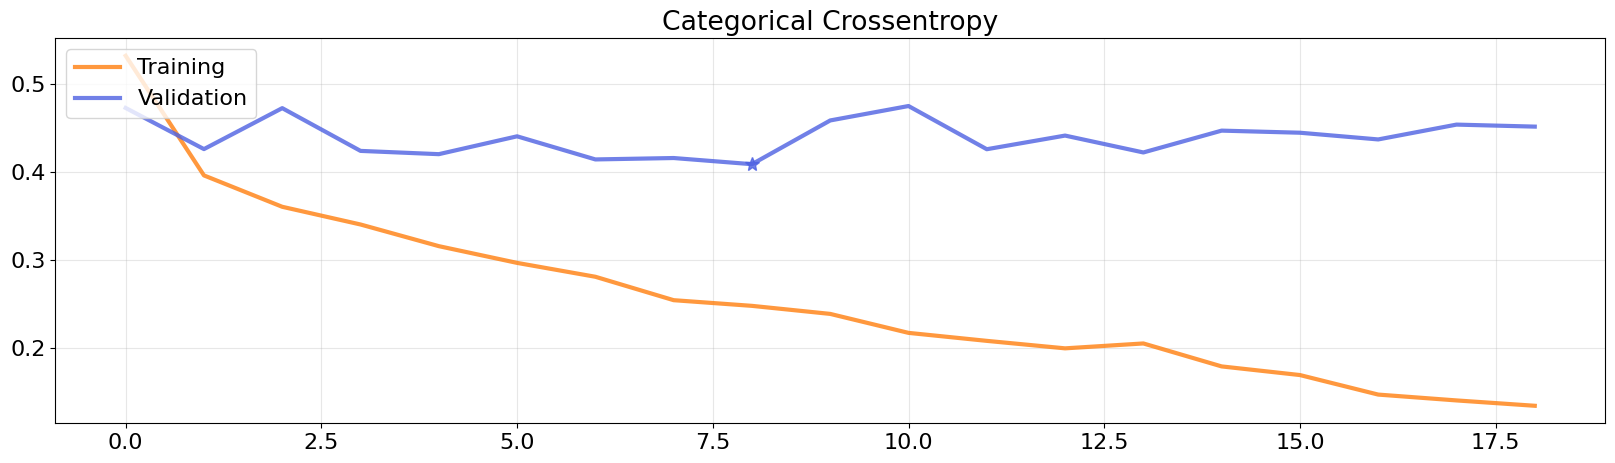

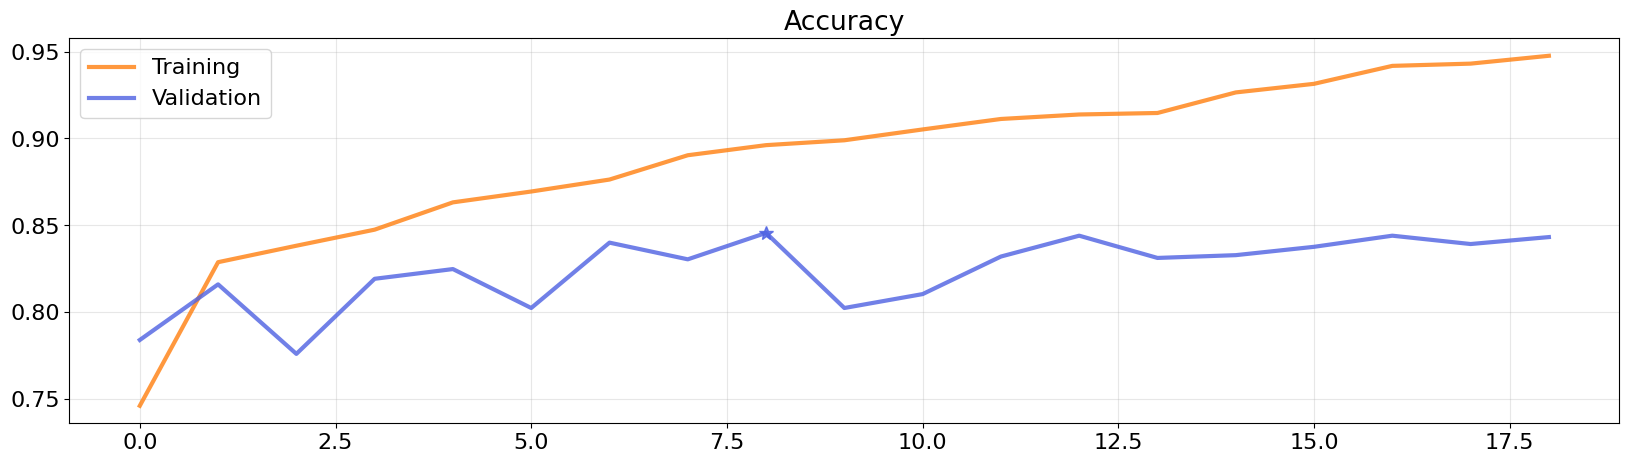

In [ ]:
plot_loss_accuracy_trend(ResNet50_history,metrics='val_accuracy')

In [ ]:
ResNet50.save('ResNet50')

In [ ]:
del ResNet50

###Fine tuning on ResNet50 using unbalanced data

In [ ]:
from tensorflow.keras.applications.resnet import preprocess_input
ResNet50_ft = tfk.models.load_model('ResNet50')
ResNet50_ft.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 100)               204900    
                                                                 
 dense_1 (Dense)             (None, 2)                 202       
                                                                 
Total params: 23792814 (90.76 MB)
Trainable params: 205102 (801.18 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [ ]:
string_model='resnet50'
ResNet50_ft.get_layer(string_model).trainable = True #we set all the layers of the conv part to trainable
for i, layer in enumerate(ResNet50_ft.get_layer(string_model).layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 conv1_pad True
2 conv1_conv True
3 conv1_bn True
4 conv1_relu True
5 pool1_pad True
6 pool1_pool True
7 conv2_block1_1_conv True
8 conv2_block1_1_bn True
9 conv2_block1_1_relu True
10 conv2_block1_2_conv True
11 conv2_block1_2_bn True
12 conv2_block1_2_relu True
13 conv2_block1_0_conv True
14 conv2_block1_3_conv True
15 conv2_block1_0_bn True
16 conv2_block1_3_bn True
17 conv2_block1_add True
18 conv2_block1_out True
19 conv2_block2_1_conv True
20 conv2_block2_1_bn True
21 conv2_block2_1_relu True
22 conv2_block2_2_conv True
23 conv2_block2_2_bn True
24 conv2_block2_2_relu True
25 conv2_block2_3_conv True
26 conv2_block2_3_bn True
27 conv2_block2_add True
28 conv2_block2_out True
29 conv2_block3_1_conv True
30 conv2_block3_1_bn True
31 conv2_block3_1_relu True
32 conv2_block3_2_conv True
33 conv2_block3_2_bn True
34 conv2_block3_2_relu True
35 conv2_block3_3_conv True
36 conv2_block3_3_bn True
37 conv2_block3_add True
38 conv2_block3_out True
39 conv3_block1_1_conv Tru

In [ ]:
N = 171
for i, layer in enumerate(ResNet50_ft.get_layer(string_model).layers[:N]):
  layer.trainable=False
for i, layer in enumerate(ResNet50_ft.get_layer(string_model).layers):
   print(i, layer.name, layer.trainable)
ResNet50_ft.summary()

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

In [ ]:
ResNet50_ft.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

In [ ]:
ResNet50_ft_history = ResNet50_ft.fit(
    x = preprocess_input(X_train_2*255),
    y = y_train_2,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

Epoch 1/200
291/291 [==============================] - 28s 45ms/step - loss: 0.3046 - accuracy: 0.8811 - val_loss: 0.4274 - val_accuracy: 0.8305
Epoch 2/200
291/291 [==============================] - 7s 23ms/step - loss: 0.2133 - accuracy: 0.9220 - val_loss: 0.4464 - val_accuracy: 0.8153
Epoch 3/200
291/291 [==============================] - 8s 28ms/step - loss: 0.1771 - accuracy: 0.9374 - val_loss: 0.4701 - val_accuracy: 0.8185
Epoch 4/200
291/291 [==============================] - 7s 24ms/step - loss: 0.1455 - accuracy: 0.9501 - val_loss: 0.5106 - val_accuracy: 0.8153
Epoch 5/200
291/291 [==============================] - 9s 31ms/step - loss: 0.1159 - accuracy: 0.9598 - val_loss: 0.5389 - val_accuracy: 0.8058
Epoch 6/200
291/291 [==============================] - 7s 24ms/step - loss: 0.0972 - accuracy: 0.9686 - val_loss: 0.5715 - val_accuracy: 0.8305
Epoch 7/200
291/291 [==============================] - 8s 27ms/step - loss: 0.0783 - accuracy: 0.9791 - val_loss: 0.5515 - val_accuracy

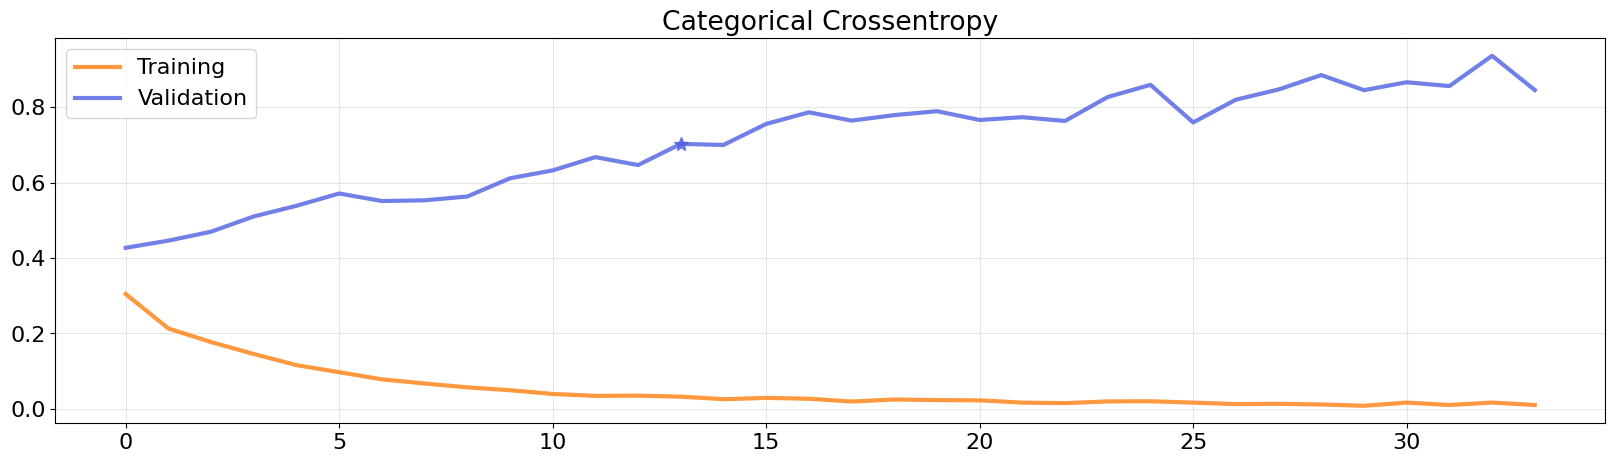

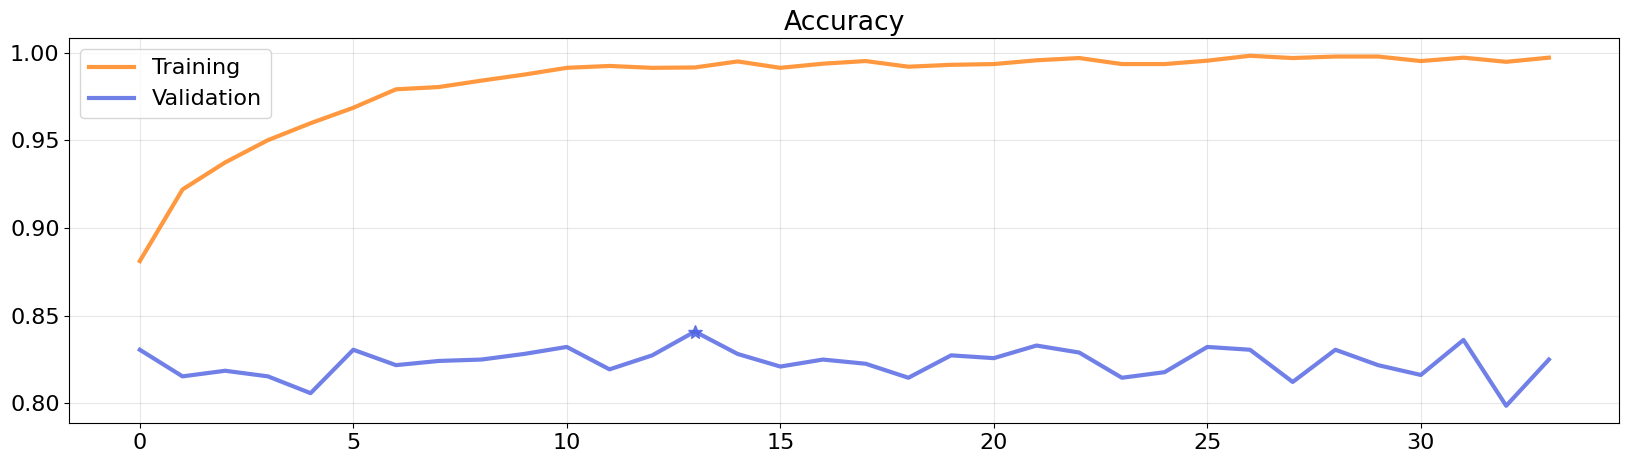

In [ ]:
plot_loss_accuracy_trend(ResNet50_ft_history,metrics='val_accuracy')

Accuracy: 0.8409
Precision: 0.838
Recall: 0.8201
F1: 0.8271


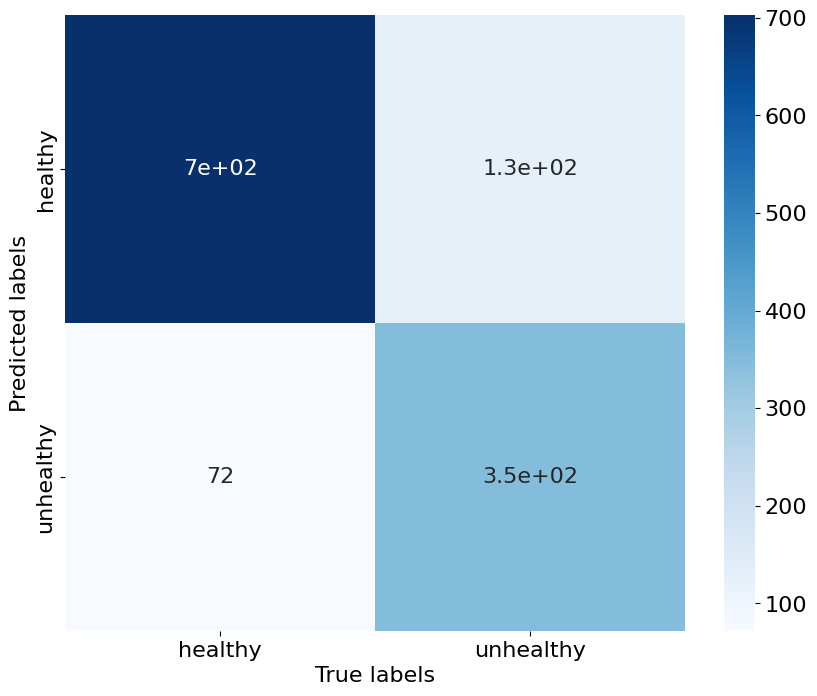

In [ ]:
(ResNet50_ft_acc,ResNet50_ft_pre,ResNet50_ft_rec,ResNet50_ft_f1)=show_metrics(ResNet50_ft,X_val,y_val,preprocess_input)

In [ ]:
ResNet50_ft.save('ResNet50_ft')

In [ ]:
del ResNet50_ft

##EfficientNet B3

### Transfer learning + MLP

In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input

model = tf.keras.applications.EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(96,96,3),
    pooling=None,
    classes=1000,
    classifier_activation="softmax"
)
tfk.utils.plot_model(model, show_shapes=True)
model.trainable = False #we don't want to train the model -> we freeze the pre-trained weights

inputs = tfk.Input(shape=(96, 96, 3))

x = model(inputs)

x = tfkl.GlobalAveragePooling2D(name='gap')(x)
x = tfkl.Dropout(rate=0.3,seed = seed)(x)

x = tfkl.Dense(64, activation='relu')(x)
x = tfkl.Dropout(rate=0.3,seed = seed)(x)

x = tfkl.Dense(64, activation='relu')(x)
x = tfkl.Dropout(rate=0.3,seed = seed)(x)

x = tfkl.Dense(32, activation='relu')(x)
x = tfkl.Dropout(rate=0.3,seed = seed)(x)

outputs = tfkl.Dense(2, activation='softmax')(x)

# Create a Model connecting input and output
EfficientNet_B3 = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
EfficientNet_B3.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate = 0.0001), metrics=['accuracy'])

# Display model summary
EfficientNet_B3.summary()


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.769739 to fit

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetb3 (Functional  (None, 3, 3, 1536)        10783535  
 )                                                               
                                                                 
 gap (GlobalAveragePooling2  (None, 1536)              0         
 D)                                                              
                                                                 
 dropout_20 (Dropout)        (None, 1536)              0         
                                                                 
 dense_22 (Dense)            (None, 64)                98368     
                                               

In [ ]:
# Train the model
EfficientNet_B3_history = EfficientNet_B3.fit(
    x = preprocess_input(X_train*255), # we apply the preprcessing od Xception architecture
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True),
                 tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.8, mode='min',min_lr=1e-7)]
).history
# using a GridSearch approach we optimized the values of the LR in the optimizer, the patiences and factor

Epoch 1/200
291/291 [==============================] - 25s 43ms/step - loss: 0.6849 - accuracy: 0.5647 - val_loss: 0.6152 - val_accuracy: 0.7130 - lr: 1.0000e-04
Epoch 2/200
291/291 [==============================] - 8s 29ms/step - loss: 0.6062 - accuracy: 0.6758 - val_loss: 0.5284 - val_accuracy: 0.7586 - lr: 1.0000e-04
Epoch 3/200
291/291 [==============================] - 10s 35ms/step - loss: 0.5511 - accuracy: 0.7188 - val_loss: 0.4878 - val_accuracy: 0.7818 - lr: 1.0000e-04
Epoch 4/200
291/291 [==============================] - 7s 24ms/step - loss: 0.5205 - accuracy: 0.7438 - val_loss: 0.4734 - val_accuracy: 0.7842 - lr: 1.0000e-04
Epoch 5/200
291/291 [==============================] - 11s 36ms/step - loss: 0.4886 - accuracy: 0.7657 - val_loss: 0.4624 - val_accuracy: 0.7874 - lr: 1.0000e-04
Epoch 6/200
291/291 [==============================] - 9s 30ms/step - loss: 0.4788 - accuracy: 0.7721 - val_loss: 0.4619 - val_accuracy: 0.7834 - lr: 1.0000e-04
Epoch 7/200
291/291 [==========

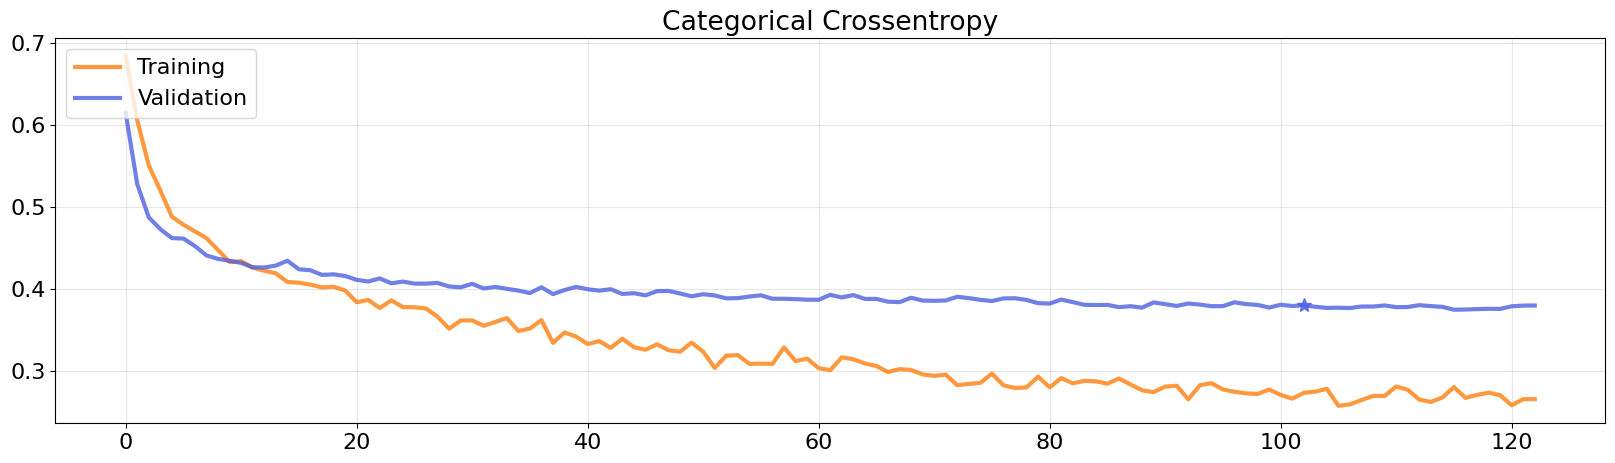

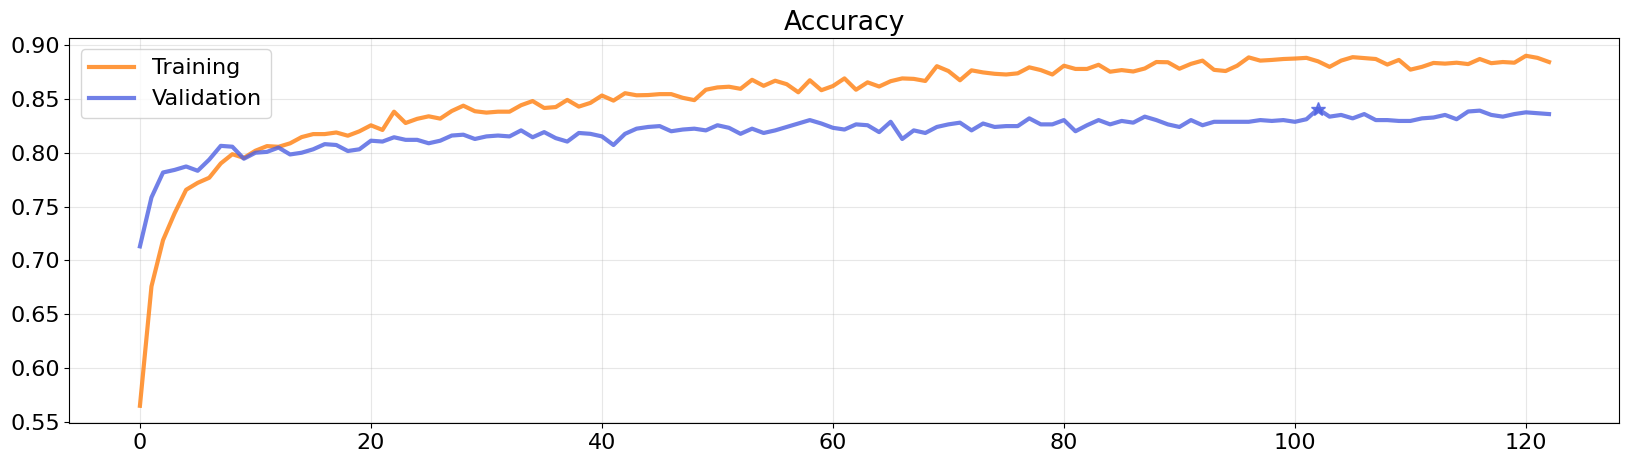

In [ ]:
plot_loss_accuracy_trend(EfficientNet_B3_history,metrics='val_accuracy')

Accuracy: 0.8409
Precision: 0.8384
Recall: 0.8197
F1: 0.8269


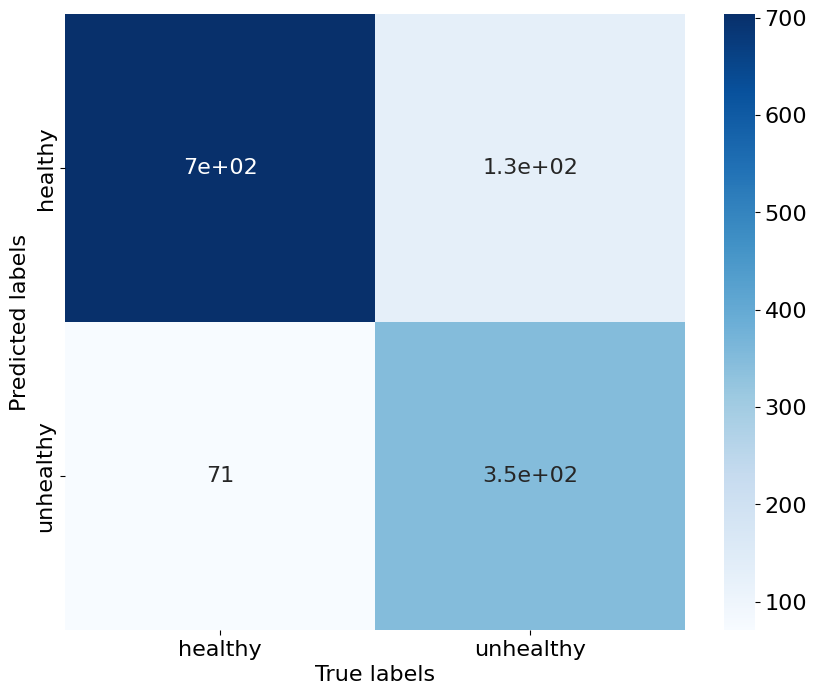

In [ ]:
(EfficientNet_B3_acc,EfficientNet_B3_pre,EfficientNet_B3_rec,EfficientNet_B3_f1)=show_metrics(EfficientNet_B3,X_val,y_val,preprocess_input)

In [ ]:
EfficientNet_B3.save('EfficientNet_B3')

In [ ]:
del EfficientNet_B3

### Fine tuning

In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input

EfficientNet_B3_ft = tfk.models.load_model('EfficientNet_B3')
EfficientNet_B3_ft.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetb3 (Functional  (None, 3, 3, 1536)        10783535  
 )                                                               
                                                                 
 gap (GlobalAveragePooling2  (None, 1536)              0         
 D)                                                              
                                                                 
 dropout_20 (Dropout)        (None, 1536)              0         
                                                                 
 dense_22 (Dense)            (None, 64)                98368     
                                                                 
 dropout_21 (Dropout)        (None, 64)                0     

In [ ]:
string_model='efficientnetb3'
EfficientNet_B3_ft.get_layer(string_model).trainable = True #we set all the layers of the conv part to trainable
for i, layer in enumerate(EfficientNet_B3_ft.get_layer(string_model).layers):
   print(i, layer.name, layer.trainable)

0 input_16 True
1 rescaling_10 True
2 normalization_5 True
3 rescaling_11 True
4 stem_conv_pad True
5 stem_conv True
6 stem_bn True
7 stem_activation True
8 block1a_dwconv True
9 block1a_bn True
10 block1a_activation True
11 block1a_se_squeeze True
12 block1a_se_reshape True
13 block1a_se_reduce True
14 block1a_se_expand True
15 block1a_se_excite True
16 block1a_project_conv True
17 block1a_project_bn True
18 block1b_dwconv True
19 block1b_bn True
20 block1b_activation True
21 block1b_se_squeeze True
22 block1b_se_reshape True
23 block1b_se_reduce True
24 block1b_se_expand True
25 block1b_se_excite True
26 block1b_project_conv True
27 block1b_project_bn True
28 block1b_drop True
29 block1b_add True
30 block2a_expand_conv True
31 block2a_expand_bn True
32 block2a_expand_activation True
33 block2a_dwconv_pad True
34 block2a_dwconv True
35 block2a_bn True
36 block2a_activation True
37 block2a_se_squeeze True
38 block2a_se_reshape True
39 block2a_se_reduce True
40 block2a_se_expand True
41

In [ ]:
N = 382 # we optimize it to reach the right tradeoff between number of learnable parameters and capability to learn
for i, layer in enumerate(EfficientNet_B3_ft.get_layer(string_model).layers[:N]):
  layer.trainable=False
for i, layer in enumerate(EfficientNet_B3_ft.get_layer(string_model).layers):
   print(i, layer.name, layer.trainable)
EfficientNet_B3_ft.summary()

0 input_16 False
1 rescaling_10 False
2 normalization_5 False
3 rescaling_11 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block1b_dwconv False
19 block1b_bn False
20 block1b_activation False
21 block1b_se_squeeze False
22 block1b_se_reshape False
23 block1b_se_reduce False
24 block1b_se_expand False
25 block1b_se_excite False
26 block1b_project_conv False
27 block1b_project_bn False
28 block1b_drop False
29 block1b_add False
30 block2a_expand_conv False
31 block2a_expand_bn False
32 block2a_expand_activation False
33 block2a_dwconv_pad False
34 block2a_dwconv False
35 block2a_bn False
36 block2a_activation False
37 block2a_se_squeeze False
38 block2a_se_reshape False
39 block2a_se_r

In [ ]:
EfficientNet_B3_ft.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics='accuracy')

In [ ]:
EfficientNet_B3_ft_history = EfficientNet_B3_ft.fit(
    x = preprocess_input(X_train_2*255),
    y = y_train_2,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=16, restore_best_weights=True),
                 tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.8, mode='min',min_lr=1e-7)]
).history

Epoch 1/200
291/291 [==============================] - 10s 35ms/step - loss: 0.4201 - accuracy: 0.8429 - val_loss: 0.4155 - val_accuracy: 0.8265 - lr: 1.0000e-05
Epoch 2/200
291/291 [==============================] - 9s 31ms/step - loss: 0.4119 - accuracy: 0.8407 - val_loss: 0.4098 - val_accuracy: 0.8305 - lr: 1.0000e-05
Epoch 3/200
291/291 [==============================] - 11s 36ms/step - loss: 0.3922 - accuracy: 0.8472 - val_loss: 0.4054 - val_accuracy: 0.8313 - lr: 1.0000e-05
Epoch 4/200
291/291 [==============================] - 10s 36ms/step - loss: 0.3763 - accuracy: 0.8508 - val_loss: 0.4009 - val_accuracy: 0.8329 - lr: 1.0000e-05
Epoch 5/200
291/291 [==============================] - 9s 31ms/step - loss: 0.3806 - accuracy: 0.8457 - val_loss: 0.3977 - val_accuracy: 0.8313 - lr: 1.0000e-05
Epoch 6/200
291/291 [==============================] - 10s 35ms/step - loss: 0.3719 - accuracy: 0.8467 - val_loss: 0.3959 - val_accuracy: 0.8321 - lr: 1.0000e-05
Epoch 7/200
291/291 [=========

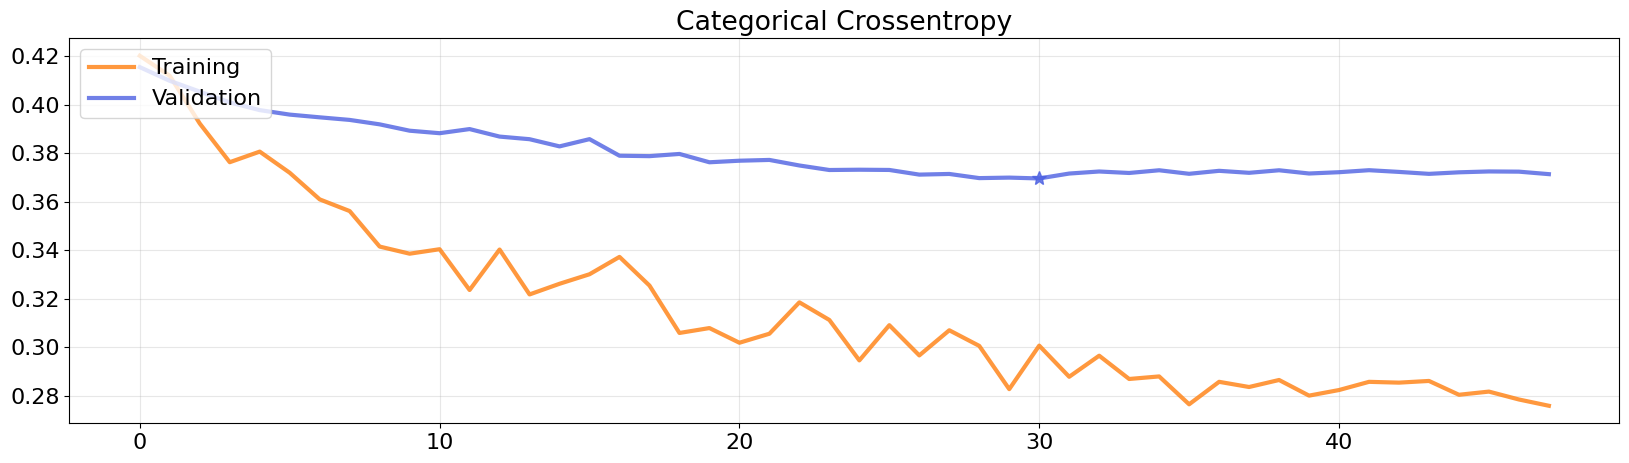

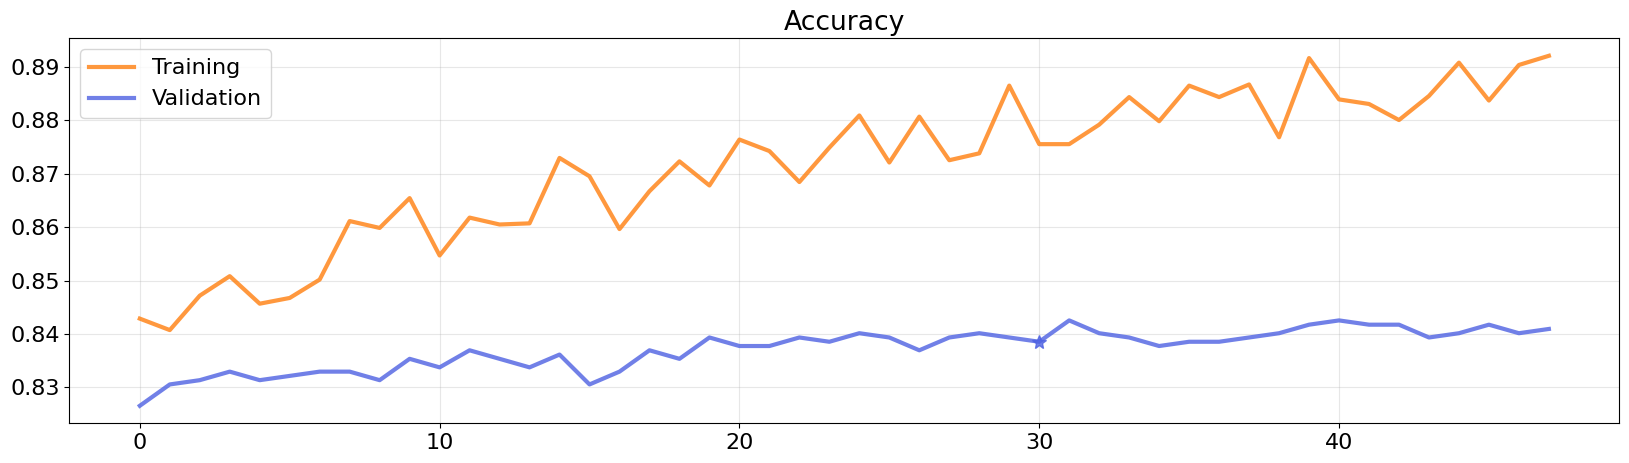

In [ ]:
plot_loss_accuracy_trend(EfficientNet_B3_ft_history,metrics='val_loss')

Accuracy: 0.8425
Precision: 0.8422
Recall: 0.8194
F1: 0.8278


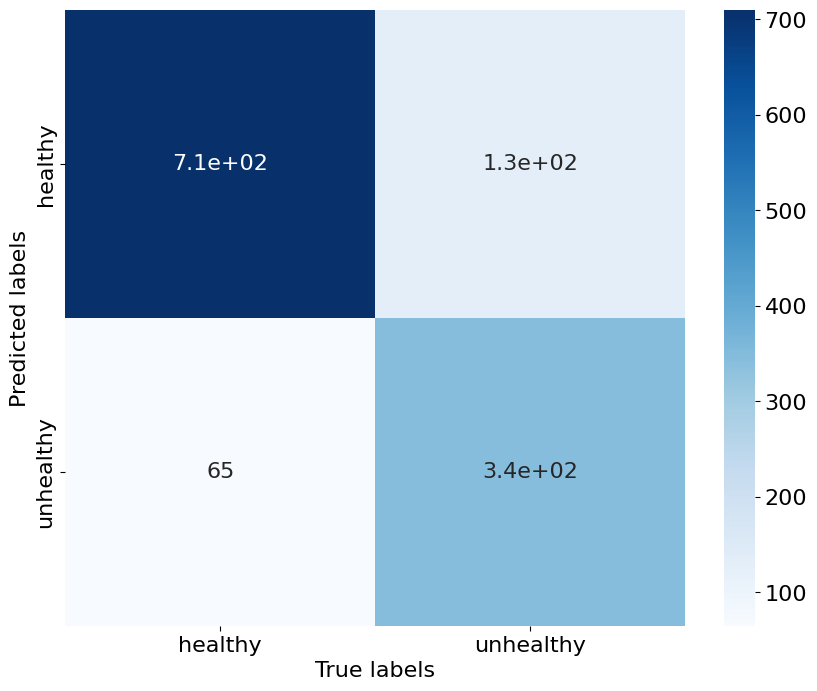

In [ ]:
(EfficientNet_B3_ft_acc,EfficientNet_B3_ft_pre,EfficientNet_B3_ft_rec,EfficientNet_B3_ft_f1)=show_metrics(EfficientNet_B3_ft,X_val,y_val,preprocess_input)

In [ ]:
EfficientNet_B3_ft.save('EfficientNet_B3_ft')

In [ ]:
del EfficientNet_B3_ft

##EfficientNetB3-V2

### Transfer learning + MLP

In [ ]:
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

model = tf.keras.applications.EfficientNetV2B3(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(96,96,3),
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    include_preprocessing=True,
)
tfk.utils.plot_model(model, show_shapes=True)
model.trainable = False #we don't want to train the model -> we freeze the pre-trained weights

inputs = tfk.Input(shape=(96, 96, 3))
x = model(inputs)

x = tfkl.GlobalAveragePooling2D(name='gap')(x)
x = tfkl.Dropout(rate=0.3,seed = seed)(x)

x = tfkl.Dense(64, activation='relu')(x)
x = tfkl.Dropout(rate=0.3,seed = seed)(x)

x = tfkl.Dense(64, activation='relu')(x)
x = tfkl.Dropout(rate=0.3,seed = seed)(x)

x = tfkl.Dense(32, activation='relu')(x)
x = tfkl.Dropout(rate=0.3,seed = seed)(x)

outputs = tfkl.Dense(2, activation='softmax')(x)


EfficientNetB3_V2 = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
EfficientNetB3_V2.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate = 0.0001), metrics=['accuracy'])

# Display model summary
EfficientNetB3_V2 .summary()

52606240/52606240 [==============================] - 2s 0us/step
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.724533 to fit

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetv2-b3 (Functio  (None, 3, 3, 1536)        12930622  
 nal)                                                            
                                                                 
 gap (GlobalAveragePooling2  (None, 1536)              0         
 D)                                                              
                                                                 
 dropout_24 (Dropout)        (None, 1536)              0         
                                                                 
 dense_26 (Dense)            (None, 64)         

In [ ]:
EfficientNetB3_V2_history = EfficientNetB3_V2.fit(
    x = preprocess_input(X_train*255), # we apply the preprcessing od Xception architecture
    y = y_train,
    batch_size = 32,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=25, restore_best_weights=True),
    tfk.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=5,factor=0.9,mode='min', min_lr=1e-7)]
).history

Epoch 1/200
146/146 [==============================] - 23s 70ms/step - loss: 0.7172 - accuracy: 0.5028 - val_loss: 0.6678 - val_accuracy: 0.6467 - lr: 1.0000e-04
Epoch 2/200
146/146 [==============================] - 5s 33ms/step - loss: 0.6716 - accuracy: 0.5795 - val_loss: 0.6298 - val_accuracy: 0.6898 - lr: 1.0000e-04
Epoch 3/200
146/146 [==============================] - 6s 40ms/step - loss: 0.6456 - accuracy: 0.6206 - val_loss: 0.5857 - val_accuracy: 0.7226 - lr: 1.0000e-04
Epoch 4/200
146/146 [==============================] - 5s 36ms/step - loss: 0.6073 - accuracy: 0.6660 - val_loss: 0.5374 - val_accuracy: 0.7634 - lr: 1.0000e-04
Epoch 5/200
146/146 [==============================] - 5s 35ms/step - loss: 0.5548 - accuracy: 0.7201 - val_loss: 0.4942 - val_accuracy: 0.7866 - lr: 1.0000e-04
Epoch 6/200
146/146 [==============================] - 6s 41ms/step - loss: 0.5436 - accuracy: 0.7248 - val_loss: 0.4834 - val_accuracy: 0.7946 - lr: 1.0000e-04
Epoch 7/200
146/146 [============

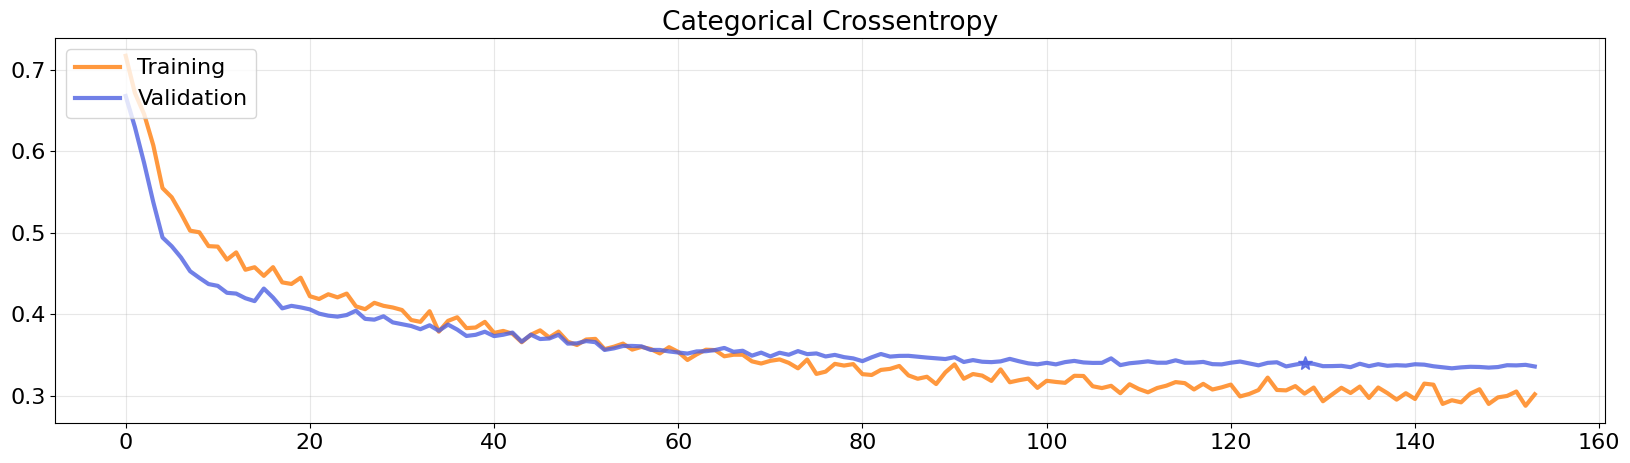

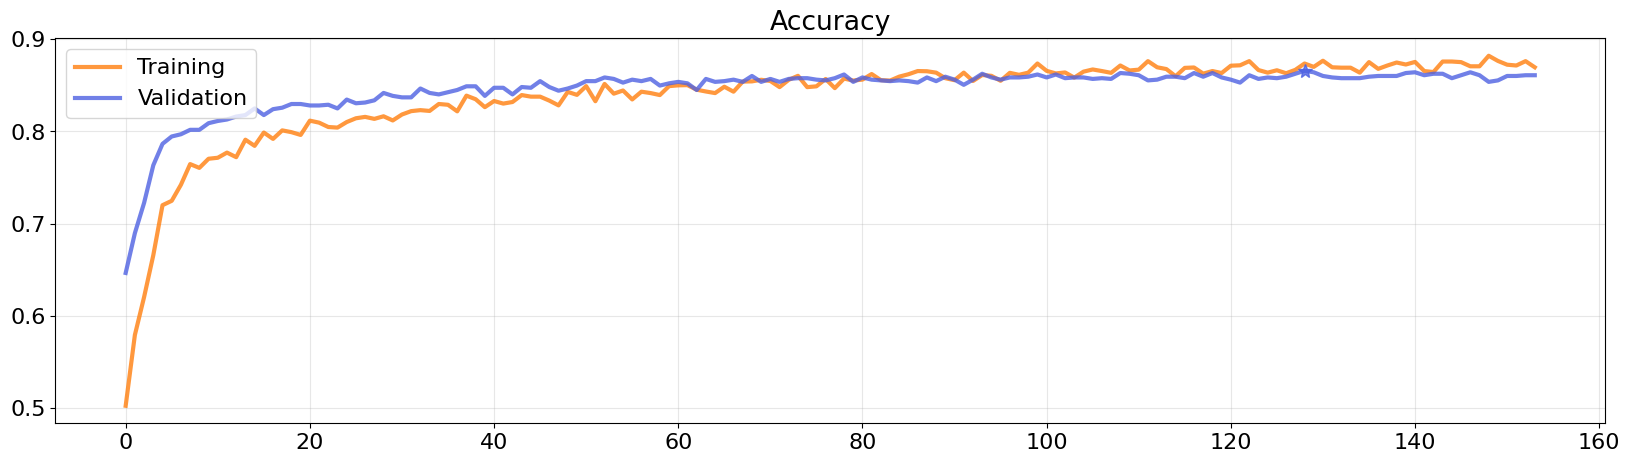

In [ ]:
plot_loss_accuracy_trend(EfficientNetB3_V2_history,metrics='val_accuracy')

Accuracy: 0.8657
Precision: 0.8647
Recall: 0.8474
F1: 0.8544


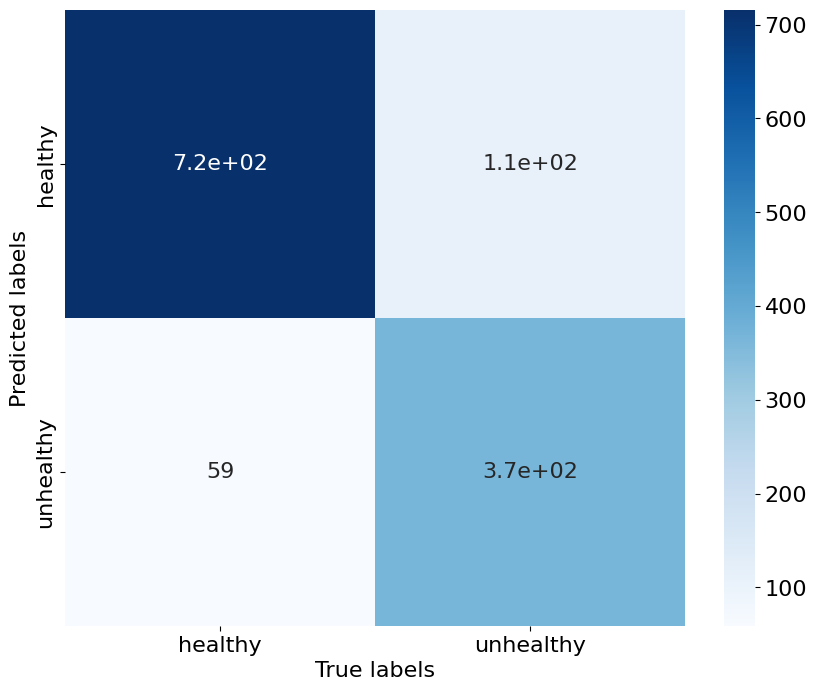

In [ ]:
(EfficientNetB3_V2_acc,EfficientNetB3_V2_pre,EfficientNetB3_V2_rec,EfficientNetB3_V2_f1)=show_metrics(EfficientNetB3_V2,X_val,y_val,preprocess_input)

In [ ]:
EfficientNetB3_V2.save('EfficientNetB3_V2')

In [ ]:
del EfficientNetB3_V2

### Fine tuning using balanced data

In [ ]:
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
EfficientNetB3_V2_ft = tfk.models.load_model('EfficientNetB3_V2')
EfficientNetB3_V2_ft.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetv2-b3 (Functio  (None, 3, 3, 1536)        12930622  
 nal)                                                            
                                                                 
 gap (GlobalAveragePooling2  (None, 1536)              0         
 D)                                                              
                                                                 
 dropout_24 (Dropout)        (None, 1536)              0         
                                                                 
 dense_26 (Dense)            (None, 64)                98368     
                                                                 
 dropout_25 (Dropout)        (None, 64)                0     

In [ ]:
string_model='efficientnetv2-b3'
EfficientNetB3_V2_ft.get_layer(string_model).trainable = True #we set all the layers of the conv part to trainable
for i, layer in enumerate(EfficientNetB3_V2_ft.get_layer(string_model).layers):
   print(i, layer.name, layer.trainable)

0 input_18 True
1 rescaling_12 True
2 normalization_6 True
3 stem_conv True
4 stem_bn True
5 stem_activation True
6 block1a_project_conv True
7 block1a_project_bn True
8 block1a_project_activation True
9 block1b_project_conv True
10 block1b_project_bn True
11 block1b_project_activation True
12 block1b_drop True
13 block1b_add True
14 block2a_expand_conv True
15 block2a_expand_bn True
16 block2a_expand_activation True
17 block2a_project_conv True
18 block2a_project_bn True
19 block2b_expand_conv True
20 block2b_expand_bn True
21 block2b_expand_activation True
22 block2b_project_conv True
23 block2b_project_bn True
24 block2b_drop True
25 block2b_add True
26 block2c_expand_conv True
27 block2c_expand_bn True
28 block2c_expand_activation True
29 block2c_project_conv True
30 block2c_project_bn True
31 block2c_drop True
32 block2c_add True
33 block3a_expand_conv True
34 block3a_expand_bn True
35 block3a_expand_activation True
36 block3a_project_conv True
37 block3a_project_bn True
38 block3

In [ ]:
N = 406 # we optimize it to reach the right tradeoff between number of learnable parameters and capability to learn
for i, layer in enumerate(EfficientNetB3_V2_ft.get_layer(string_model).layers[:N]):
  layer.trainable=False
for i, layer in enumerate(EfficientNetB3_V2_ft.get_layer(string_model).layers):
   print(i, layer.name, layer.trainable)
EfficientNetB3_V2_ft.summary()

0 input_18 False
1 rescaling_12 False
2 normalization_6 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block1b_project_conv False
10 block1b_project_bn False
11 block1b_project_activation False
12 block1b_drop False
13 block1b_add False
14 block2a_expand_conv False
15 block2a_expand_bn False
16 block2a_expand_activation False
17 block2a_project_conv False
18 block2a_project_bn False
19 block2b_expand_conv False
20 block2b_expand_bn False
21 block2b_expand_activation False
22 block2b_project_conv False
23 block2b_project_bn False
24 block2b_drop False
25 block2b_add False
26 block2c_expand_conv False
27 block2c_expand_bn False
28 block2c_expand_activation False
29 block2c_project_conv False
30 block2c_project_bn False
31 block2c_drop False
32 block2c_add False
33 block3a_expand_conv False
34 block3a_expand_bn False
35 block3a_expand_activation False
36 block3a_project_conv False

In [ ]:
EfficientNetB3_V2_ft.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(5e-5), metrics='accuracy')

In [ ]:
EfficientNetB3_V2_ft_history = EfficientNetB3_V2_ft.fit(
    x = preprocess_input(X_train*255),
    y = y_train_2,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=16, restore_best_weights=True),
                 tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.9, mode='min',min_lr=1e-7)]
).history

Epoch 1/200
291/291 [==============================] - 27s 44ms/step - loss: 1.2066 - accuracy: 0.5017 - val_loss: 0.5314 - val_accuracy: 0.7458 - lr: 5.0000e-05
Epoch 2/200
291/291 [==============================] - 8s 26ms/step - loss: 0.8831 - accuracy: 0.5120 - val_loss: 0.5977 - val_accuracy: 0.6827 - lr: 5.0000e-05
Epoch 3/200
291/291 [==============================] - 9s 32ms/step - loss: 0.7975 - accuracy: 0.5204 - val_loss: 0.6179 - val_accuracy: 0.6795 - lr: 5.0000e-05
Epoch 4/200
291/291 [==============================] - 7s 26ms/step - loss: 0.7662 - accuracy: 0.5058 - val_loss: 0.6329 - val_accuracy: 0.6755 - lr: 5.0000e-05
Epoch 5/200
291/291 [==============================] - 10s 35ms/step - loss: 0.7410 - accuracy: 0.5142 - val_loss: 0.6462 - val_accuracy: 0.6579 - lr: 5.0000e-05
Epoch 6/200
291/291 [==============================] - 11s 37ms/step - loss: 0.7186 - accuracy: 0.5254 - val_loss: 0.6547 - val_accuracy: 0.6467 - lr: 5.0000e-05
Epoch 7/200
291/291 [==========

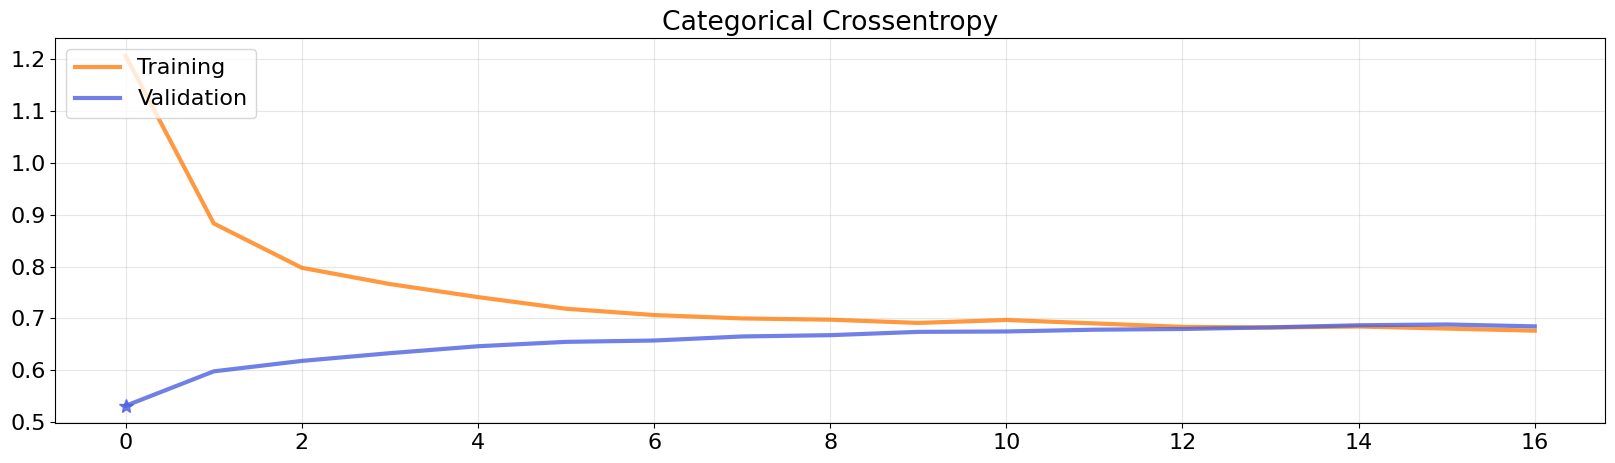

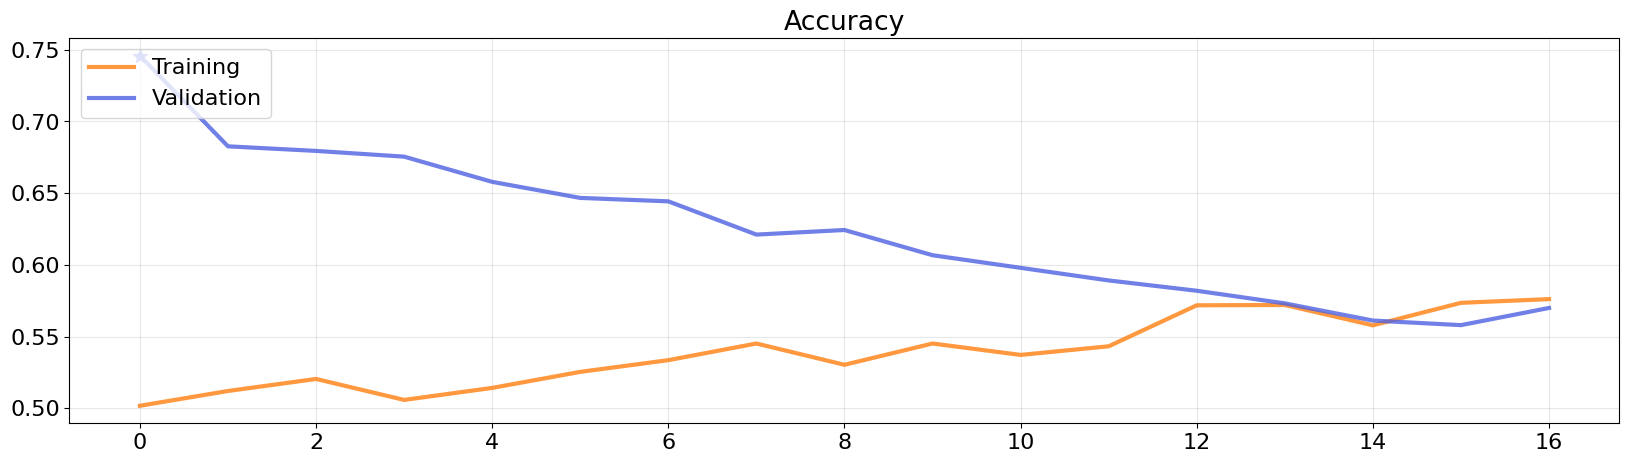

In [ ]:
plot_loss_accuracy_trend(EfficientNetB3_V2_ft_history,metrics='val_loss')

Accuracy: 0.7458
Precision: 0.7565
Recall: 0.6919
F1: 0.7


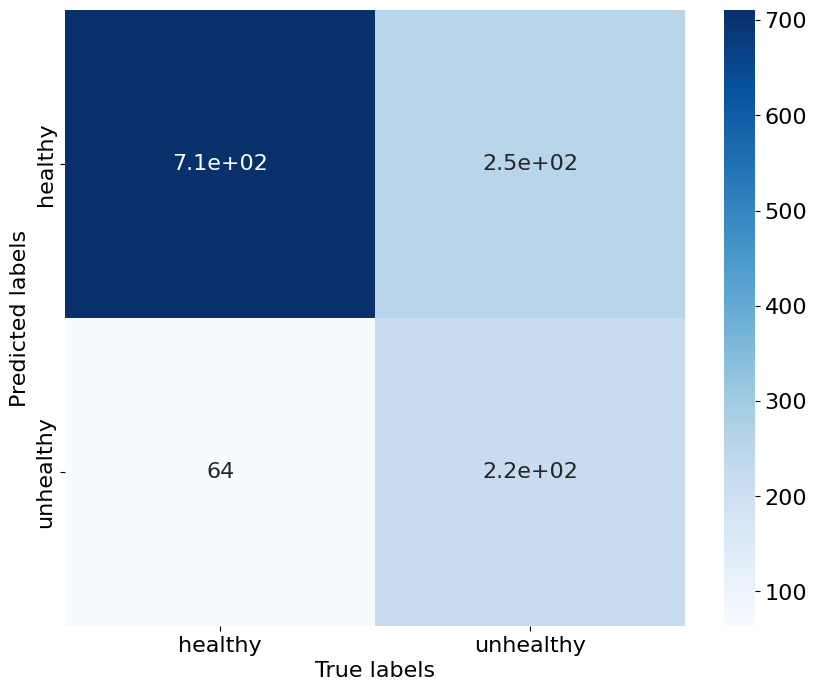

In [ ]:
(EfficientNetB3_V2_ft_acc,EfficientNetB3_V2_ft_pre,EfficientNetB3_V2_ft_rec,EfficientNetB3_V2_ft_f1)=show_metrics(EfficientNetB3_V2_ft,X_val,y_val,preprocess_input)

In [ ]:
EfficientNetB3_V2_ft.save('EfficientNetB3_V2_f')

In [ ]:
del EfficientNetB3_V2_ft

### Fine tuning on EfficientNetB3V2_MLP using unbalanced data

In [ ]:
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
EfficientNetB3_V2_ft = tfk.models.load_model('EfficientNetB3_V2')
EfficientNetB3_V2_ft.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetv2-b3 (Functio  (None, 3, 3, 1536)        12930622  
 nal)                                                            
                                                                 
 gap (GlobalAveragePooling2  (None, 1536)              0         
 D)                                                              
                                                                 
 dropout_24 (Dropout)        (None, 1536)              0         
                                                                 
 dense_26 (Dense)            (None, 64)                98368     
                                                                 
 dropout_25 (Dropout)        (None, 64)                0     

In [ ]:
string_model='efficientnetv2-b3'
EfficientNetB3_V2_ft.get_layer(string_model).trainable = True #we set all the layers of the conv part to trainable
for i, layer in enumerate(EfficientNetB3_V2_ft.get_layer(string_model).layers):
   print(i, layer.name, layer.trainable)

0 input_18 True
1 rescaling_12 True
2 normalization_6 True
3 stem_conv True
4 stem_bn True
5 stem_activation True
6 block1a_project_conv True
7 block1a_project_bn True
8 block1a_project_activation True
9 block1b_project_conv True
10 block1b_project_bn True
11 block1b_project_activation True
12 block1b_drop True
13 block1b_add True
14 block2a_expand_conv True
15 block2a_expand_bn True
16 block2a_expand_activation True
17 block2a_project_conv True
18 block2a_project_bn True
19 block2b_expand_conv True
20 block2b_expand_bn True
21 block2b_expand_activation True
22 block2b_project_conv True
23 block2b_project_bn True
24 block2b_drop True
25 block2b_add True
26 block2c_expand_conv True
27 block2c_expand_bn True
28 block2c_expand_activation True
29 block2c_project_conv True
30 block2c_project_bn True
31 block2c_drop True
32 block2c_add True
33 block3a_expand_conv True
34 block3a_expand_bn True
35 block3a_expand_activation True
36 block3a_project_conv True
37 block3a_project_bn True
38 block3

In [ ]:
N = 406 # we optimize it to reach the right tradeoff between number of learnable parameters and capability to learn
for i, layer in enumerate(EfficientNetB3_V2_ft.get_layer(string_model).layers[:N]):
  layer.trainable=False
for i, layer in enumerate(EfficientNetB3_V2_ft.get_layer(string_model).layers):
   print(i, layer.name, layer.trainable)
EfficientNetB3_V2_ft.summary()

0 input_18 False
1 rescaling_12 False
2 normalization_6 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block1b_project_conv False
10 block1b_project_bn False
11 block1b_project_activation False
12 block1b_drop False
13 block1b_add False
14 block2a_expand_conv False
15 block2a_expand_bn False
16 block2a_expand_activation False
17 block2a_project_conv False
18 block2a_project_bn False
19 block2b_expand_conv False
20 block2b_expand_bn False
21 block2b_expand_activation False
22 block2b_project_conv False
23 block2b_project_bn False
24 block2b_drop False
25 block2b_add False
26 block2c_expand_conv False
27 block2c_expand_bn False
28 block2c_expand_activation False
29 block2c_project_conv False
30 block2c_project_bn False
31 block2c_drop False
32 block2c_add False
33 block3a_expand_conv False
34 block3a_expand_bn False
35 block3a_expand_activation False
36 block3a_project_conv False

In [ ]:
EfficientNetB3_V2_ft.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(5e-5), metrics='accuracy')

In [ ]:
EfficientNetB3_V2_ft_history = EfficientNetB3_V2_ft.fit(
    x = preprocess_input(X_train_2*255),
    y = y_train_2,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=16, restore_best_weights=True),
                 tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.9, mode='min',min_lr=1e-7)]
).history

Epoch 1/200
291/291 [==============================] - 27s 47ms/step - loss: 0.4675 - accuracy: 0.8022 - val_loss: 0.3892 - val_accuracy: 0.8329 - lr: 5.0000e-05
Epoch 2/200
291/291 [==============================] - 9s 32ms/step - loss: 0.4245 - accuracy: 0.8156 - val_loss: 0.3781 - val_accuracy: 0.8465 - lr: 5.0000e-05
Epoch 3/200
291/291 [==============================] - 7s 24ms/step - loss: 0.3988 - accuracy: 0.8310 - val_loss: 0.3687 - val_accuracy: 0.8465 - lr: 5.0000e-05
Epoch 4/200
291/291 [==============================] - 10s 33ms/step - loss: 0.3848 - accuracy: 0.8325 - val_loss: 0.3581 - val_accuracy: 0.8497 - lr: 5.0000e-05
Epoch 5/200
291/291 [==============================] - 7s 25ms/step - loss: 0.3672 - accuracy: 0.8401 - val_loss: 0.3502 - val_accuracy: 0.8521 - lr: 5.0000e-05
Epoch 6/200
291/291 [==============================] - 9s 32ms/step - loss: 0.3637 - accuracy: 0.8424 - val_loss: 0.3479 - val_accuracy: 0.8537 - lr: 5.0000e-05
Epoch 7/200
291/291 [===========

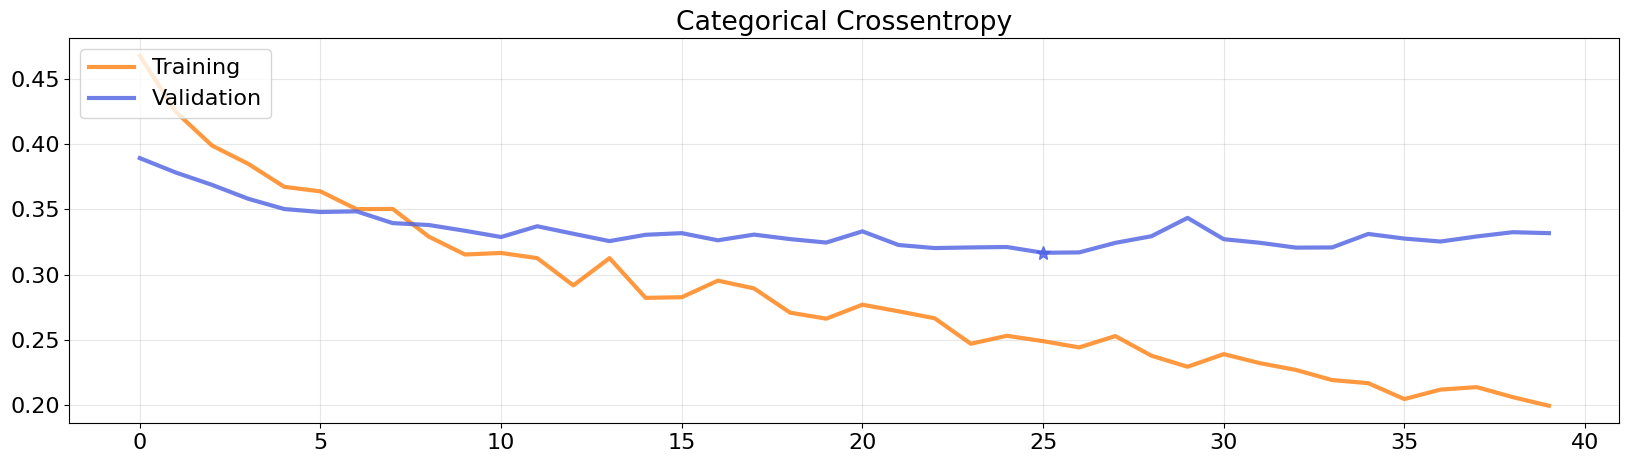

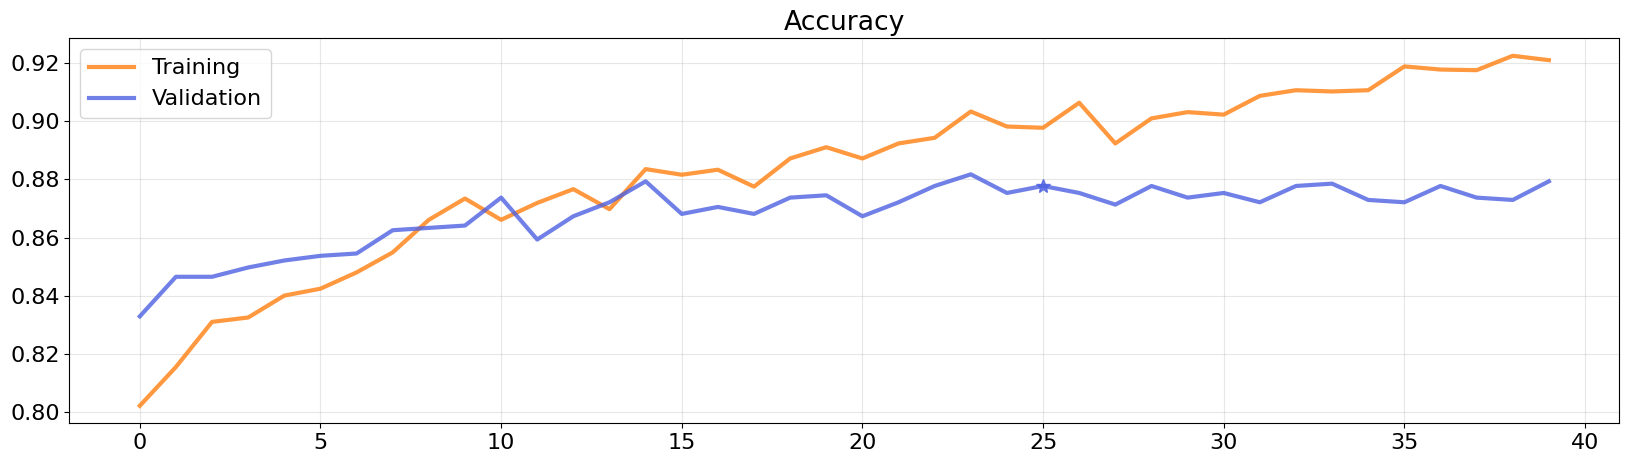

In [ ]:
plot_loss_accuracy_trend(EfficientNetB3_V2_ft_history,metrics='val_loss')

Accuracy: 0.8817
Precision: 0.8839
Recall: 0.8632
F1: 0.8713


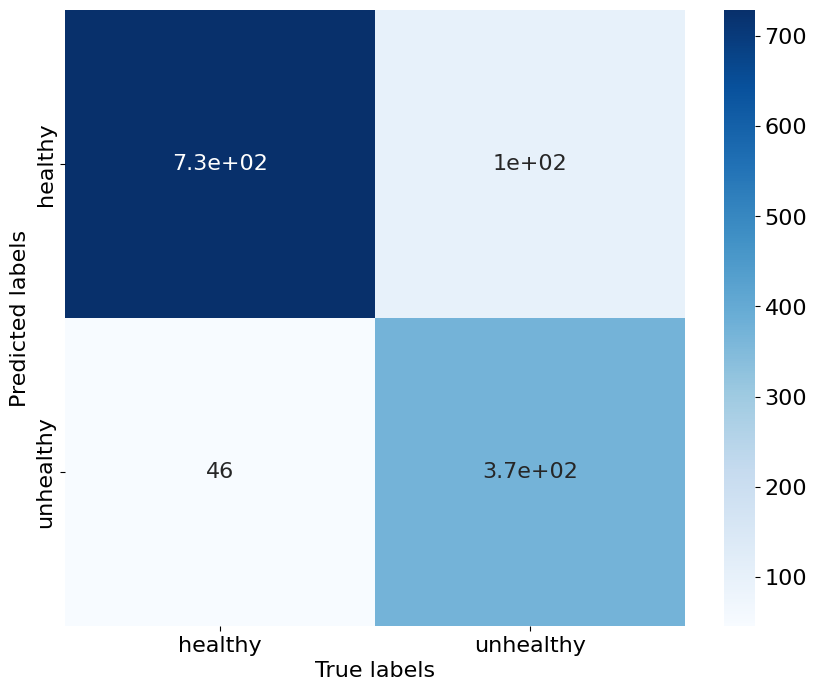

In [ ]:
(EfficientNetB3_V2_ft_acc,EfficientNetB3_V2_ft_pre,EfficientNetB3_V2_ft_rec,EfficientNetB3_V2_ft_f1)=show_metrics(EfficientNetB3_V2_ft,X_val,y_val,preprocess_input)

In [ ]:
EfficientNetB3_V2_ft.save('EfficientNetB3_V2_ft')

In [ ]:
del EfficientNetB3_V2_ft

## EfficientNetV2L

###Transfer learning without MLP

In [ ]:
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

model = tfk.applications.EfficientNetV2L(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet", #you select the dataset to use for training weights
    pooling='avg',
)
tfk.utils.plot_model(model, show_shapes=True)
model.trainable = False #we don't want to train mobilenet -> we freeze the pre-trained weights

inputs = tfk.Input(shape=(96, 96, 3))

x = model(inputs)

outputs = tfkl.Dense(2, activation='softmax')(x)

# Create a Model connecting input and output
EfficientNetV2L = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
EfficientNetV2L.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(0.0005), metrics=['accuracy'])

EfficientNetV2L.summary()# Display model summary

473176280/473176280 [==============================] - 3s 0us/step
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.287836 to fit

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetv2-l (Function  (None, 1280)              117746848 
 al)                                                             
                                                                 
 dense_3 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 117749410 (449.18 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 117746848 (449.17 MB)
_________________________________________________________________


In [ ]:
# Train the model
EfficientNetV2L_history = EfficientNetV2L.fit(
    x = preprocess_input(X_train*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 32,
    epochs = 50,
    validation_data = (preprocess_input(X_val*255), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True),
    tfk.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=7,factor=0.5,mode='min', min_lr=1e-5)]
).history

Epoch 1/50
146/146 [==============================] - 61s 220ms/step - loss: 0.5897 - accuracy: 0.7014 - val_loss: 0.5464 - val_accuracy: 0.7330 - lr: 5.0000e-04
Epoch 2/50
146/146 [==============================] - 19s 133ms/step - loss: 0.4863 - accuracy: 0.7846 - val_loss: 0.4760 - val_accuracy: 0.7978 - lr: 5.0000e-04
Epoch 3/50
146/146 [==============================] - 18s 126ms/step - loss: 0.4503 - accuracy: 0.8055 - val_loss: 0.4428 - val_accuracy: 0.8058 - lr: 5.0000e-04
Epoch 4/50
146/146 [==============================] - 19s 131ms/step - loss: 0.4319 - accuracy: 0.8123 - val_loss: 0.4279 - val_accuracy: 0.8145 - lr: 5.0000e-04
Epoch 5/50
146/146 [==============================] - 19s 131ms/step - loss: 0.4127 - accuracy: 0.8205 - val_loss: 0.4151 - val_accuracy: 0.8233 - lr: 5.0000e-04
Epoch 6/50
146/146 [==============================] - 18s 120ms/step - loss: 0.4062 - accuracy: 0.8229 - val_loss: 0.4133 - val_accuracy: 0.8201 - lr: 5.0000e-04
Epoch 7/50
146/146 [========

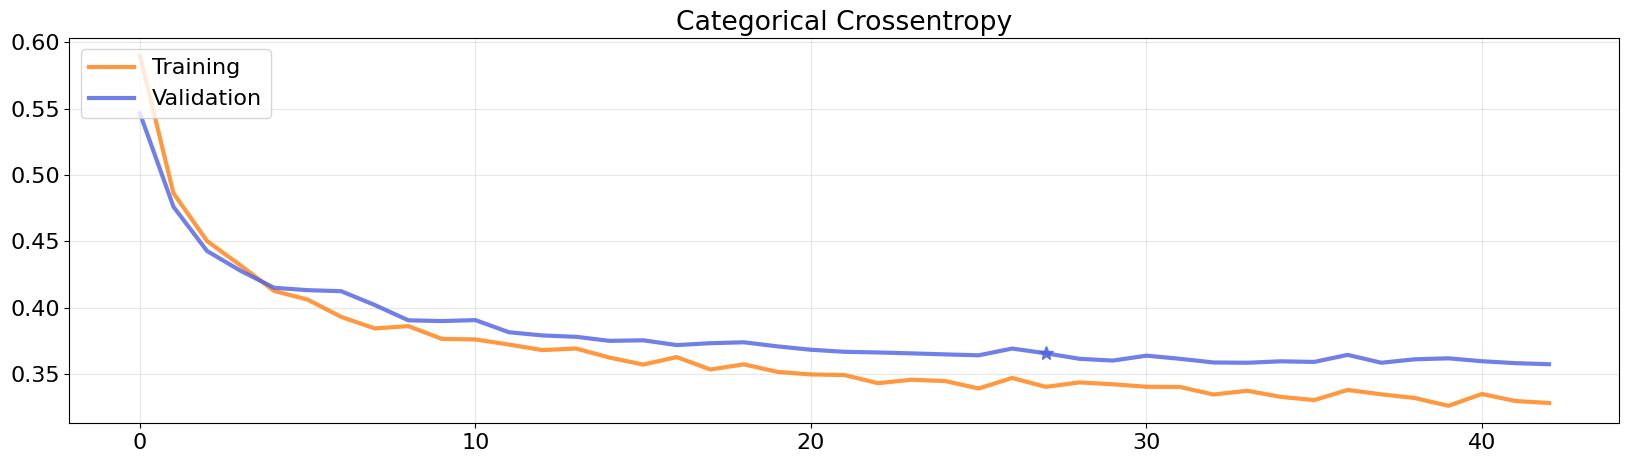

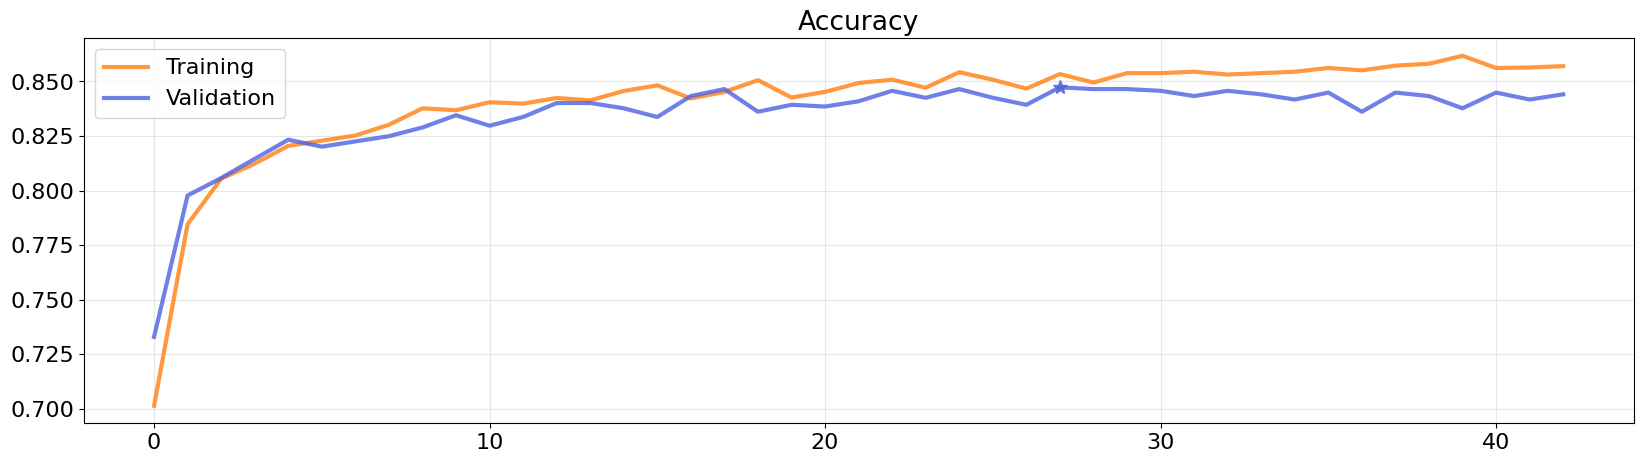

In [ ]:
plot_loss_accuracy_trend(EfficientNetV2L_history,metrics='val_accuracy')

Accuracy: 0.8473
Precision: 0.848
Recall: 0.8241
F1: 0.8329


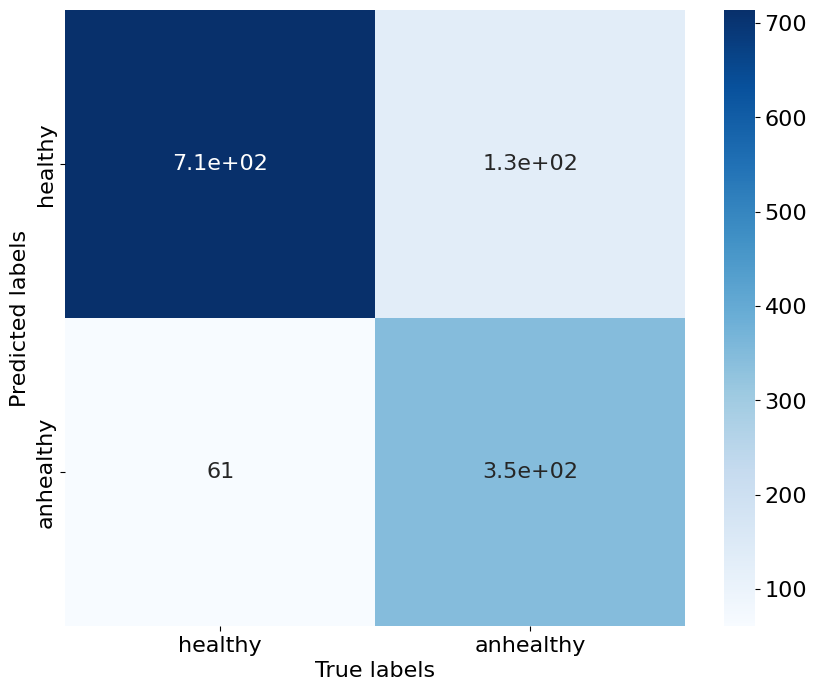

In [ ]:
(EfficientNetV2L_acc,EfficientNetV2L_pre,EfficientNetV2L_rec,EfficientNetV2L_f1)=show_metrics(EfficientNetV2L,X_val,y_val,preprocess_input)

In [ ]:
EfficientNetV2L.save('EfficientNetV2L')

In [ ]:
del EfficientNetV2L

###Fine tuning on EfficientNetV2L using balance data


In [ ]:
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
EfficientNetV2L_ft = tfk.models.load_model('EfficientNetV2L')
EfficientNetV2L_ft.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetv2-l (Function  (None, 1280)              117746848 
 al)                                                             
                                                                 
 dense_3 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 117749410 (449.18 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 117746848 (449.17 MB)
_________________________________________________________________


In [ ]:
string_model='efficientnetv2-l'
EfficientNetV2L_ft.get_layer(string_model).trainable = True #we set all the layers of the conv part to trainable
for i, layer in enumerate(EfficientNetV2L_ft.get_layer(string_model).layers):
   print(i, layer.name, layer.trainable)

0 input_3 True
1 rescaling True
2 stem_conv True
3 stem_bn True
4 stem_activation True
5 block1a_project_conv True
6 block1a_project_bn True
7 block1a_project_activation True
8 block1a_add True
9 block1b_project_conv True
10 block1b_project_bn True
11 block1b_project_activation True
12 block1b_drop True
13 block1b_add True
14 block1c_project_conv True
15 block1c_project_bn True
16 block1c_project_activation True
17 block1c_drop True
18 block1c_add True
19 block1d_project_conv True
20 block1d_project_bn True
21 block1d_project_activation True
22 block1d_drop True
23 block1d_add True
24 block2a_expand_conv True
25 block2a_expand_bn True
26 block2a_expand_activation True
27 block2a_project_conv True
28 block2a_project_bn True
29 block2b_expand_conv True
30 block2b_expand_bn True
31 block2b_expand_activation True
32 block2b_project_conv True
33 block2b_project_bn True
34 block2b_drop True
35 block2b_add True
36 block2c_expand_conv True
37 block2c_expand_bn True
38 block2c_expand_activation

In [ ]:
N = 1025
for i, layer in enumerate(EfficientNetV2L_ft.get_layer(string_model).layers[:N]):
  layer.trainable=False
for i, layer in enumerate(EfficientNetV2L_ft.get_layer(string_model).layers):
   print(i, layer.name, layer.trainable)
EfficientNetV2L_ft.summary()

0 input_3 False
1 rescaling False
2 stem_conv False
3 stem_bn False
4 stem_activation False
5 block1a_project_conv False
6 block1a_project_bn False
7 block1a_project_activation False
8 block1a_add False
9 block1b_project_conv False
10 block1b_project_bn False
11 block1b_project_activation False
12 block1b_drop False
13 block1b_add False
14 block1c_project_conv False
15 block1c_project_bn False
16 block1c_project_activation False
17 block1c_drop False
18 block1c_add False
19 block1d_project_conv False
20 block1d_project_bn False
21 block1d_project_activation False
22 block1d_drop False
23 block1d_add False
24 block2a_expand_conv False
25 block2a_expand_bn False
26 block2a_expand_activation False
27 block2a_project_conv False
28 block2a_project_bn False
29 block2b_expand_conv False
30 block2b_expand_bn False
31 block2b_expand_activation False
32 block2b_project_conv False
33 block2b_project_bn False
34 block2b_drop False
35 block2b_add False
36 block2c_expand_conv False
37 block2c_expand

In [ ]:
EfficientNetV2L_ft.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics='accuracy')

In [ ]:
EfficientNetV2L_ft_history = EfficientNetV2L_ft.fit(
    x = preprocess_input(X_train*255),
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=9, restore_best_weights=True)]
).history

Epoch 1/200
291/291 [==============================] - 77s 113ms/step - loss: 0.4152 - accuracy: 0.8295 - val_loss: 0.3915 - val_accuracy: 0.8433
Epoch 2/200
291/291 [==============================] - 23s 79ms/step - loss: 0.4025 - accuracy: 0.8379 - val_loss: 0.3805 - val_accuracy: 0.8473
Epoch 3/200
291/291 [==============================] - 23s 80ms/step - loss: 0.3926 - accuracy: 0.8360 - val_loss: 0.3821 - val_accuracy: 0.8441
Epoch 4/200
291/291 [==============================] - 23s 80ms/step - loss: 0.3942 - accuracy: 0.8347 - val_loss: 0.3692 - val_accuracy: 0.8497
Epoch 5/200
291/291 [==============================] - 29s 99ms/step - loss: 0.3806 - accuracy: 0.8457 - val_loss: 0.3629 - val_accuracy: 0.8425
Epoch 6/200
291/291 [==============================] - 24s 82ms/step - loss: 0.3797 - accuracy: 0.8454 - val_loss: 0.3590 - val_accuracy: 0.8505
Epoch 7/200
291/291 [==============================] - 24s 82ms/step - loss: 0.3732 - accuracy: 0.8439 - val_loss: 0.3578 - val_a

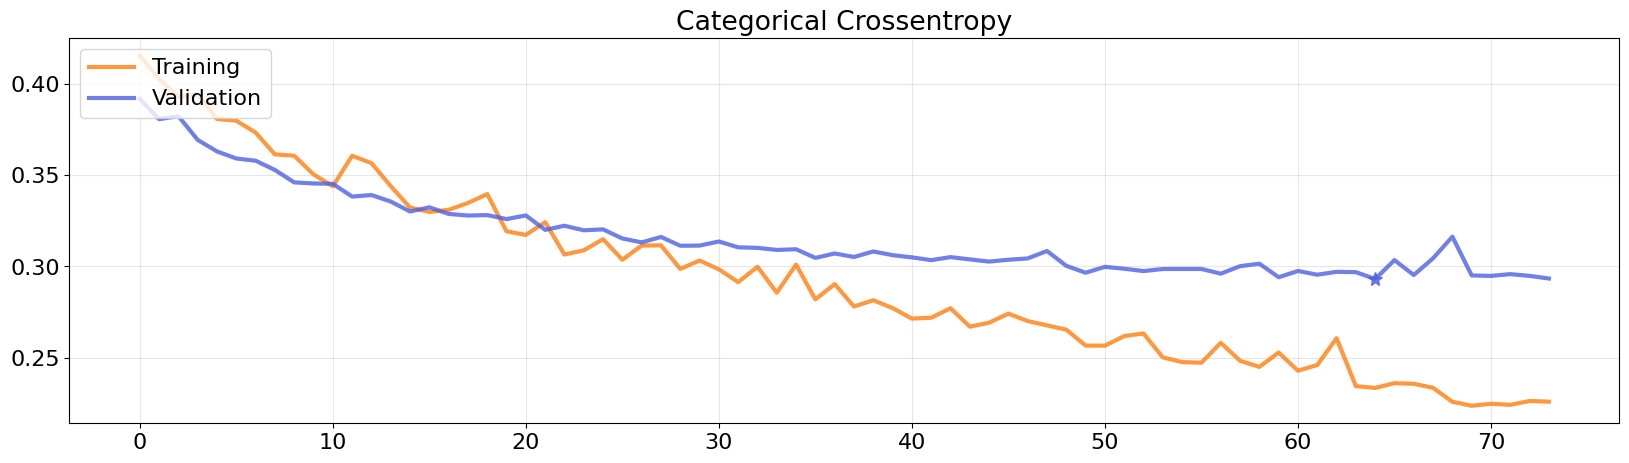

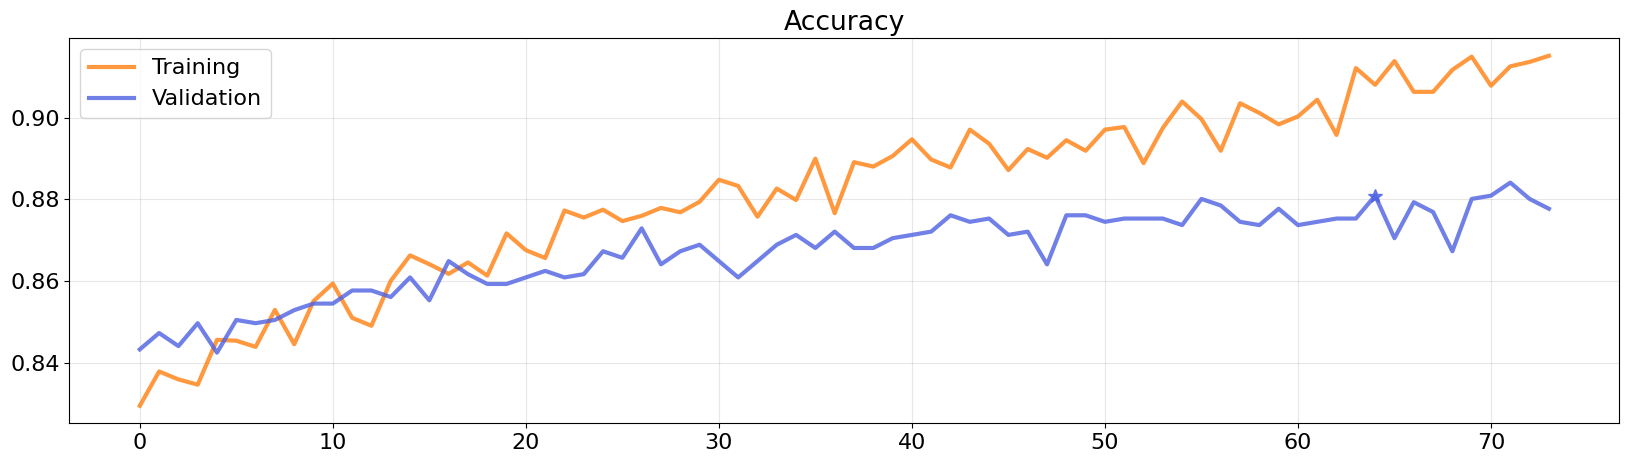

In [ ]:
plot_loss_accuracy_trend(EfficientNetV2L_ft_history,metrics='val_loss')

Accuracy: 0.8809
Precision: 0.8772
Recall: 0.8682
F1: 0.8722


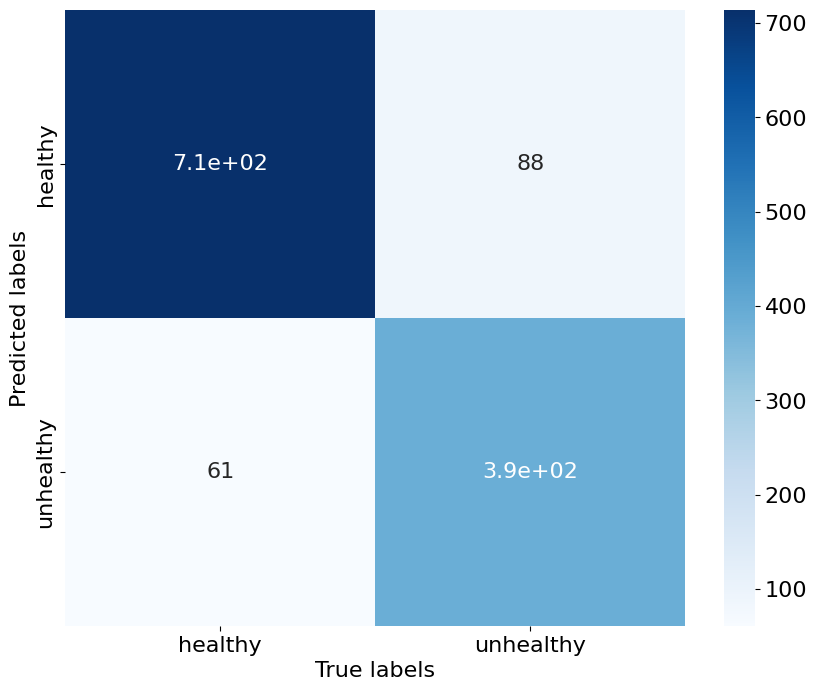

In [ ]:
(EfficientNetV2L_ft_acc,EfficientNetV2L_ft_pre,EfficientNetV2L_ft_rec,EfficientNetV2L_ft_f1)=show_metrics(EfficientNetV2L_ft,X_val,y_val,preprocess_input)

In [ ]:
EfficientNetV2L_ft.save('EfficientNetV2L_ft')

In [ ]:
del EfficientNetV2L_ft

###Fine tuning on EfficientNetV2L using unbalanced data

In [ ]:
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
EfficientNetV2L_ft = tfk.models.load_model('EfficientNetV2L')
EfficientNetV2L_ft.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetv2-l (Function  (None, 1280)              117746848 
 al)                                                             
                                                                 
 dense_3 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 117749410 (449.18 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 117746848 (449.17 MB)
_________________________________________________________________


In [ ]:
string_model='efficientnetv2-l'
EfficientNetV2L_ft.get_layer(string_model).trainable = True #we set all the layers of the conv part to trainable
for i, layer in enumerate(EfficientNetV2L_ft.get_layer(string_model).layers):
   print(i, layer.name, layer.trainable)

0 input_3 True
1 rescaling True
2 stem_conv True
3 stem_bn True
4 stem_activation True
5 block1a_project_conv True
6 block1a_project_bn True
7 block1a_project_activation True
8 block1a_add True
9 block1b_project_conv True
10 block1b_project_bn True
11 block1b_project_activation True
12 block1b_drop True
13 block1b_add True
14 block1c_project_conv True
15 block1c_project_bn True
16 block1c_project_activation True
17 block1c_drop True
18 block1c_add True
19 block1d_project_conv True
20 block1d_project_bn True
21 block1d_project_activation True
22 block1d_drop True
23 block1d_add True
24 block2a_expand_conv True
25 block2a_expand_bn True
26 block2a_expand_activation True
27 block2a_project_conv True
28 block2a_project_bn True
29 block2b_expand_conv True
30 block2b_expand_bn True
31 block2b_expand_activation True
32 block2b_project_conv True
33 block2b_project_bn True
34 block2b_drop True
35 block2b_add True
36 block2c_expand_conv True
37 block2c_expand_bn True
38 block2c_expand_activation

In [ ]:
N = 1025
for i, layer in enumerate(EfficientNetV2L_ft.get_layer(string_model).layers[:N]):
  layer.trainable=False
for i, layer in enumerate(EfficientNetV2L_ft.get_layer(string_model).layers):
   print(i, layer.name, layer.trainable)
EfficientNetV2L_ft.summary()

0 input_3 False
1 rescaling False
2 stem_conv False
3 stem_bn False
4 stem_activation False
5 block1a_project_conv False
6 block1a_project_bn False
7 block1a_project_activation False
8 block1a_add False
9 block1b_project_conv False
10 block1b_project_bn False
11 block1b_project_activation False
12 block1b_drop False
13 block1b_add False
14 block1c_project_conv False
15 block1c_project_bn False
16 block1c_project_activation False
17 block1c_drop False
18 block1c_add False
19 block1d_project_conv False
20 block1d_project_bn False
21 block1d_project_activation False
22 block1d_drop False
23 block1d_add False
24 block2a_expand_conv False
25 block2a_expand_bn False
26 block2a_expand_activation False
27 block2a_project_conv False
28 block2a_project_bn False
29 block2b_expand_conv False
30 block2b_expand_bn False
31 block2b_expand_activation False
32 block2b_project_conv False
33 block2b_project_bn False
34 block2b_drop False
35 block2b_add False
36 block2c_expand_conv False
37 block2c_expand

In [ ]:
EfficientNetV2L_ft.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics='accuracy')

In [ ]:
EfficientNetV2L_ft_history = EfficientNetV2L_ft.fit(
    x = preprocess_input(X_train_2*255),
    y = y_train_2,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=9, restore_best_weights=True)]
).history

Epoch 1/200
291/291 [==============================] - 86s 127ms/step - loss: 0.4164 - accuracy: 0.8259 - val_loss: 0.3948 - val_accuracy: 0.8393
Epoch 2/200
291/291 [==============================] - 31s 105ms/step - loss: 0.4027 - accuracy: 0.8315 - val_loss: 0.3814 - val_accuracy: 0.8401
Epoch 3/200
291/291 [==============================] - 25s 87ms/step - loss: 0.3919 - accuracy: 0.8401 - val_loss: 0.3761 - val_accuracy: 0.8433
Epoch 4/200
291/291 [==============================] - 30s 102ms/step - loss: 0.3862 - accuracy: 0.8403 - val_loss: 0.3675 - val_accuracy: 0.8457
Epoch 5/200
291/291 [==============================] - 25s 86ms/step - loss: 0.3794 - accuracy: 0.8433 - val_loss: 0.3605 - val_accuracy: 0.8409
Epoch 6/200
291/291 [==============================] - 26s 90ms/step - loss: 0.3801 - accuracy: 0.8403 - val_loss: 0.3582 - val_accuracy: 0.8449
Epoch 7/200
291/291 [==============================] - 25s 87ms/step - loss: 0.3713 - accuracy: 0.8426 - val_loss: 0.3520 - val

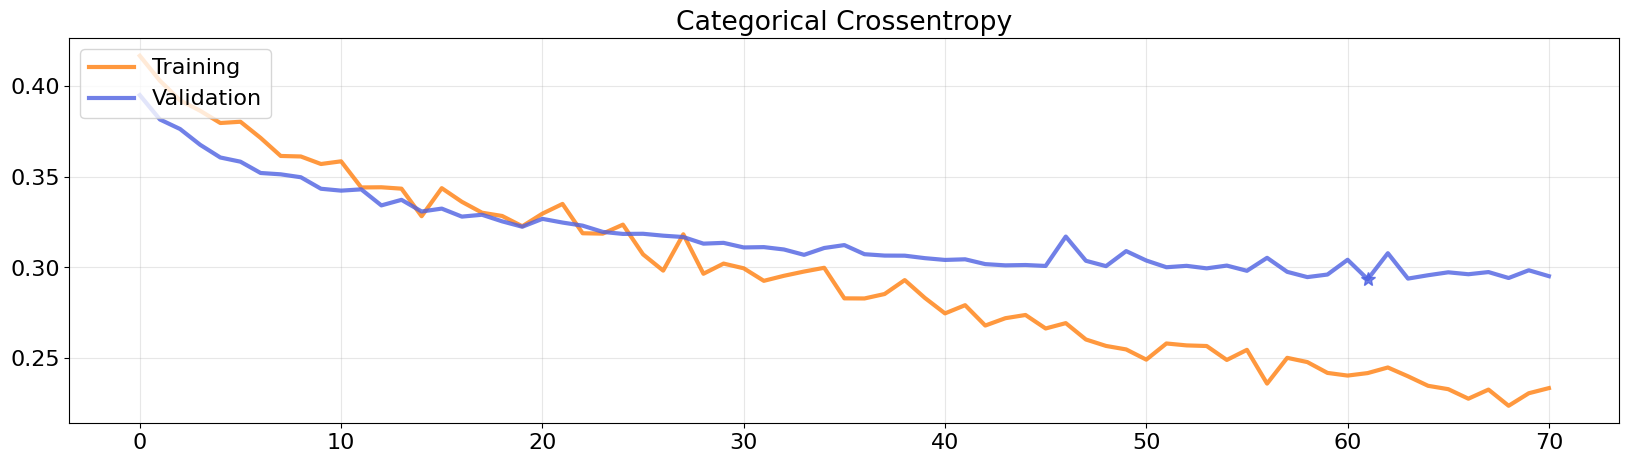

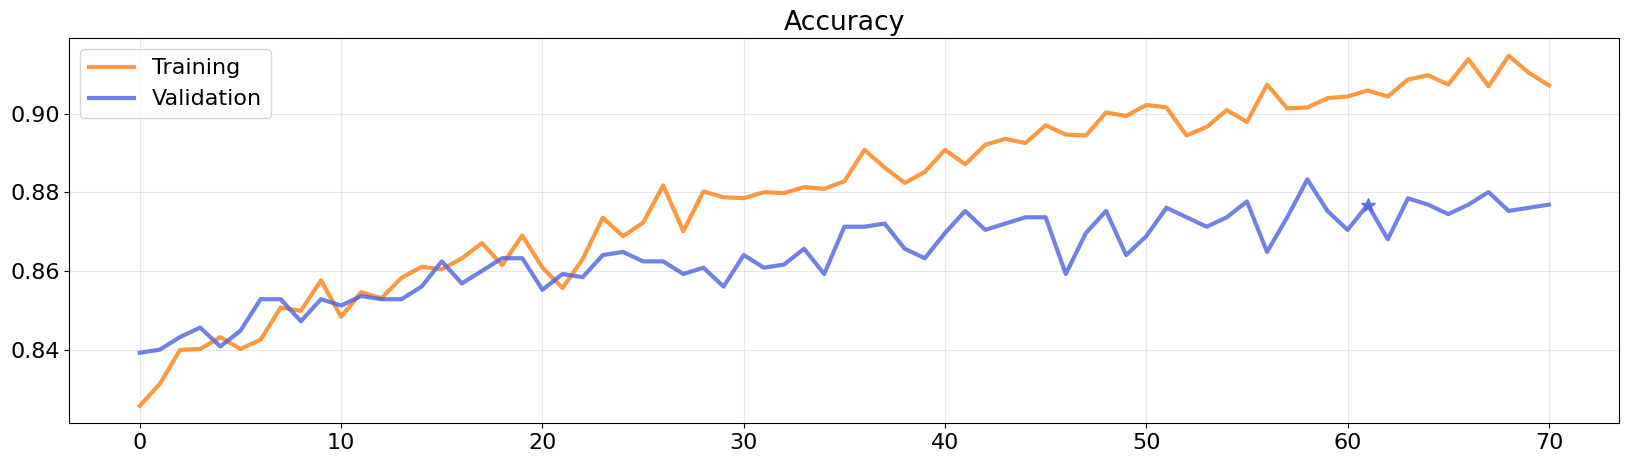

In [ ]:
plot_loss_accuracy_trend(EfficientNetV2L_ft_history,metrics='val_loss')

Accuracy: 0.8769
Precision: 0.8751
Recall: 0.8613
F1: 0.8671


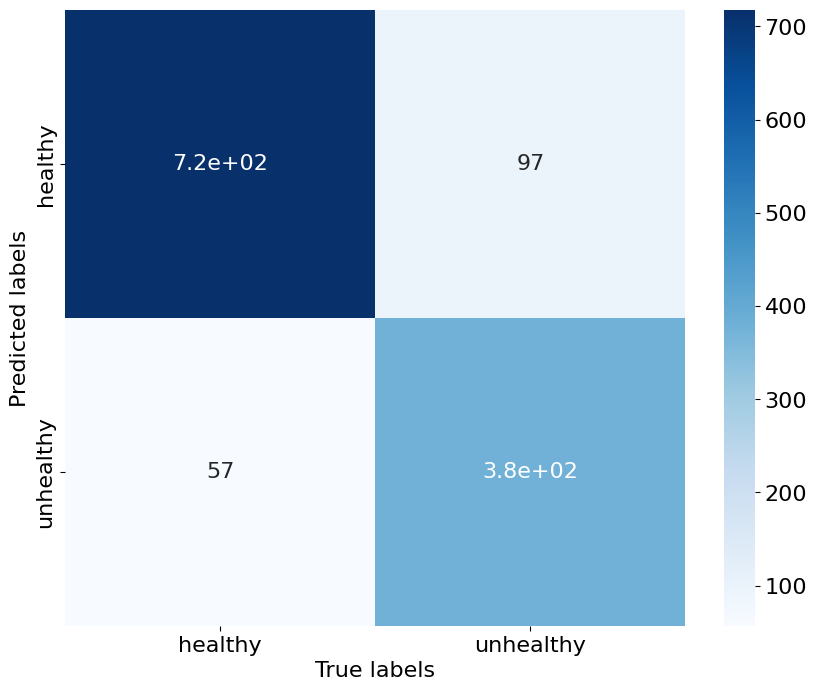

In [ ]:
(EfficientNetV2L_ft_acc,EfficientNetV2L_ft_pre,EfficientNetV2L_ft_rec,EfficientNetV2L_ft_f1)=show_metrics(EfficientNetV2L_ft,X_val,y_val,preprocess_input)

In [ ]:
EfficientNetV2L_ft.save('EfficientNetV2L_ft_unbalanced')

In [ ]:
del EfficientNetV2L_ft

###EffcientNetV2L+MLP

In [ ]:
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

model = tfk.applications.EfficientNetV2L(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet", #you select the dataset to use for training weights
    pooling='avg',
)
tfk.utils.plot_model(model, show_shapes=True)

model.trainable = False #we don't want to train mobilenet -> we freeze the pre-trained weights

inputs = tfk.Input(shape=(96, 96, 3))
x = model(inputs)

x=tfkl.Dense(128,activation='relu')(x)
x=tfkl.Dropout(rate=0.3,seed=seed)(x)

x=tfkl.Dense(64,activation='relu')(x)
x=tfkl.Dropout(rate=0.3,seed=seed)(x)

x=tfkl.Dense(32,activation='relu')(x)
x=tfkl.Dropout(rate=0.3,seed=seed)(x)

outputs = tfkl.Dense(2, activation='softmax')(x)

# Create a Model connecting input and output
EfficientNetV2L_MLP = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
EfficientNetV2L_MLP.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(0.0005), metrics=['accuracy'])

EfficientNetV2L_MLP.summary()# Display model summary

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.287836 to fit

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetv2-l (Function  (None, 1280)              117746848 
 al)                                                             
                                                                 
 dense_22 (Dense)            (None, 128)               163968    
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                                 
 dense_23 (Dense)            (None, 64)                8256      
                                                                 
 dropout_16 (Dropout)        (None, 64)        

In [ ]:
# Train the model
EfficientNetV2L_MLP_history = EfficientNetV2L_MLP.fit(
    x = preprocess_input(X_train*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 32,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
    tfk.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=7,factor=0.7,mode='min', min_lr=1e-5)]
).history



Epoch 1/200
146/146 [==============================] - 58s 188ms/step - loss: 0.6484 - accuracy: 0.6258 - val_loss: 0.5139 - val_accuracy: 0.7810 - lr: 5.0000e-04
Epoch 2/200
146/146 [==============================] - 20s 136ms/step - loss: 0.4873 - accuracy: 0.7659 - val_loss: 0.4281 - val_accuracy: 0.8161 - lr: 5.0000e-04
Epoch 3/200
146/146 [==============================] - 19s 131ms/step - loss: 0.4346 - accuracy: 0.8001 - val_loss: 0.4030 - val_accuracy: 0.8257 - lr: 5.0000e-04
Epoch 4/200
146/146 [==============================] - 20s 136ms/step - loss: 0.4066 - accuracy: 0.8162 - val_loss: 0.3876 - val_accuracy: 0.8241 - lr: 5.0000e-04
Epoch 5/200
146/146 [==============================] - 20s 137ms/step - loss: 0.3851 - accuracy: 0.8310 - val_loss: 0.3704 - val_accuracy: 0.8369 - lr: 5.0000e-04
Epoch 6/200
146/146 [==============================] - 19s 131ms/step - loss: 0.3781 - accuracy: 0.8368 - val_loss: 0.3681 - val_accuracy: 0.8497 - lr: 5.0000e-04
Epoch 7/200
146/146 [=

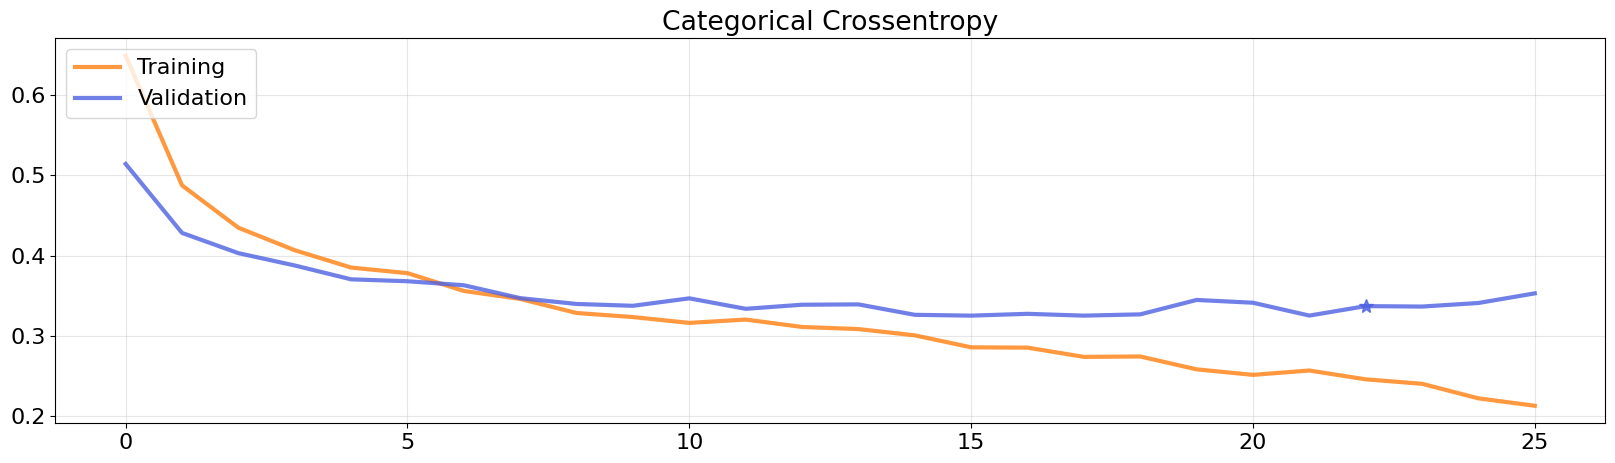

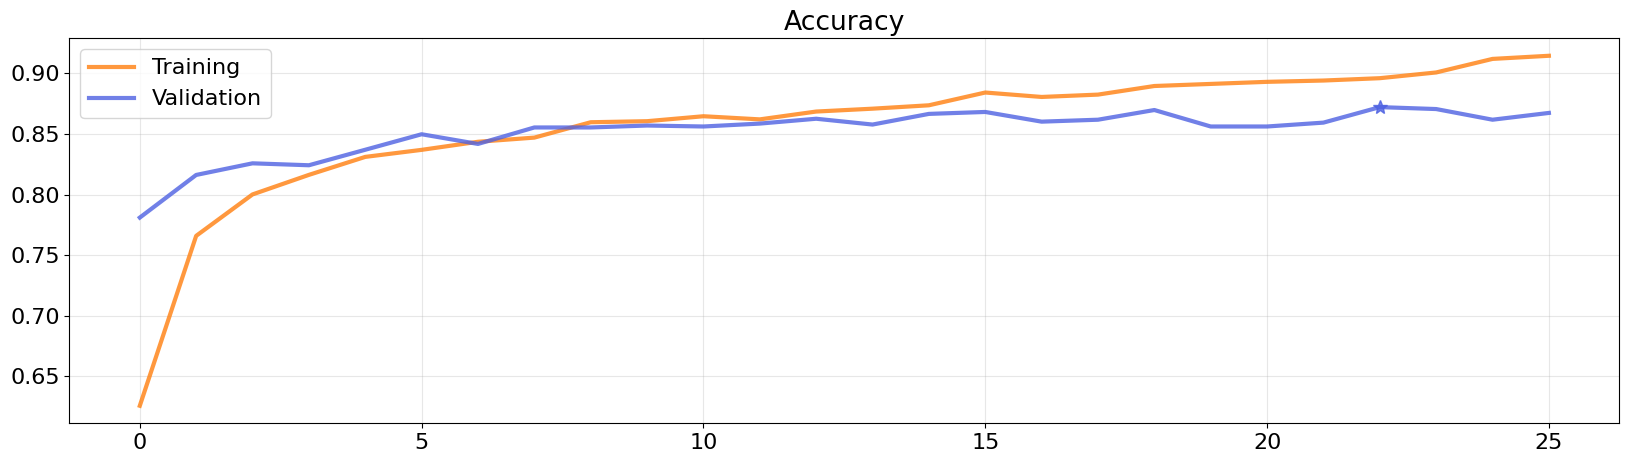

In [ ]:
plot_loss_accuracy_trend(EfficientNetV2L_MLP_history,metrics='val_accuracy')

Accuracy: 0.8681
Precision: 0.8653
Recall: 0.8522
F1: 0.8577


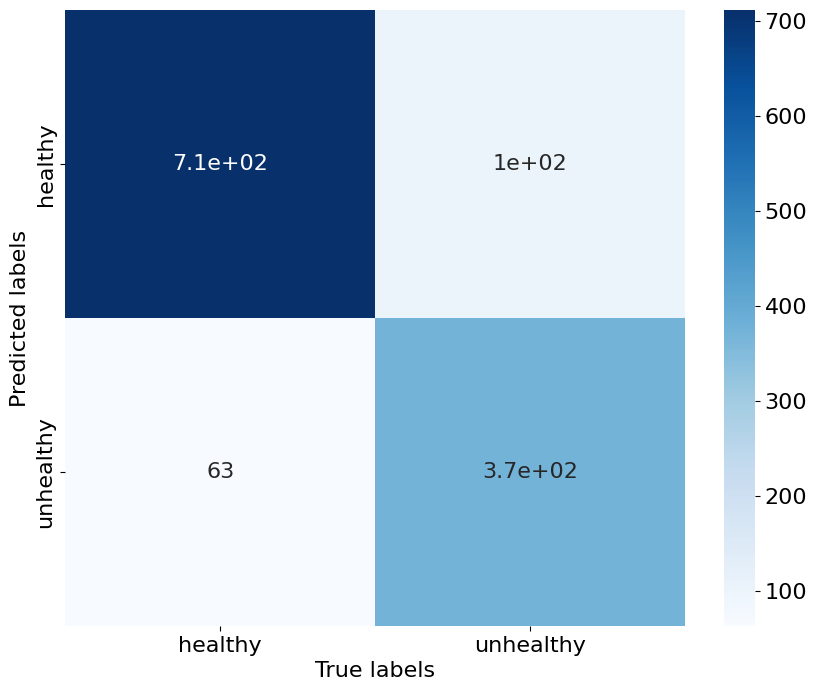

In [ ]:
(EfficientNetV2L_MLP_acc,EfficientNetV2L_MLP_pre,EfficientNetV2L_MLP_rec,EfficientNetV2L_MLP_f1)=show_metrics(EfficientNetV2L_MLP,X_val,y_val,preprocess_input)

In [ ]:
EfficientNetV2L_MLP.save('EfficientNetV2L_MLP')

In [ ]:
del EfficientNetV2L_MLP

###Fine tuning on EfficientNetV2L_MLP using unbalanced data

In [ ]:
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
EfficientNetV2L_MLP_ft = tfk.models.load_model('EfficientNetV2L_MLP')
EfficientNetV2L_MLP_ft.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetv2-l (Function  (None, 1280)              117746848 
 al)                                                             
                                                                 
 dense_22 (Dense)            (None, 128)               163968    
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                                 
 dense_23 (Dense)            (None, 64)                8256      
                                                                 
 dropout_16 (Dropout)        (None, 64)                0         
                                                             

In [ ]:
string_model='efficientnetv2-l'
EfficientNetV2L_MLP_ft.get_layer(string_model).trainable = True #we set all the layers of the conv part to trainable
for i, layer in enumerate(EfficientNetV2L_MLP_ft.get_layer(string_model).layers):
   print(i, layer.name, layer.trainable)

0 input_3 True
1 rescaling_1 True
2 stem_conv True
3 stem_bn True
4 stem_activation True
5 block1a_project_conv True
6 block1a_project_bn True
7 block1a_project_activation True
8 block1a_add True
9 block1b_project_conv True
10 block1b_project_bn True
11 block1b_project_activation True
12 block1b_drop True
13 block1b_add True
14 block1c_project_conv True
15 block1c_project_bn True
16 block1c_project_activation True
17 block1c_drop True
18 block1c_add True
19 block1d_project_conv True
20 block1d_project_bn True
21 block1d_project_activation True
22 block1d_drop True
23 block1d_add True
24 block2a_expand_conv True
25 block2a_expand_bn True
26 block2a_expand_activation True
27 block2a_project_conv True
28 block2a_project_bn True
29 block2b_expand_conv True
30 block2b_expand_bn True
31 block2b_expand_activation True
32 block2b_project_conv True
33 block2b_project_bn True
34 block2b_drop True
35 block2b_add True
36 block2c_expand_conv True
37 block2c_expand_bn True
38 block2c_expand_activati

In [ ]:
N = 1025
for i, layer in enumerate(EfficientNetV2L_MLP_ft.get_layer(string_model).layers[:N]):
  layer.trainable=False
for i, layer in enumerate(EfficientNetV2L_MLP_ft.get_layer(string_model).layers):
   print(i, layer.name, layer.trainable)
EfficientNetV2L_MLP_ft.summary()

0 input_3 False
1 rescaling_1 False
2 stem_conv False
3 stem_bn False
4 stem_activation False
5 block1a_project_conv False
6 block1a_project_bn False
7 block1a_project_activation False
8 block1a_add False
9 block1b_project_conv False
10 block1b_project_bn False
11 block1b_project_activation False
12 block1b_drop False
13 block1b_add False
14 block1c_project_conv False
15 block1c_project_bn False
16 block1c_project_activation False
17 block1c_drop False
18 block1c_add False
19 block1d_project_conv False
20 block1d_project_bn False
21 block1d_project_activation False
22 block1d_drop False
23 block1d_add False
24 block2a_expand_conv False
25 block2a_expand_bn False
26 block2a_expand_activation False
27 block2a_project_conv False
28 block2a_project_bn False
29 block2b_expand_conv False
30 block2b_expand_bn False
31 block2b_expand_activation False
32 block2b_project_conv False
33 block2b_project_bn False
34 block2b_drop False
35 block2b_add False
36 block2c_expand_conv False
37 block2c_expa

In [ ]:
EfficientNetV2L_MLP_ft.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics='accuracy')

In [ ]:
EfficientNetV2L_MLP_ft_history = EfficientNetV2L_MLP_ft.fit(
    x = preprocess_input(X_train_2*255),
    y = y_train_2,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=13, restore_best_weights=True)]
).history

Epoch 1/200
291/291 [==============================] - 79s 118ms/step - loss: 0.4529 - accuracy: 0.8403 - val_loss: 0.4037 - val_accuracy: 0.8553
Epoch 2/200
291/291 [==============================] - 25s 86ms/step - loss: 0.4175 - accuracy: 0.8431 - val_loss: 0.3990 - val_accuracy: 0.8665
Epoch 3/200
291/291 [==============================] - 29s 99ms/step - loss: 0.3778 - accuracy: 0.8538 - val_loss: 0.3780 - val_accuracy: 0.8665
Epoch 4/200
291/291 [==============================] - 29s 99ms/step - loss: 0.3683 - accuracy: 0.8568 - val_loss: 0.3696 - val_accuracy: 0.8649
Epoch 5/200
291/291 [==============================] - 24s 84ms/step - loss: 0.3500 - accuracy: 0.8564 - val_loss: 0.3692 - val_accuracy: 0.8689
Epoch 6/200
291/291 [==============================] - 24s 84ms/step - loss: 0.3557 - accuracy: 0.8536 - val_loss: 0.3603 - val_accuracy: 0.8641
Epoch 7/200
291/291 [==============================] - 24s 81ms/step - loss: 0.3378 - accuracy: 0.8633 - val_loss: 0.3541 - val_a

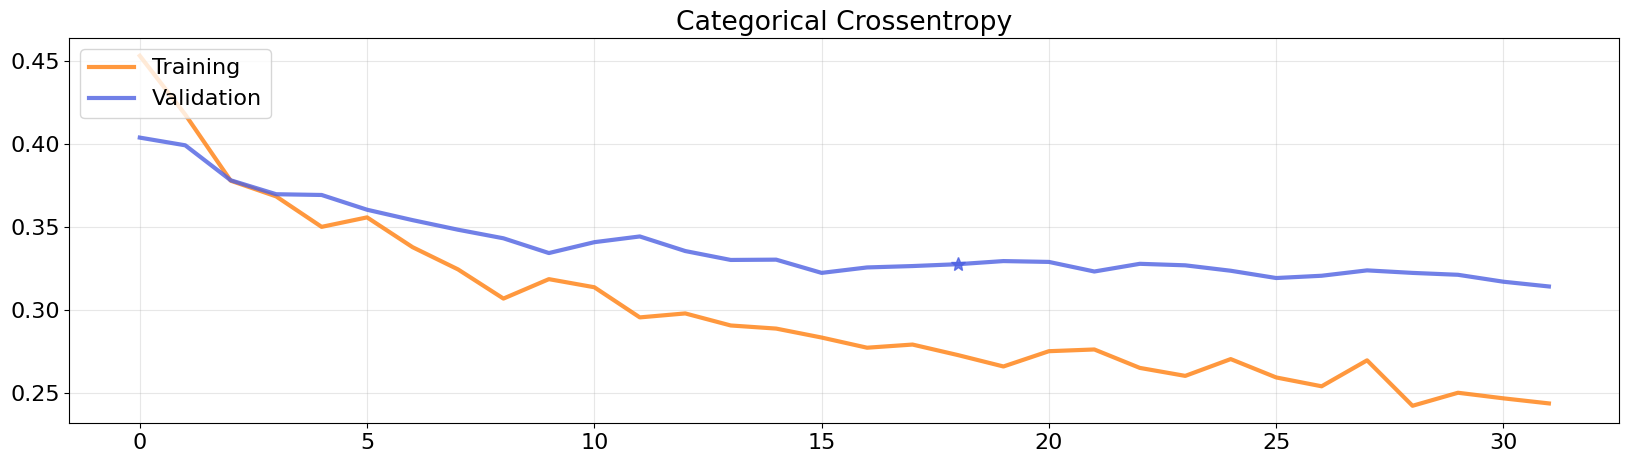

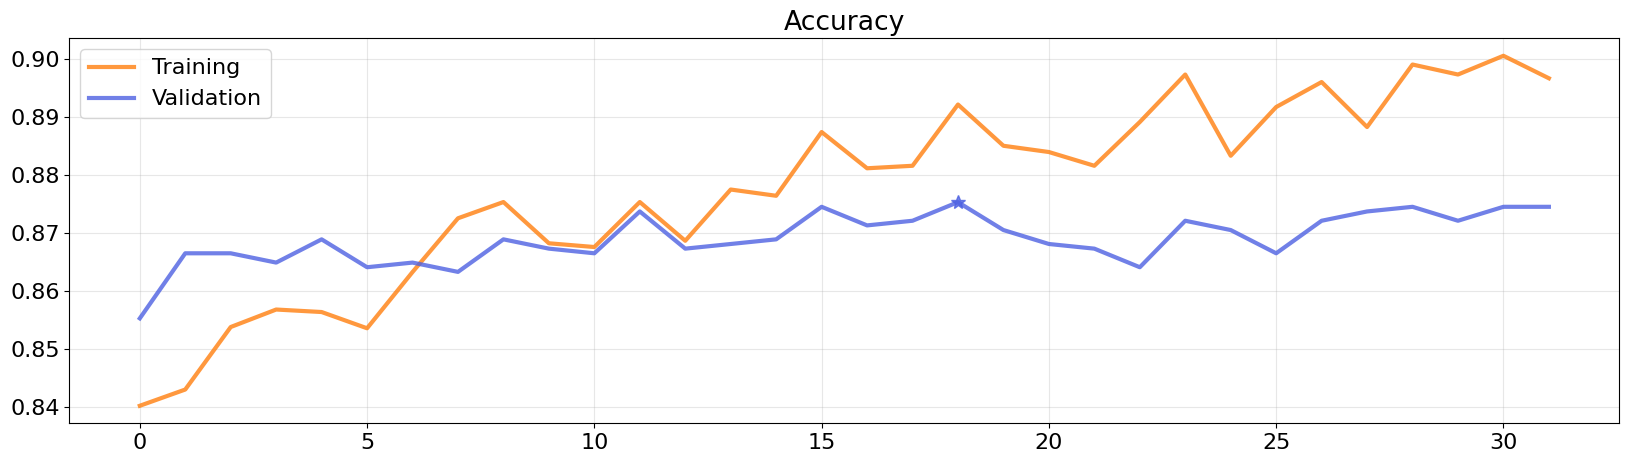

In [ ]:
plot_loss_accuracy_trend(EfficientNetV2L_MLP_ft_history,metrics='val_accuracy')

Accuracy: 0.8753
Precision: 0.8719
Recall: 0.8613
F1: 0.8659


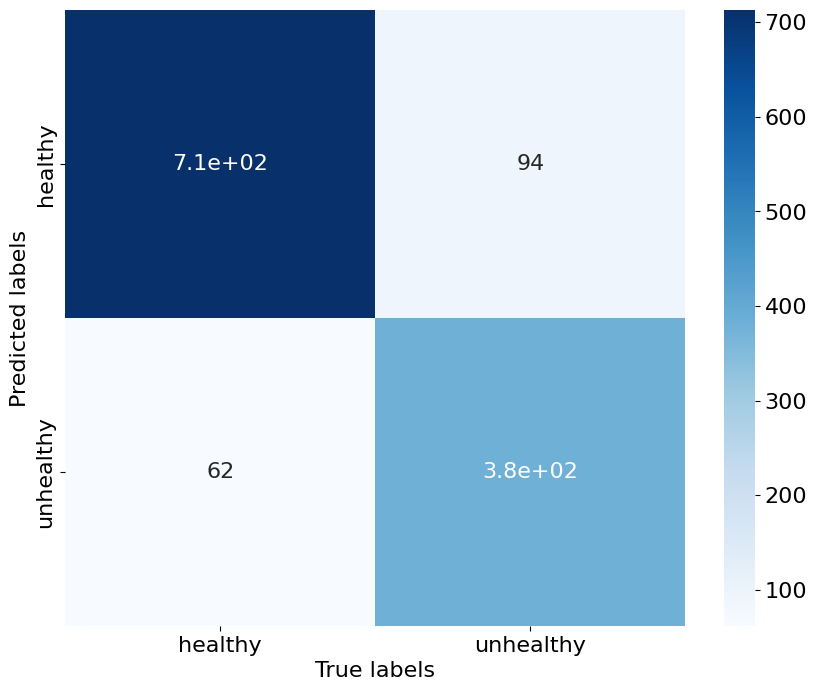

In [ ]:
(EfficientNetV2L_MLP_ft_acc,EfficientNetV2L_MLP_ft_pre,EfficientNetV2L_MLP_ft_rec,EfficientNetV2L_MLP_ft_f1)=show_metrics(EfficientNetV2L_MLP_ft,X_val,y_val,preprocess_input)

In [ ]:
EfficientNetV2L_MLP_ft.save('EfficientNetV2L_MLP_ft')

In [ ]:
del EfficientNetV2L_MLP_ft

##DenseNet 169
For what regards this network, as a first try, we released all the weights of the network, including the ones on the FEN and train them all, adding only a softmax layer as the last one. As expected, the model overfitted significantly, however we wanted to give a try also to this strategy. The next step was to fix all the weights on the network except the last softmax layer, the trainable parameters were only around 3000; the performances were reasonably commendable however there were some space for improvements without the risk of overfitting so we decided to add 3 dense layers with ReLu activation function of respectively 32,24 and 12 nodes. The performances resulted very disappointing therefore we did some tries with 2 and 1 dense layers, changing also the number of nodes for each layers. At the same time we also tried different weights initializers but the best one resulted the He normal initializer.
The best performances were obtained with a single dense layer with ReLu activation of 24 nodes, in addition to the softmax layer. However, from the confusion matrix it was deducted that the model suffered in classifying unhealthy samples. Therefore we decided to perform a fine tuning acting on the last convolutional block of the FE network on an purposely unbalanced dataset, with augmentation of unhealthy data, with the attention to set a relatively small learning rate and increase the patience for the learning rate adjustment. The overall performances increased, reaching around 0.86 accuracy on the validation set, even if the misclassified samples remained relatively high.

### DenseNet169+MLP

In [ ]:
#import needed for the model
from  tensorflow.keras.applications.densenet import preprocess_input

model=tf.keras.applications.DenseNet169(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
)

model.trainable = False

inputs = tfk.Input(shape=(96, 96, 3))

x = model(inputs)
x = tfkl.Dropout(0.5, seed=seed)(x)
x = tfkl.Dense(
    24,
    activation='relu',
    kernel_initializer = tf.keras.initializers.HeNormal(seed))(x)

#PROVARE CON GLOROT
x = tfkl.Dropout(0.5, seed=seed)(x)
outputs = tfkl.Dense(
    2,
    activation='softmax',
    kernel_initializer = tf.keras.initializers.HeNormal(seed))(x) # alternative: tfk.initializers.GlorotUniform(seed)

DenseNet= tfk.Model(inputs=inputs, outputs=outputs, name='model')


DenseNet.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])


DenseNet.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 densenet169 (Functional)    (None, 1664)              12642880  
                                                                 
 dropout_1 (Dropout)         (None, 1664)              0         
                                                                 
 dense_2 (Dense)             (None, 24)                39960     
                                                                 
 dropout_2 (Dropout)         (None, 24)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 50        
                                                                 
Total params: 12682890 (48.38 MB)
Trainable params: 40010 (15

In [ ]:
#train the model

DenseNet_history = DenseNet.fit(
      x = preprocess_input(X_train*255),
      y = y_train,
      batch_size = 16,
      epochs=250,
      validation_data = (preprocess_input(X_val*255), y_val),
      callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True) ,
      tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy',patience=10,factor=0.95,mode='min', min_lr=1e-10)]
  ).history

Epoch 1/250
291/291 [==============================] - 52s 58ms/step - loss: 0.6801 - accuracy: 0.6354 - val_loss: 0.5292 - val_accuracy: 0.7666 - lr: 0.0010
Epoch 2/250
291/291 [==============================] - 10s 36ms/step - loss: 0.5373 - accuracy: 0.7261 - val_loss: 0.4795 - val_accuracy: 0.7802 - lr: 0.0010
Epoch 3/250
291/291 [==============================] - 10s 34ms/step - loss: 0.4982 - accuracy: 0.7524 - val_loss: 0.4569 - val_accuracy: 0.7922 - lr: 0.0010
Epoch 4/250
291/291 [==============================] - 12s 40ms/step - loss: 0.4716 - accuracy: 0.7743 - val_loss: 0.4378 - val_accuracy: 0.7882 - lr: 0.0010
Epoch 5/250
291/291 [==============================] - 11s 37ms/step - loss: 0.4684 - accuracy: 0.7640 - val_loss: 0.4341 - val_accuracy: 0.7938 - lr: 0.0010
Epoch 6/250
291/291 [==============================] - 10s 34ms/step - loss: 0.4536 - accuracy: 0.7814 - val_loss: 0.4425 - val_accuracy: 0.7938 - lr: 0.0010
Epoch 7/250
291/291 [==============================]

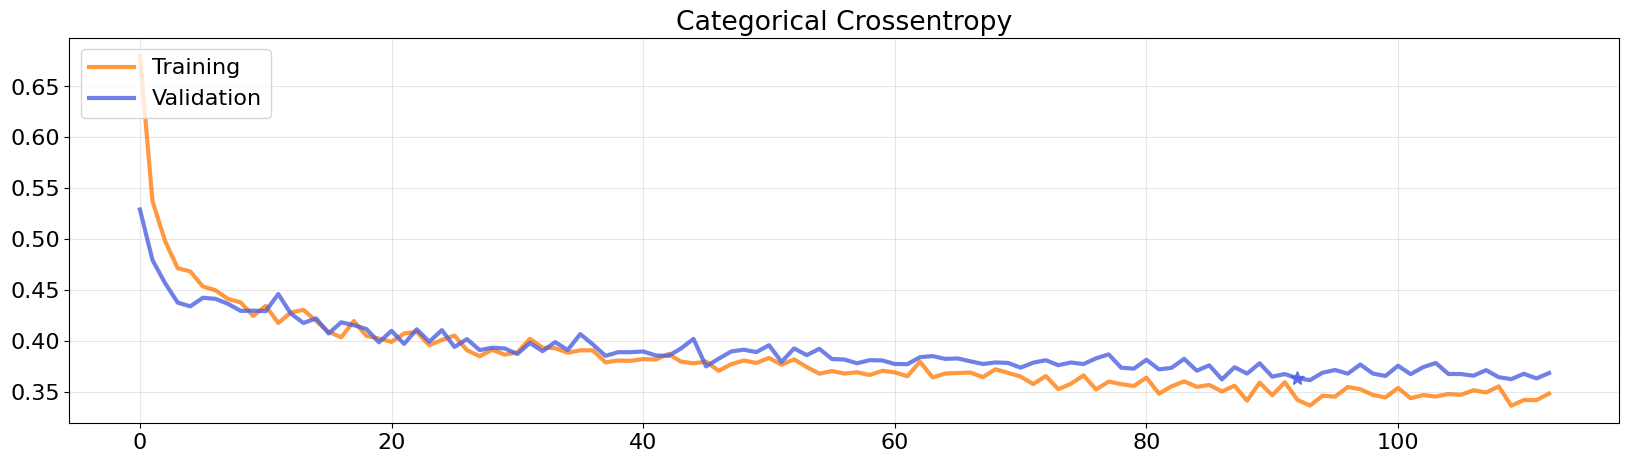

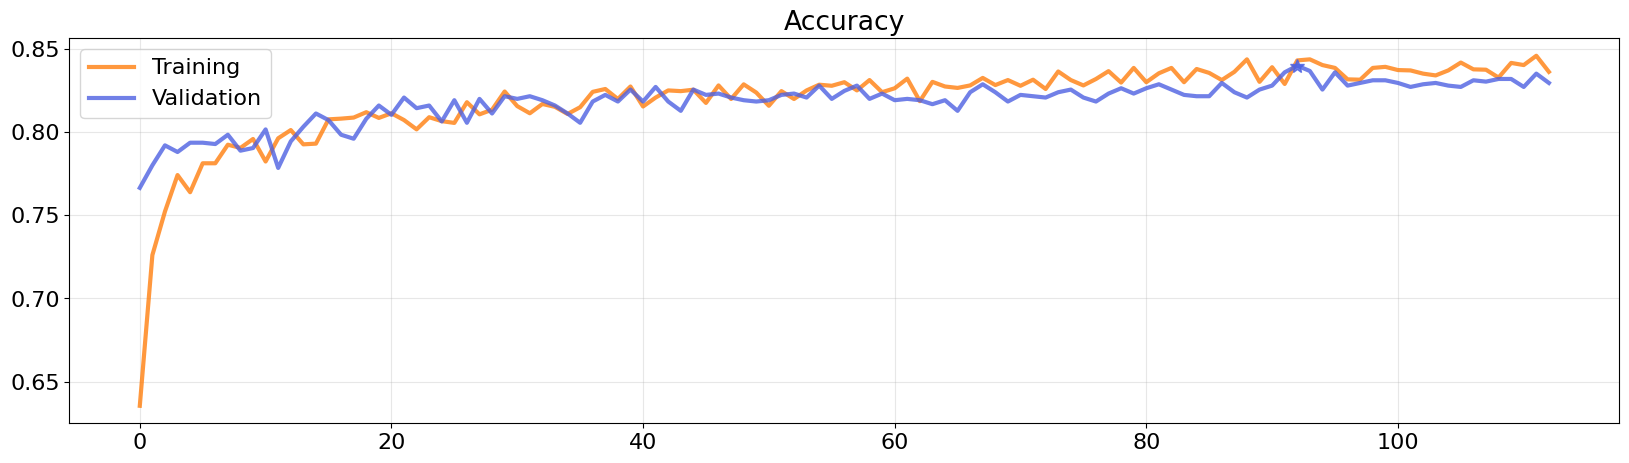

In [ ]:
plot_loss_accuracy_trend(DenseNet_history,metrics='val_accuracy')

Accuracy: 0.8401
Precision: 0.8478
Recall: 0.8102
F1: 0.822


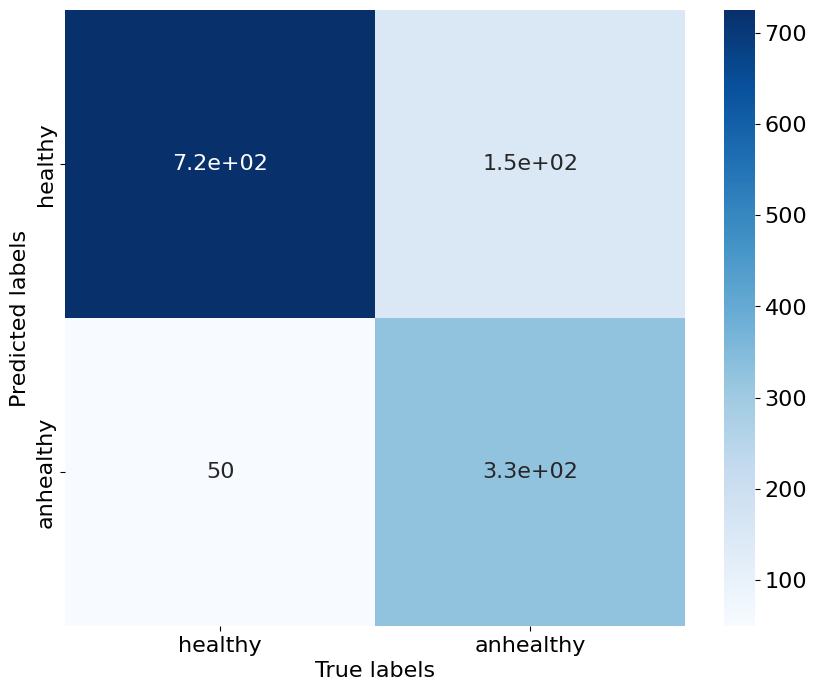

In [ ]:
(DenseNet_acc,DenseNet_pre,DenseNet_MLP_rec,DensNet_MLP_f1)=show_metrics(DenseNet,X_val,y_val,preprocess_input)

In [ ]:
DenseNet.save('DenseNet_noft')

In [ ]:
del DenseNet

### Fine tuning on DenseNet169 + MLP using unblanced data

In [ ]:
#import needed for the model
from  tensorflow.keras.applications.densenet import preprocess_input

#prova con tutto
model=tf.keras.applications.DenseNet169(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
)


model.trainable = False

inputs = tfk.Input(shape=(96, 96, 3))

x = model(inputs)

x = tfkl.Dropout(0.5, seed=seed)(x)
x = tfkl.Dense(
    24,
    activation='relu',
    kernel_initializer = tf.keras.initializers.HeNormal(seed))(x)

x = tfkl.Dropout(0.5, seed=seed)(x)
outputs = tfkl.Dense(
    2,
    activation='softmax',
    kernel_initializer = tf.keras.initializers.HeNormal(seed))(x) # alternative: tfk.initializers.GlorotUniform(seed)

DenseNet_ft= tfk.Model(inputs=inputs, outputs=outputs, name='model')


DenseNet_ft.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])


DenseNet_ft.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 densenet169 (Functional)    (None, 1664)              12642880  
                                                                 
 dropout_5 (Dropout)         (None, 1664)              0         
                                                                 
 dense_5 (Dense)             (None, 24)                39960     
                                                                 
 dropout_6 (Dropout)         (None, 24)                0         
                                                                 
 dense_6 (Dense)             (None, 2)                 50        
                                                                 
Total params: 12682890 (48.38 MB)
Trainable params: 40010 (15

In [ ]:
DenseNet_ft_history = DenseNet_ft.fit(
      x = preprocess_input(X_train*255),
      y = y_train,
      batch_size = 16,
      epochs=250,
      validation_data = (preprocess_input(X_val*255), y_val),
      callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True) ,
      tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy',patience=10,factor=0.95,mode='min', min_lr=1e-10)]
  ).history

Epoch 1/250
291/291 [==============================] - 78s 51ms/step - loss: 0.6801 - accuracy: 0.6354 - val_loss: 0.5292 - val_accuracy: 0.7666 - lr: 0.0010
Epoch 2/250
291/291 [==============================] - 10s 36ms/step - loss: 0.5373 - accuracy: 0.7261 - val_loss: 0.4795 - val_accuracy: 0.7802 - lr: 0.0010
Epoch 3/250
291/291 [==============================] - 11s 38ms/step - loss: 0.4982 - accuracy: 0.7524 - val_loss: 0.4569 - val_accuracy: 0.7922 - lr: 0.0010
Epoch 4/250
291/291 [==============================] - 11s 37ms/step - loss: 0.4716 - accuracy: 0.7743 - val_loss: 0.4378 - val_accuracy: 0.7882 - lr: 0.0010
Epoch 5/250
291/291 [==============================] - 10s 36ms/step - loss: 0.4684 - accuracy: 0.7640 - val_loss: 0.4341 - val_accuracy: 0.7938 - lr: 0.0010
Epoch 6/250
291/291 [==============================] - 10s 34ms/step - loss: 0.4536 - accuracy: 0.7814 - val_loss: 0.4425 - val_accuracy: 0.7938 - lr: 0.0010
Epoch 7/250
291/291 [==============================]

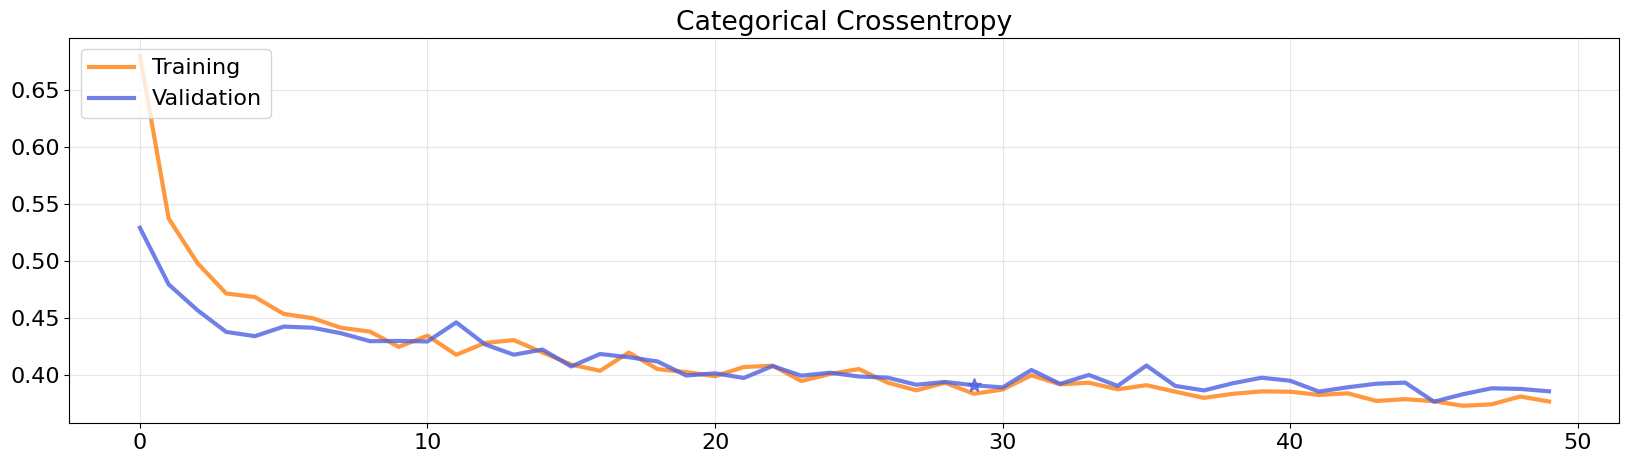

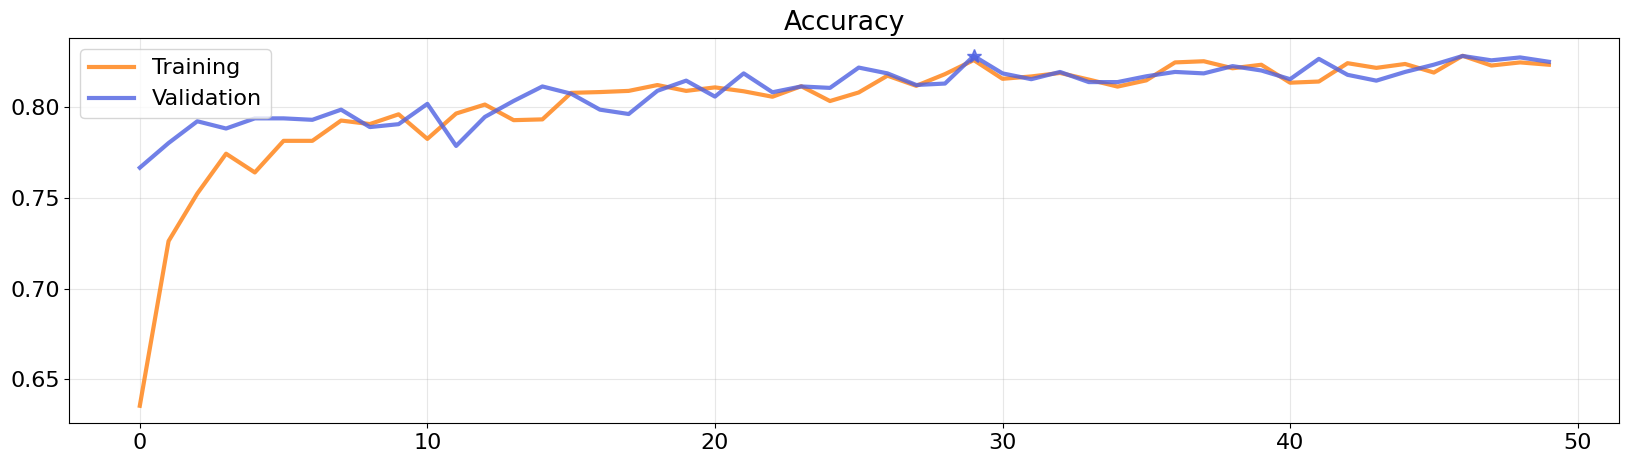

In [ ]:
plot_loss_accuracy_trend(DenseNet_ft_history,metrics='val_accuracy')

Accuracy: 0.8281
Precision: 0.8274
Recall: 0.8025
F1: 0.8113


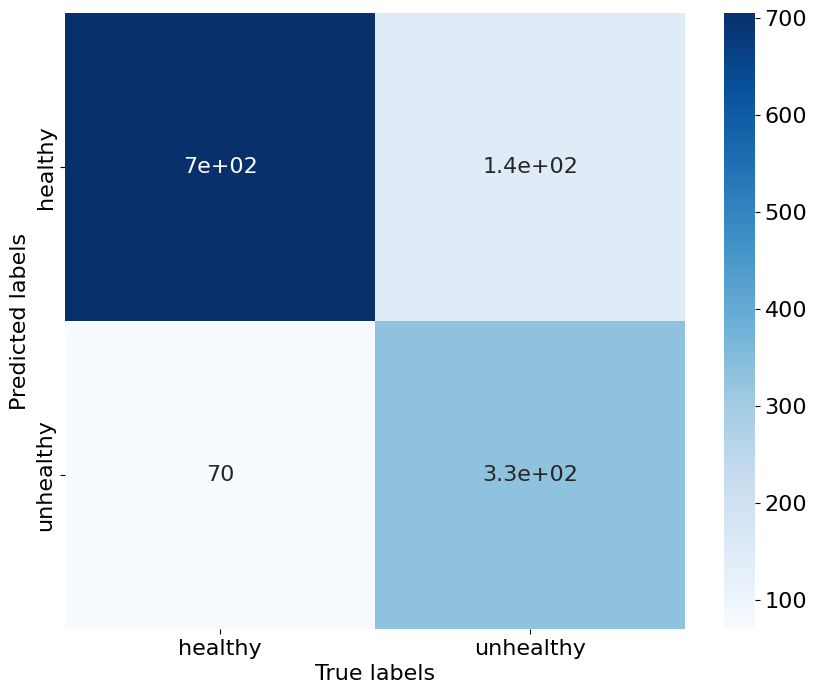

In [ ]:
(DenseNet_ft_acc,DenseNet_ft_pre,DenseNet_ft_rec,DenseNet_ft_f1)=show_metrics(DenseNet_ft,X_val,y_val,preprocess_input)

We can see that the classification error mainly concerns the unhealthy samples that are miclassified as healthy. A possible solution is to additionally train the last layers of the model with an unbalanced dataset towards unhealthy sample.

In [ ]:
#fine tuning with unbalanced data

string_model='densenet169'
DenseNet_ft.get_layer(string_model).trainable = True #we set all the layers of the conv part to trainable
for i, layer in enumerate(DenseNet_ft.get_layer(string_model).layers):
   print(i, layer.name, layer.trainable)

N = 579
for i, layer in enumerate(DenseNet_ft.get_layer(string_model).layers[:N]):
  layer.trainable=False
for i, layer in enumerate(DenseNet_ft.get_layer(string_model).layers):
   print(i, layer.name, layer.trainable)
DenseNet_ft.summary()

DenseNet_ft.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics='accuracy')

0 input_5 True
1 zero_padding2d_2 True
2 conv1/conv True
3 conv1/bn True
4 conv1/relu True
5 zero_padding2d_3 True
6 pool1 True
7 conv2_block1_0_bn True
8 conv2_block1_0_relu True
9 conv2_block1_1_conv True
10 conv2_block1_1_bn True
11 conv2_block1_1_relu True
12 conv2_block1_2_conv True
13 conv2_block1_concat True
14 conv2_block2_0_bn True
15 conv2_block2_0_relu True
16 conv2_block2_1_conv True
17 conv2_block2_1_bn True
18 conv2_block2_1_relu True
19 conv2_block2_2_conv True
20 conv2_block2_concat True
21 conv2_block3_0_bn True
22 conv2_block3_0_relu True
23 conv2_block3_1_conv True
24 conv2_block3_1_bn True
25 conv2_block3_1_relu True
26 conv2_block3_2_conv True
27 conv2_block3_concat True
28 conv2_block4_0_bn True
29 conv2_block4_0_relu True
30 conv2_block4_1_conv True
31 conv2_block4_1_bn True
32 conv2_block4_1_relu True
33 conv2_block4_2_conv True
34 conv2_block4_concat True
35 conv2_block5_0_bn True
36 conv2_block5_0_relu True
37 conv2_block5_1_conv True
38 conv2_block5_1_bn True

In [ ]:
#train with unbalanced data
DenseNet_ft_history = DenseNet_ft.fit(
      x = preprocess_input(X_train_2*255),
      y = y_train_2,
      batch_size = 16,
      epochs=250,
      validation_data = (preprocess_input(X_val*255), y_val),
      callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True) ,
      tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy',patience=10,factor=0.95,mode='min', min_lr=1e-10)]
  ).history

Epoch 1/250
291/291 [==============================] - 27s 55ms/step - loss: 1.4052 - accuracy: 0.7498 - val_loss: 0.9407 - val_accuracy: 0.7666 - lr: 1.0000e-05
Epoch 2/250
291/291 [==============================] - 11s 39ms/step - loss: 1.2610 - accuracy: 0.7543 - val_loss: 0.8261 - val_accuracy: 0.7818 - lr: 1.0000e-05
Epoch 3/250
291/291 [==============================] - 10s 35ms/step - loss: 1.0965 - accuracy: 0.7515 - val_loss: 0.7320 - val_accuracy: 0.7874 - lr: 1.0000e-05
Epoch 4/250
291/291 [==============================] - 11s 37ms/step - loss: 1.0083 - accuracy: 0.7599 - val_loss: 0.6520 - val_accuracy: 0.7914 - lr: 1.0000e-05
Epoch 5/250
291/291 [==============================] - 12s 40ms/step - loss: 0.9039 - accuracy: 0.7610 - val_loss: 0.5984 - val_accuracy: 0.7898 - lr: 1.0000e-05
Epoch 6/250
291/291 [==============================] - 11s 39ms/step - loss: 0.8461 - accuracy: 0.7539 - val_loss: 0.5616 - val_accuracy: 0.7834 - lr: 1.0000e-05
Epoch 7/250
291/291 [=======

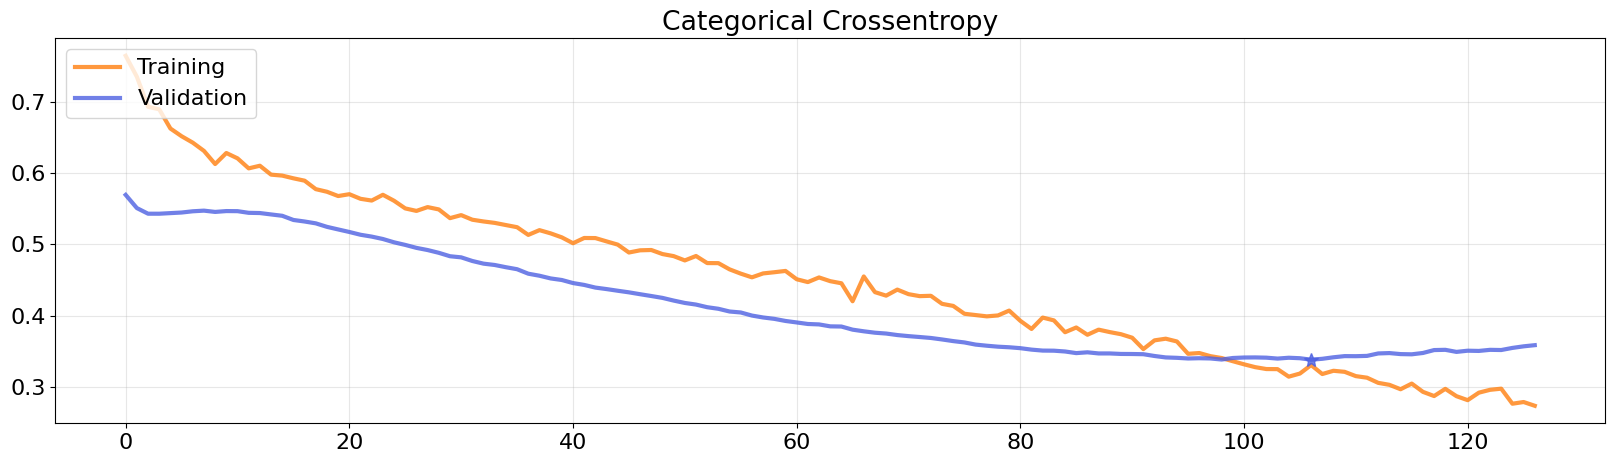

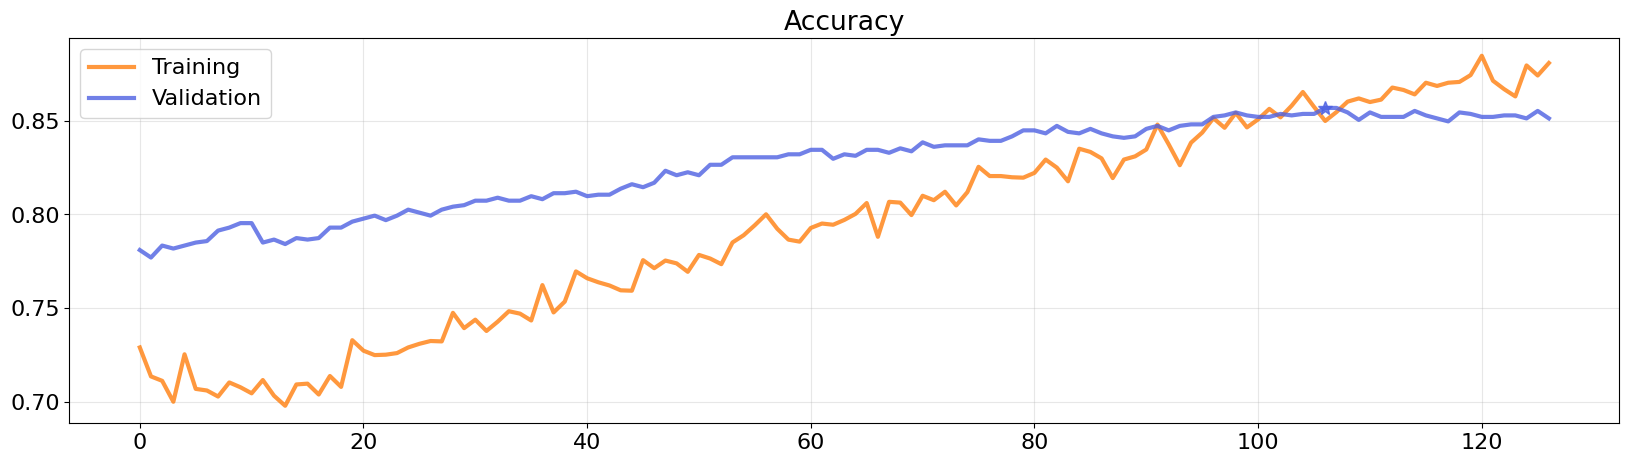

In [ ]:
plot_loss_accuracy_trend(DenseNet_ft_history,metrics='val_accuracy')

Accuracy: 0.8585
Precision: 0.8594
Recall: 0.8372
F1: 0.8456


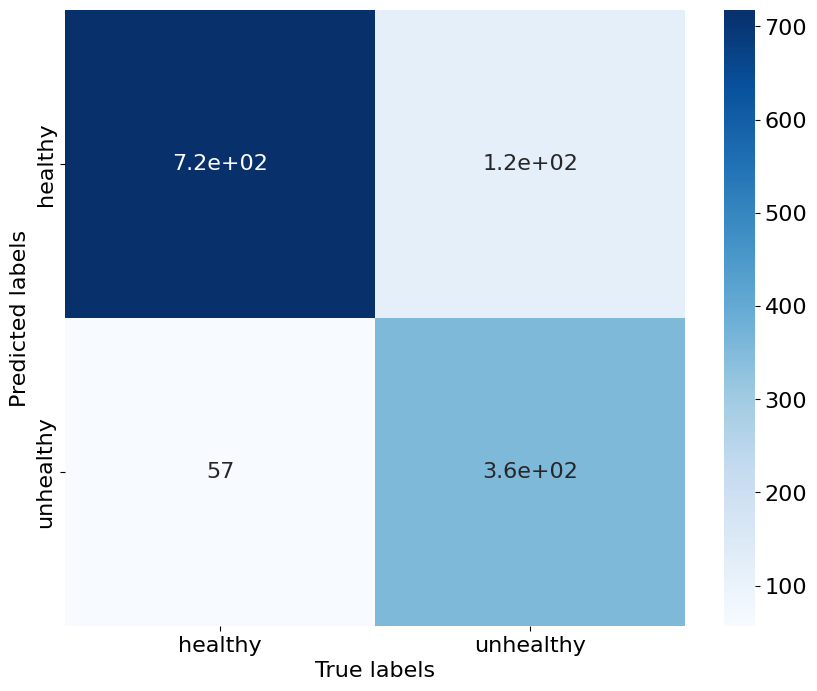

In [ ]:
(DenseNet_ft_acc,DenseNet_ft_pre,DenseNet_ft_rec,DenseNet_ft_f1)=show_metrics(DenseNet_ft,X_val,y_val,preprocess_input)

##VGG16
For what regards this model, the workflow followed was almost the same as for the DenseNet network, the final decision was to add 2 dense layers, both with ReLu activation, of 64 and 22 nodes each, in addition to the softmax classification layer. The main difference was that the network was msisclassifing significantly the healthy samples, therefore the strategy was specular to the one of DenseNet but with an augmented dataset toward healthy samples. The final result, however, was not as satisfactory as for the other networks developed.

### VGG16+MLP

In [ ]:
#import needed for the model
from  tensorflow.keras.applications.vgg16 import preprocess_input


model = tf.keras.applications.VGG16(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet", #you select the dataset to use for training weights
    pooling='avg',
)

model.trainable = False

inputs = tfk.Input(shape=(96, 96, 3))

x = model(inputs)

x = tfkl.Dropout(0.5, seed=seed)(x)
x = tfkl.Dense(
    64,
    activation='relu',
    kernel_initializer = tf.keras.initializers.HeNormal(seed))(x)

x = tfkl.Dropout(0.5, seed=seed)(x)
x = tfkl.Dense(
    22,
    activation='relu',
    kernel_initializer = tf.keras.initializers.HeNormal(seed))(x)

x = tfkl.Dropout(0.5, seed=seed)(x)
outputs = tfkl.Dense(
    2,
    activation='softmax',
    kernel_initializer = tf.keras.initializers.HeNormal(seed))(x) # alternative: tfk.initializers.GlorotUniform(seed)


Vgg = tfk.Model(inputs=inputs, outputs=outputs, name='model')


Vgg.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])


Vgg.summary()



58889256/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 22)                1430      
                                                              

In [ ]:
Vgg_history = Vgg.fit(
      x = preprocess_input(X_train*255),
      y = y_train,
      batch_size = 16,
      epochs=250,
      validation_data = (preprocess_input(X_val*255), y_val),
      callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True) ,
      tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy',patience=10,factor=0.95,mode='min', min_lr=1e-10)]
  ).history

Epoch 1/250
291/291 [==============================] - 24s 28ms/step - loss: 2.8263 - accuracy: 0.5228 - val_loss: 0.6809 - val_accuracy: 0.6059 - lr: 0.0010
Epoch 2/250
291/291 [==============================] - 7s 23ms/step - loss: 0.8150 - accuracy: 0.5067 - val_loss: 0.6901 - val_accuracy: 0.5683 - lr: 0.0010
Epoch 3/250
291/291 [==============================] - 6s 22ms/step - loss: 0.7361 - accuracy: 0.5316 - val_loss: 0.6865 - val_accuracy: 0.5436 - lr: 0.0010
Epoch 4/250
291/291 [==============================] - 8s 28ms/step - loss: 0.6988 - accuracy: 0.5353 - val_loss: 0.6961 - val_accuracy: 0.4556 - lr: 0.0010
Epoch 5/250
291/291 [==============================] - 6s 22ms/step - loss: 0.6878 - accuracy: 0.5623 - val_loss: 0.6823 - val_accuracy: 0.5476 - lr: 0.0010
Epoch 6/250
291/291 [==============================] - 8s 27ms/step - loss: 0.6809 - accuracy: 0.5770 - val_loss: 0.6756 - val_accuracy: 0.5476 - lr: 0.0010
Epoch 7/250
291/291 [==============================] - 6s

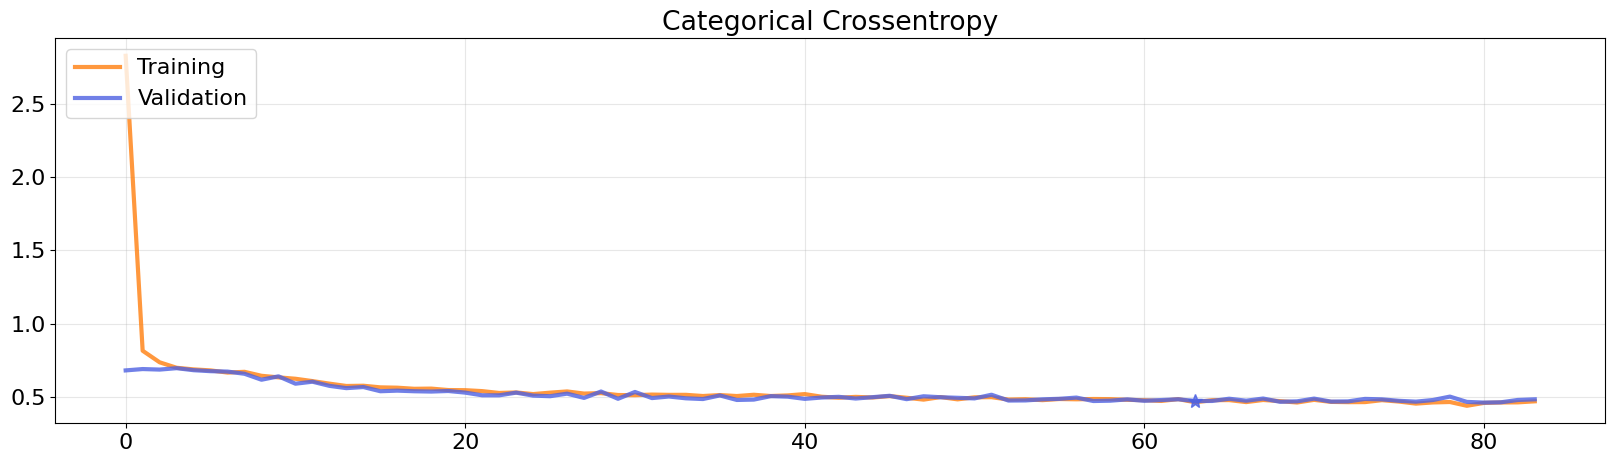

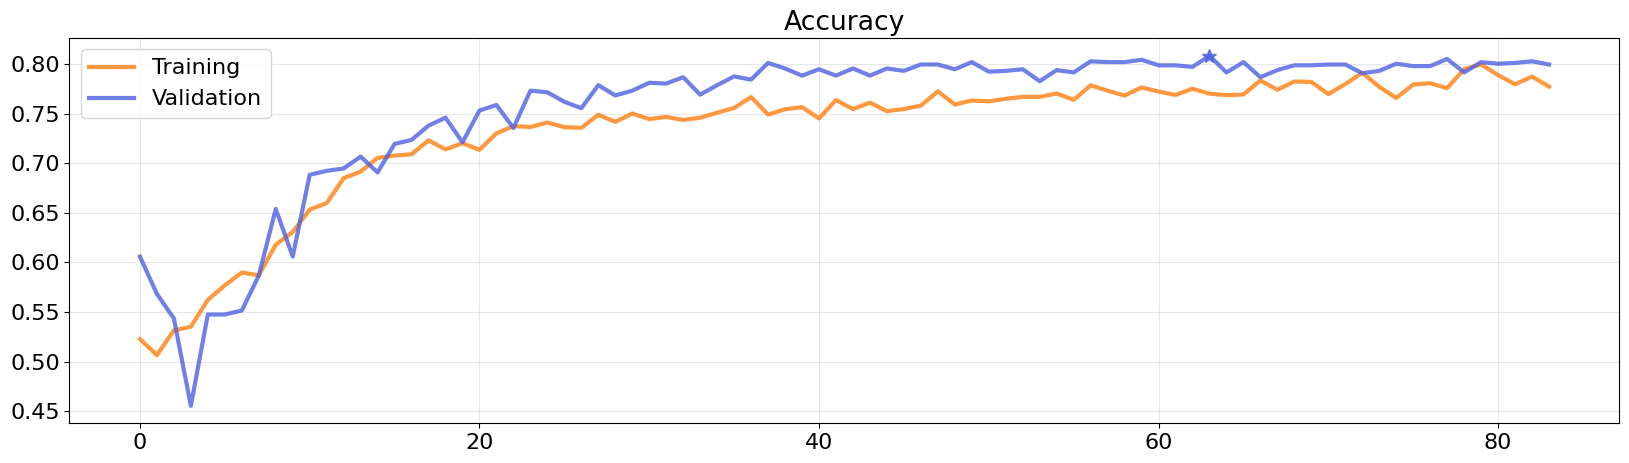

In [ ]:
plot_loss_accuracy_trend(Vgg_history,metrics='val_accuracy')

Accuracy: 0.8082
Precision: 0.7966
Recall: 0.7961
F1: 0.7964


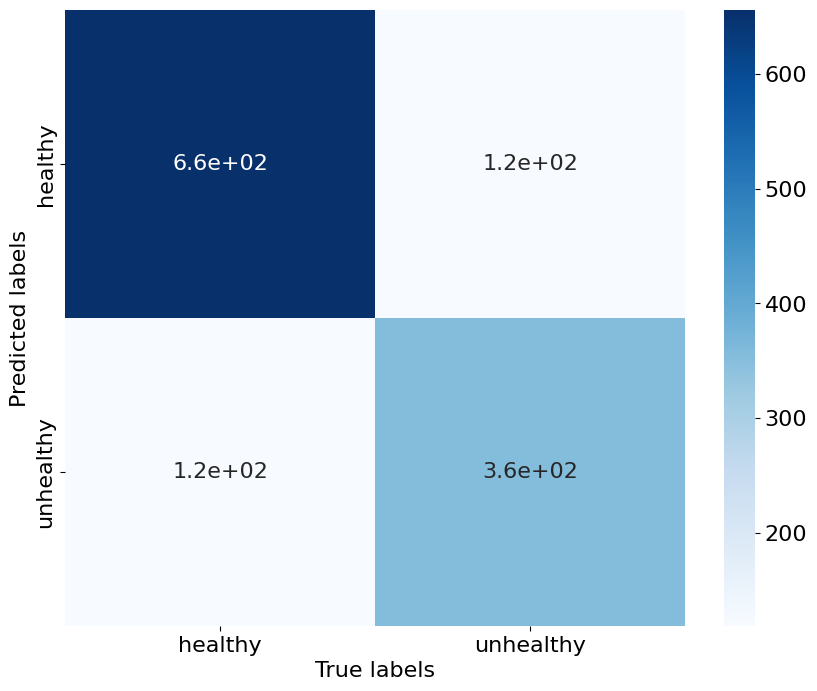

In [ ]:
(Vgg_acc,Vgg_pre,Vgg_rec,Vgg_f1)=show_metrics(Vgg,X_val,y_val,preprocess_input)

In [ ]:
Vgg.save('Vgg_noft')

### Fine tuning on VGG16 + MLP using unbalanced data

In [ ]:
string_model='vgg16'
Vgg_ft=Vgg
Vgg_ft.get_layer(string_model).trainable = True #we set all the layers of the conv part to trainable
for i, layer in enumerate(Vgg_ft.get_layer(string_model).layers):
   print(i, layer.name, layer.trainable)

N = 11
for i, layer in enumerate(Vgg_ft.get_layer(string_model).layers[:N]):
  layer.trainable=False
for i, layer in enumerate(Vgg_ft.get_layer(string_model).layers):
   print(i, layer.name, layer.trainable)
Vgg_ft.summary()


0 input_1 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
19 global_average_pooling2d True
0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
19 global_average_pooling2d True
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLay

In [ ]:
Vgg_ft.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics='accuracy')

In [ ]:
Vgg_ft_history = Vgg_ft.fit(
    x = preprocess_input(X_train_3*255),
    y = y_train_3,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True)]
).history

291/291 [==============================] - 18s 43ms/step - loss: 0.7735 - accuracy: 0.5591 - val_loss: 0.6999 - val_accuracy: 0.4141
Epoch 2/200
291/291 [==============================] - 12s 40ms/step - loss: 0.7040 - accuracy: 0.5544 - val_loss: 0.6998 - val_accuracy: 0.3853
Epoch 3/200
291/291 [==============================] - 12s 40ms/step - loss: 0.6962 - accuracy: 0.5724 - val_loss: 0.6898 - val_accuracy: 0.4500
Epoch 4/200
291/291 [==============================] - 12s 40ms/step - loss: 0.6911 - accuracy: 0.5937 - val_loss: 0.6862 - val_accuracy: 0.4508
Epoch 5/200
291/291 [==============================] - 12s 41ms/step - loss: 0.6888 - accuracy: 0.6238 - val_loss: 0.6851 - val_accuracy: 0.4612
Epoch 6/200
291/291 [==============================] - 12s 41ms/step - loss: 0.6802 - accuracy: 0.6612 - val_loss: 0.6775 - val_accuracy: 0.5324
Epoch 7/200
291/291 [==============================] - 12s 41ms/step - loss: 0.6742 - accuracy: 0.6881 - val_loss: 0.6718 - val_accuracy: 0.64

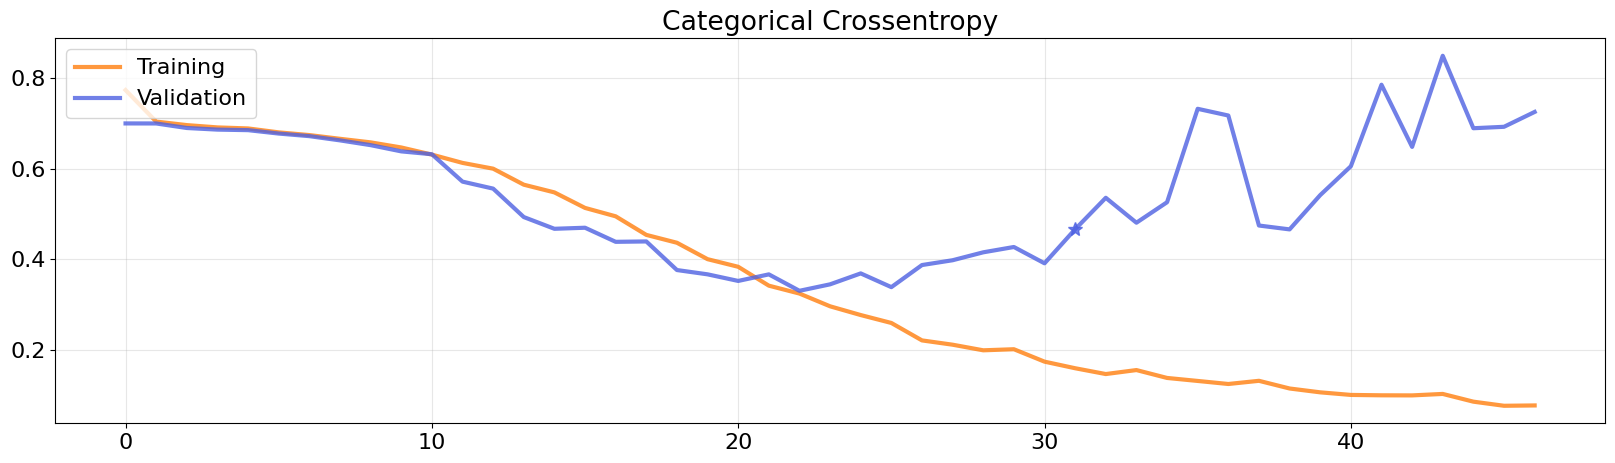

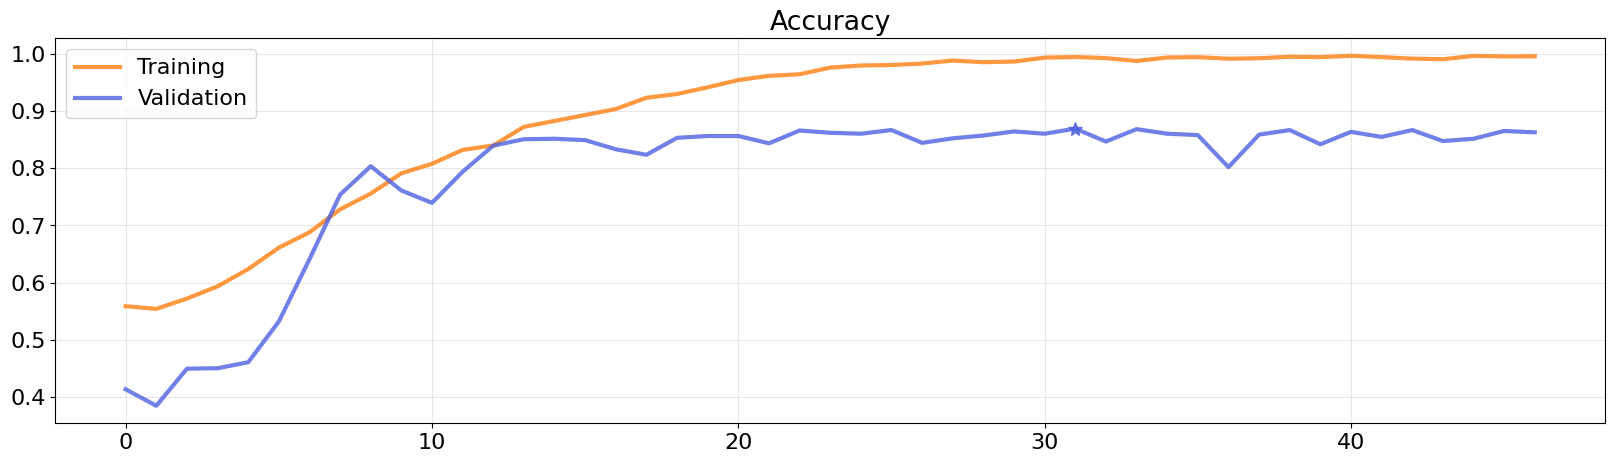

In [ ]:
plot_loss_accuracy_trend(Vgg_ft_history,metrics='val_accuracy')

Accuracy: 0.8825
Precision: 0.8827
Recall: 0.8659
F1: 0.8728


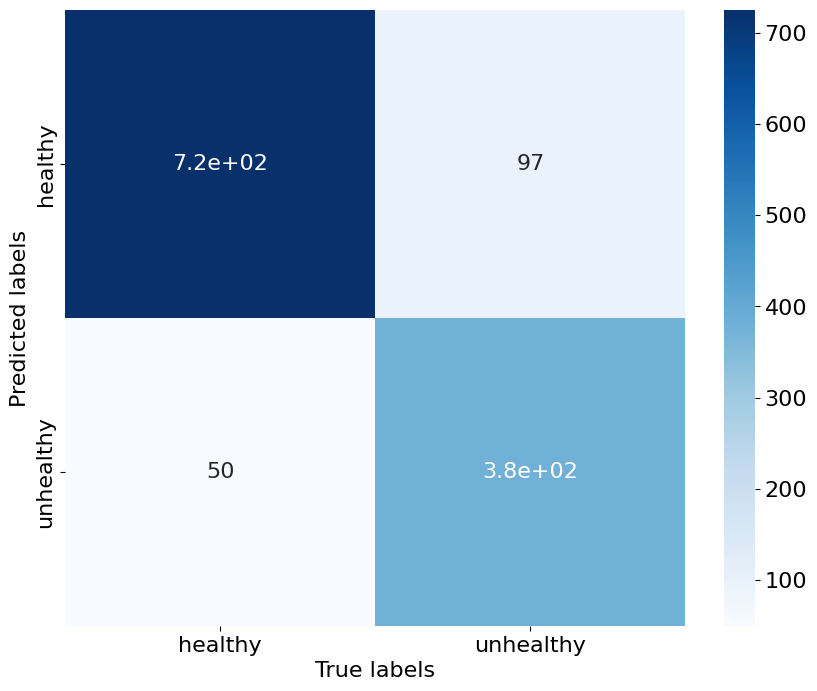

In [ ]:
(Vgg_ft_acc,Vgg_ft_pre,Vgg_ft_rec,Vgg_ft_f1)=show_metrics(Vgg_ft,X_val,y_val,preprocess_input)

In [ ]:
Vgg_ft.save('Vgg_ft')
del Vgg_ft